In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import training as tr
import emnet

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable

## Write events to a DataFrame

In [ ]:
datfile = "/home/jrenner/local/data/electronsim/pixelated_tracks_thinned_4um_back_10M_300keV.txt"

In [53]:
rng_pixels = np.arange(-(tr.EVT_SIZE-1)/2,(tr.EVT_SIZE-1)/2+1)
coords_pixels_all = np.meshgrid(rng_pixels,rng_pixels)

def read_electron_data(fname, nevts=1000):
    
    evt = -1
    xinc = 0.0
    yinc = 0.0
    front = True
    energy = 0.0
    
    # Open the file and read the specified number of events.
    l_evt, l_xinc, l_yinc, l_front, l_energy, l_row, l_col, l_counts = [], [], [], [], [], [], [], []
    evts_read = 0
    with open(fname) as f:
        
        # Iterate through all lines.
        for line in f:
            
            # Stop reading if we've read the specified number of events.
            if(evts_read > nevts):
                break
            
            # Get each number in the line, separated by spaces.
            vals = line.rstrip().split(" ")
            
            # Start a new event.
            if(vals[0] == "EV"):
                evt    = vals[1]
                xinc   = vals[2]
                yinc   = vals[3]
                front  = (vals[4] == 1)
                energy = vals[5]
                evts_read += 1
                
            # Add a row for the current event.
            else:
                l_evt.append(int(evt))
                l_xinc.append(float(xinc))
                l_yinc.append(float(yinc))
                l_front.append(front)
                l_energy.append(float(energy))
                l_row.append(int(vals[0]))
                l_col.append(int(vals[1]))
                l_counts.append(int(vals[2]))
    
    # Construct the DataFrame.
    evt_dict = {'event': l_evt, 'xinc': l_xinc, 'yinc': l_yinc, 'front': l_front, 
                'energy': l_energy, 'row': l_row, 'col': l_col, 'counts': l_counts}
    df = pd.DataFrame.from_dict(evt_dict)
    
    return df

def compute_moments(evt_arr,args,order,pixel_size,coords_pixels):
    """
    Compute the x- and y-moments of the specified order.
    
    evt_arr: the original (unmodified) event array
    args:    the arguments into evt_arr of the pixels to be included
    order:   the order of the moment
    """
    
    xsum = 0  # x-moment sum
    ysum = 0  # y-moment sum
    tsum = 0  # total sum
    for arg in args:

        px = evt_arr[(arg[0],arg[1])]
        x  = coords_pixels[0][(arg[0],arg[1])]*pixel_size
        y  = coords_pixels[1][(arg[0],arg[1])]*pixel_size
        
        xsum += px*x**order
        ysum += px*y**order
        tsum += px
    
    if(tsum > 0):
        
        mx = xsum/tsum
        my = ysum/tsum

        return mx,my
    
    else:
        return 0.,0.

def compute_key_quantities(evt_arr,pixel_size,threshold=40):
    """
    Get key quantities from the event array.
    """
    
    # Get the pixels above threshold and their corresponding arguments in the array.
    pixels_above_threshold = evt_arr[evt_arr > threshold]
    args_above_threshold = np.argwhere(evt_arr > threshold)
    arg_max = (20,20) #np.unravel_index(np.argmax(evt_arr),evt_arr.shape)
    xmax = coords_pixels_all[0][arg_max]*pixel_size
    ymax = coords_pixels_all[1][arg_max]*pixel_size
    #print("xmax",xmax,"ymax",ymax)
    
    # number of pixels above threshold
    n_above_threshold = len(args_above_threshold)

    # sum of pixels above threshold
    sum_above_threshold = np.sum(pixels_above_threshold)

    # maximum distance between pixels above threshold
    max_dist = 0
    for arg0 in args_above_threshold:
        for arg1 in args_above_threshold:
            dist = ((arg0[0] - arg1[0])**2 + (arg0[1] - arg1[1])**2)**0.5
            if(dist > max_dist):
                max_dist = dist
    max_dist_above_threshold = max_dist*pixel_size

    # moments for pixels above threshold
    m1x, m1y = compute_moments(evt_arr,args_above_threshold,1,pixel_size,coords_pixels_all)
    m2x, m2y = compute_moments(evt_arr,args_above_threshold,2,pixel_size,coords_pixels_all)

    # moments for 3x3 region about maximum
    max_3x3 = evt_arr[max(arg_max[0]-1,0):min(arg_max[0]+2,evt_arr.shape[0]),max(arg_max[1]-1,0):min(arg_max[1]+2,evt_arr.shape[1])]
    coords_pixels_3x3 = [coords_pixels_all[0][max(arg_max[0]-1,0):min(arg_max[0]+2,evt_arr.shape[0]),max(arg_max[1]-1,0):min(arg_max[1]+2,evt_arr.shape[1])],
                         coords_pixels_all[1][max(arg_max[0]-1,0):min(arg_max[0]+2,evt_arr.shape[0]),max(arg_max[1]-1,0):min(arg_max[1]+2,evt_arr.shape[1])]]
    args_3x3 = np.argwhere(max_3x3 > 0)
    args_3x3_above_threshold = np.argwhere(max_3x3 > threshold)
    xc_3x3, yc_3x3 = compute_moments(max_3x3,args_3x3,1,pixel_size,coords_pixels_3x3)
    xc_3x3_above_threshold, yc_3x3_above_threshold = compute_moments(max_3x3,args_3x3_above_threshold,1,pixel_size,coords_pixels_3x3)
    
    xc_3x3 = xc_3x3
    yc_3x3 = yc_3x3
    xc_3x3_above_threshold = xc_3x3_above_threshold
    yc_3x3_above_threshold = yc_3x3_above_threshold

    # moments for 5x5 region about maximum
    max_5x5 = evt_arr[max(arg_max[0]-2,0):min(arg_max[0]+3,evt_arr.shape[0]),max(arg_max[1]-2,0):min(arg_max[1]+3,evt_arr.shape[1])]
    coords_pixels_5x5 = [coords_pixels_all[0][max(arg_max[0]-2,0):min(arg_max[0]+3,evt_arr.shape[0]),max(arg_max[1]-2,0):min(arg_max[1]+3,evt_arr.shape[1])],
                         coords_pixels_all[1][max(arg_max[0]-2,0):min(arg_max[0]+3,evt_arr.shape[0]),max(arg_max[1]-2,0):min(arg_max[1]+3,evt_arr.shape[1])]]
    args_5x5 = np.argwhere(max_5x5 > 0)
    args_5x5_above_threshold = np.argwhere(max_5x5 > threshold)
    xc_5x5, yc_5x5 = compute_moments(max_5x5,args_5x5,1,pixel_size,coords_pixels_5x5)
    xc_5x5_above_threshold, yc_5x5_above_threshold = compute_moments(max_5x5,args_5x5_above_threshold,1,pixel_size,coords_pixels_5x5)
    
    xc_5x5 = xc_5x5
    yc_5x5 = yc_5x5
    xc_5x5_above_threshold = xc_5x5_above_threshold
    yc_5x5_above_threshold = yc_5x5_above_threshold
    
    return [n_above_threshold, sum_above_threshold, max_dist_above_threshold,
            xmax, ymax,
            m1x, m1y, m2x, m2y, 
            xc_3x3, yc_3x3, xc_3x3_above_threshold, yc_3x3_above_threshold,
            xc_5x5, yc_5x5, xc_5x5_above_threshold, yc_5x5_above_threshold]

def construct_evt_dataframe(dset,pixel_size,threshold=40):
    """
    Constructs a dataframe containing key information for each of the specified events.
    """
    
    l_n_above_threshold, l_sum_above_threshold, l_max_dist_above_threshold = [], [], []
    l_xmax, l_ymax = [], []
    l_m1_x_above_threshold, l_m1_y_above_threshold, l_m2_x_above_threshold, l_m2_y_above_threshold = [], [], [], []
    l_xc_3x3, l_yc_3x3, l_xc_3x3_above_threshold, l_yc_3x3_above_threshold = [], [], [], []
    l_xc_5x5, l_yc_5x5, l_xc_5x5_above_threshold, l_yc_5x5_above_threshold = [], [], [], []
    
    for i in range(100): #len(dset)):
        
        # Get the event pixel information.
        evt_item = dset[i]
        evt_arr = evt_item[0]
        
        [n_above_threshold, sum_above_threshold, max_dist_above_threshold, 
            xmax, ymax,
            m1x_above_threshold, m1y_above_threshold, m2x_above_threshold, m2y_above_threshold, 
            xc_3x3, yc_3x3, xc_3x3_above_threshold, yc_3x3_above_threshold,
            xc_5x5, yc_5x5, xc_5x5_above_threshold, yc_5x5_above_threshold] = compute_key_quantities(evt_arr,pixel_size)
        
        l_n_above_threshold.append(n_above_threshold)
        l_sum_above_threshold.append(sum_above_threshold)
        l_max_dist_above_threshold.append(max_dist_above_threshold)
        l_xmax.append(xmax)
        l_ymax.append(ymax)
        l_m1_x_above_threshold.append(m1x_above_threshold)
        l_m1_y_above_threshold.append(m1y_above_threshold)
        l_m2_x_above_threshold.append(m2x_above_threshold)
        l_m2_y_above_threshold.append(m2y_above_threshold)
        l_xc_3x3.append(xc_3x3)
        l_yc_3x3.append(yc_3x3)
        l_xc_3x3_above_threshold.append(xc_3x3_above_threshold)
        l_yc_3x3_above_threshold.append(yc_3x3_above_threshold)
        l_xc_5x5.append(xc_5x5)
        l_yc_5x5.append(yc_5x5)
        l_xc_5x5_above_threshold.append(xc_5x5_above_threshold)
        l_yc_5x5_above_threshold.append(yc_5x5_above_threshold)
        
    # Construct the DataFrame.
    evt_dict = {'n_above_threshold': l_n_above_threshold, 
                'sum_above_threshold': l_sum_above_threshold, 
                'max_dist_above_threshold': l_max_dist_above_threshold,
                'xmax': l_xmax,
                'ymax': l_ymax,
                'm1_x_above_threshold': l_m1_x_above_threshold, 
                'm1_y_above_threshold': l_m1_y_above_threshold,
                'm2_x_above_threshold': l_m2_x_above_threshold,
                'm2_y_above_threshold': l_m2_y_above_threshold,
                'xc_3x3': l_xc_3x3,
                'yc_3x3': l_yc_3x3,
                'xc_3x3_above_threshold': l_xc_3x3_above_threshold,
                'yc_3x3_above_threshold': l_yc_3x3_above_threshold,
                'xc_5x5': l_xc_5x5,
                'yc_5x5': l_yc_5x5,
                'xc_5x5_above_threshold': l_xc_5x5_above_threshold,
                'yc_5x5_above_threshold': l_yc_5x5_above_threshold}
    df = pd.DataFrame.from_dict(evt_dict)
    
    return df


In [ ]:
# Read a new dataset.
df = read_electron_data(datfile,nevts=100005)
df.to_pickle("EM_4um_back_10M_300keV.pkl")

In [ ]:
dset = tr.EMDataset("EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=0,add_shift=0,add_noise=True)

In [ ]:
df_evt = construct_evt_dataframe(dset,tr.PIXEL_SIZE)

In [ ]:
df_evt

### Examine individual events

In [ ]:
evt_plt = 97
evt_arr = np.zeros([101,101])
df_evt = df[df.event == evt_plt]
for row,col,counts in zip(df_evt['row'].values,df_evt['col'].values,df_evt['counts'].values):
    evt_arr[row,col] += counts
plt.imshow(np.log(0.1 + evt_arr))
plt.colorbar()
plt.title("Event {}; max at {}".format(evt_plt,np.unravel_index(evt_arr.argmax(),evt_arr.shape)))

In [ ]:
max(df.xinc.values)

## Evaluate a dataset

In [ ]:
Nevts = 1000

In [ ]:
noise_arr = np.arange(0.,100.,50.)
r_mean, r_sigma = [], []
for noise in noise_arr:
    print("Running for noise",noise)
    dset = tr.EMDataset("EM_4um_back_10M_300keV.pkl",0,noise)
    
    shifts_x, shifts_y, shifts_r = [], [], []
    for evt in range(Nevts):
        evt_arr,evt_lbl = dset[evt]
        xs,ys = evt_lbl[0],evt_lbl[1]
        shifts_x.append(xs)
        shifts_y.append(ys)
        shifts_r.append((xs**2 + ys**2)**0.5)
    
    shifts_r = np.array(shifts_r)
    r_mean.append(np.mean(shifts_r))
    r_sigma.append(np.std(shifts_r))

In [ ]:
plt.errorbar(noise_arr,r_mean,yerr=np.array(r_sigma)/Nevts**0.5)
plt.xlabel("$\sigma$ noise (electrons)")
plt.ylabel("r-error (mm)")

### Read a dataset

In [ ]:
dset = tr.EMDataset("EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_shift=10,add_noise=True)

In [ ]:
evt_plt = 8
evt_item = dset[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1]
evt_err_ind = evt_item[2]
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event {}; shift {}; index {}".format(evt_plt,evt_lbl,evt_err_ind))

In [ ]:
shifts_x, shifts_y, shifts_r = [], [], []
for evt in range(1000):
    evt_arr,evt_lbl = dset[evt]
    xs,ys = evt_lbl[0],evt_lbl[1]
    shifts_x.append(xs)
    shifts_y.append(ys)
    shifts_r.append((xs**2 + ys**2)**0.5)

In [ ]:
plt.hist(shifts_r,bins=100)
plt.yscale('log')

#### For debugging the 3x3 sum operations

In [ ]:
aa = np.ones([6,6])
aa[0,2] = 4
aa[1,2] = 2
aa[3,2] = 8
aa[4,2] = -2
aa[3,1] = 5
aa[5,0] = 10
aa

In [ ]:
max_init   = np.unravel_index(aa.argmax(),aa.shape)
nbsum_init = tr.sum_neighbors(aa,max_init,remove=True)
print("Max at",max_init,"and neighbor sum",nbsum_init)
aa

## Train a network

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import training as tr
import emnet

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
from scipy.optimize import curve_fit

In [2]:
modeldir = '/home/jrenner/local/jerenner/emsim/models'
lrate       = 1e-4   # Learning rate to use in the training.
load_model  = True   # Load an existing model
tr.augment  = False  # Enable/disable data augmentation
epoch_start = 74      # Number of initial epoch
epoch_end   = 2000    # Number of final epoch
model_load_checkpoint = "{}/model_10cells_noise_100k_74.pt".format(modeldir)

# Create the datasets.
dataset_all   = tr.EMDataset("EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=0)
dataset_train = tr.EMDataset("EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,nstart=0,nend=-20000,add_shift=0)
dataset_val   = tr.EMDataset("EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,nstart=-20000,add_shift=0)

# Create the loaders.
train_loader = DataLoader(dataset_train, batch_size=1000, shuffle=True, collate_fn=tr.my_collate, num_workers=8)
val_loader = DataLoader(dataset_val, batch_size=1000, shuffle=True, collate_fn=tr.my_collate, num_workers=8)
#val_loader = DataLoader(dataset_val, batch_size=15, shuffle=True, collate_fn=tr.my_collate, num_workers=4)
#test_loader = DataLoader(dataset_test, batch_size=15, shuffle=True, collate_fn=tr.my_collate, num_workers=4)

# Define the model.
#model = emnet.FCNet()
model = emnet.basicCNN()
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lrate, betas=(0.9, 0.999), eps=1e-6, weight_decay=0.01, amsgrad=True)

# Load the model from file.
if(load_model):
    model.load_state_dict(torch.load(model_load_checkpoint))
    #model.load_state_dict(torch.load(model_load_checkpoint,map_location=torch.device('cpu')))
    model.eval()

Created dataset for events from 0 to 100000
Created dataset for events from 0 to -20000
Created dataset for events from -20000 to 20000


In [3]:
# Run the training.
#print("Training with weights",sort_clsweights)
for epoch in range(epoch_start,epoch_end):
    print("Epoch: ",epoch)
    model.train()
    tr.train(model, epoch, train_loader, optimizer)
    with torch.no_grad():
        model.eval()
        tr.val(model, epoch, val_loader)
#     if(epoch % 50 == 0):
#         torch.save(model.state_dict(), "{}/model_init_{}.pt".format(modeldir,epoch))

Epoch:  74
Train Epoch: 74 [0/80000 (0%)]	Loss: 3.609020	 score_max: 15.159037	 score_min: -6.952961; Accuracy 0.091
Train Epoch: 74 [1000/80000 (1%)]	Loss: 3.552967	 score_max: 11.944540	 score_min: -5.581357; Accuracy 0.111
Train Epoch: 74 [2000/80000 (2%)]	Loss: 3.601562	 score_max: 13.504831	 score_min: -7.602344; Accuracy 0.102
Train Epoch: 74 [3000/80000 (4%)]	Loss: 3.571268	 score_max: 10.825966	 score_min: -5.550313; Accuracy 0.085
Train Epoch: 74 [4000/80000 (5%)]	Loss: 3.578835	 score_max: 14.703186	 score_min: -6.631865; Accuracy 0.109
Train Epoch: 74 [5000/80000 (6%)]	Loss: 3.607843	 score_max: 14.157913	 score_min: -8.341063; Accuracy 0.094
Train Epoch: 74 [6000/80000 (8%)]	Loss: 3.584028	 score_max: 14.241411	 score_min: -8.612096; Accuracy 0.095
Train Epoch: 74 [7000/80000 (9%)]	Loss: 3.590936	 score_max: 11.703685	 score_min: -10.185798; Accuracy 0.097
Train Epoch: 74 [8000/80000 (10%)]	Loss: 3.601258	 score_max: 14.954106	 score_min: -7.962457; Accuracy 0.075
Train Epo

---EPOCH AVG TRAIN LOSS: 3.5750200718641283 ACCURACY: 0.0945500043220818
--Val Epoch: 74 [0/20000 (0%)]	Loss: 3.433674	 score_max: 8.989697	 score_min: -4.685447; Accuracy 0.107
--Val Epoch: 74 [1000/20000 (5%)]	Loss: 3.540396	 score_max: 18.527550	 score_min: -5.613933; Accuracy 0.095
--Val Epoch: 74 [2000/20000 (10%)]	Loss: 3.521682	 score_max: 22.115150	 score_min: -9.013481; Accuracy 0.113
--Val Epoch: 74 [3000/20000 (15%)]	Loss: 3.497097	 score_max: 9.832951	 score_min: -4.477646; Accuracy 0.097
--Val Epoch: 74 [4000/20000 (20%)]	Loss: 3.517211	 score_max: 16.611992	 score_min: -5.378139; Accuracy 0.120
--Val Epoch: 74 [5000/20000 (25%)]	Loss: 3.589967	 score_max: 9.306978	 score_min: -6.209695; Accuracy 0.094
--Val Epoch: 74 [6000/20000 (30%)]	Loss: 3.521363	 score_max: 8.691978	 score_min: -5.694764; Accuracy 0.098
--Val Epoch: 74 [7000/20000 (35%)]	Loss: 3.459497	 score_max: 15.570926	 score_min: -5.981932; Accuracy 0.114
--Val Epoch: 74 [8000/20000 (40%)]	Loss: 3.539118	 score

Train Epoch: 75 [54000/80000 (68%)]	Loss: 3.520337	 score_max: 11.506736	 score_min: -5.857408; Accuracy 0.095
Train Epoch: 75 [55000/80000 (69%)]	Loss: 3.562141	 score_max: 11.944891	 score_min: -9.216172; Accuracy 0.107
Train Epoch: 75 [56000/80000 (70%)]	Loss: 3.544856	 score_max: 11.558928	 score_min: -6.686639; Accuracy 0.090
Train Epoch: 75 [57000/80000 (71%)]	Loss: 3.576952	 score_max: 13.446885	 score_min: -7.315851; Accuracy 0.096
Train Epoch: 75 [58000/80000 (72%)]	Loss: 3.560076	 score_max: 10.598924	 score_min: -6.584605; Accuracy 0.090
Train Epoch: 75 [59000/80000 (74%)]	Loss: 3.579222	 score_max: 13.765949	 score_min: -8.976979; Accuracy 0.097
Train Epoch: 75 [60000/80000 (75%)]	Loss: 3.518165	 score_max: 13.055818	 score_min: -7.872004; Accuracy 0.096
Train Epoch: 75 [61000/80000 (76%)]	Loss: 3.526597	 score_max: 10.809470	 score_min: -6.467651; Accuracy 0.092
Train Epoch: 75 [62000/80000 (78%)]	Loss: 3.544338	 score_max: 11.248871	 score_min: -5.977715; Accuracy 0.104
T

Train Epoch: 76 [28000/80000 (35%)]	Loss: 3.532986	 score_max: 11.246264	 score_min: -5.127528; Accuracy 0.089
Train Epoch: 76 [29000/80000 (36%)]	Loss: 3.557841	 score_max: 11.912679	 score_min: -6.168157; Accuracy 0.085
Train Epoch: 76 [30000/80000 (38%)]	Loss: 3.605201	 score_max: 10.957388	 score_min: -6.194650; Accuracy 0.093
Train Epoch: 76 [31000/80000 (39%)]	Loss: 3.569551	 score_max: 10.773278	 score_min: -8.392265; Accuracy 0.096
Train Epoch: 76 [32000/80000 (40%)]	Loss: 3.593206	 score_max: 14.204981	 score_min: -6.530455; Accuracy 0.102
Train Epoch: 76 [33000/80000 (41%)]	Loss: 3.594987	 score_max: 11.312243	 score_min: -6.763881; Accuracy 0.099
Train Epoch: 76 [34000/80000 (42%)]	Loss: 3.599194	 score_max: 15.293181	 score_min: -7.866377; Accuracy 0.108
Train Epoch: 76 [35000/80000 (44%)]	Loss: 3.622660	 score_max: 11.903522	 score_min: -5.881106; Accuracy 0.081
Train Epoch: 76 [36000/80000 (45%)]	Loss: 3.616180	 score_max: 12.682464	 score_min: -7.788329; Accuracy 0.103
T

Train Epoch: 77 [7000/80000 (9%)]	Loss: 3.576675	 score_max: 12.971988	 score_min: -4.927385; Accuracy 0.087
Train Epoch: 77 [8000/80000 (10%)]	Loss: 3.529473	 score_max: 13.642688	 score_min: -11.009866; Accuracy 0.094
Train Epoch: 77 [9000/80000 (11%)]	Loss: 3.592757	 score_max: 12.600139	 score_min: -10.122739; Accuracy 0.095
Train Epoch: 77 [10000/80000 (12%)]	Loss: 3.552834	 score_max: 13.314541	 score_min: -6.255954; Accuracy 0.110
Train Epoch: 77 [11000/80000 (14%)]	Loss: 3.561864	 score_max: 11.333688	 score_min: -6.088626; Accuracy 0.090
Train Epoch: 77 [12000/80000 (15%)]	Loss: 3.525882	 score_max: 15.204659	 score_min: -6.308060; Accuracy 0.101
Train Epoch: 77 [13000/80000 (16%)]	Loss: 3.572733	 score_max: 12.318441	 score_min: -5.496764; Accuracy 0.109
Train Epoch: 77 [14000/80000 (18%)]	Loss: 3.547314	 score_max: 18.808979	 score_min: -6.586380; Accuracy 0.087
Train Epoch: 77 [15000/80000 (19%)]	Loss: 3.500786	 score_max: 11.746176	 score_min: -6.207395; Accuracy 0.097
Tra

--Val Epoch: 77 [2000/20000 (10%)]	Loss: 3.488885	 score_max: 17.319872	 score_min: -16.227102; Accuracy 0.115
--Val Epoch: 77 [3000/20000 (15%)]	Loss: 3.527562	 score_max: 17.357437	 score_min: -4.976488; Accuracy 0.100
--Val Epoch: 77 [4000/20000 (20%)]	Loss: 3.540808	 score_max: 17.093668	 score_min: -7.597429; Accuracy 0.101
--Val Epoch: 77 [5000/20000 (25%)]	Loss: 3.511164	 score_max: 8.343498	 score_min: -5.556267; Accuracy 0.103
--Val Epoch: 77 [6000/20000 (30%)]	Loss: 3.531317	 score_max: 9.660180	 score_min: -4.555641; Accuracy 0.116
--Val Epoch: 77 [7000/20000 (35%)]	Loss: 3.543143	 score_max: 10.517855	 score_min: -6.855655; Accuracy 0.110
--Val Epoch: 77 [8000/20000 (40%)]	Loss: 3.501899	 score_max: 17.681795	 score_min: -7.206374; Accuracy 0.100
--Val Epoch: 77 [9000/20000 (45%)]	Loss: 3.478947	 score_max: 28.419853	 score_min: -8.311499; Accuracy 0.107
--Val Epoch: 77 [10000/20000 (50%)]	Loss: 3.496140	 score_max: 10.674385	 score_min: -5.049312; Accuracy 0.117
--Val Epoc

Train Epoch: 78 [56000/80000 (70%)]	Loss: 3.488086	 score_max: 24.390932	 score_min: -9.278194; Accuracy 0.095
Train Epoch: 78 [57000/80000 (71%)]	Loss: 3.528428	 score_max: 10.109195	 score_min: -5.350802; Accuracy 0.082
Train Epoch: 78 [58000/80000 (72%)]	Loss: 3.548753	 score_max: 11.653009	 score_min: -5.646478; Accuracy 0.104
Train Epoch: 78 [59000/80000 (74%)]	Loss: 3.593244	 score_max: 13.174078	 score_min: -10.153709; Accuracy 0.109
Train Epoch: 78 [60000/80000 (75%)]	Loss: 3.580135	 score_max: 11.803225	 score_min: -5.749016; Accuracy 0.086
Train Epoch: 78 [61000/80000 (76%)]	Loss: 3.576199	 score_max: 9.991492	 score_min: -6.351317; Accuracy 0.095
Train Epoch: 78 [62000/80000 (78%)]	Loss: 3.589467	 score_max: 12.711598	 score_min: -6.772483; Accuracy 0.087
Train Epoch: 78 [63000/80000 (79%)]	Loss: 3.574295	 score_max: 13.314406	 score_min: -8.324479; Accuracy 0.087
Train Epoch: 78 [64000/80000 (80%)]	Loss: 3.542524	 score_max: 11.676547	 score_min: -7.197015; Accuracy 0.102
T

Train Epoch: 79 [32000/80000 (40%)]	Loss: 3.584879	 score_max: 11.672443	 score_min: -5.773766; Accuracy 0.089
Train Epoch: 79 [33000/80000 (41%)]	Loss: 3.572472	 score_max: 9.629901	 score_min: -7.183087; Accuracy 0.103
Train Epoch: 79 [34000/80000 (42%)]	Loss: 3.636273	 score_max: 11.487740	 score_min: -8.014329; Accuracy 0.083
Train Epoch: 79 [35000/80000 (44%)]	Loss: 3.641795	 score_max: 12.602935	 score_min: -6.470429; Accuracy 0.097
Train Epoch: 79 [36000/80000 (45%)]	Loss: 3.569499	 score_max: 10.878501	 score_min: -6.103976; Accuracy 0.074
Train Epoch: 79 [37000/80000 (46%)]	Loss: 3.516480	 score_max: 10.688628	 score_min: -5.721612; Accuracy 0.095
Train Epoch: 79 [38000/80000 (48%)]	Loss: 3.612622	 score_max: 11.116108	 score_min: -5.817449; Accuracy 0.097
Train Epoch: 79 [39000/80000 (49%)]	Loss: 3.574543	 score_max: 12.443388	 score_min: -6.455589; Accuracy 0.075
Train Epoch: 79 [40000/80000 (50%)]	Loss: 3.513544	 score_max: 9.398897	 score_min: -6.129319; Accuracy 0.116
Tra

Train Epoch: 80 [8000/80000 (10%)]	Loss: 3.545271	 score_max: 10.981606	 score_min: -4.970147; Accuracy 0.094
Train Epoch: 80 [9000/80000 (11%)]	Loss: 3.536500	 score_max: 10.677159	 score_min: -7.887074; Accuracy 0.094
Train Epoch: 80 [10000/80000 (12%)]	Loss: 3.529105	 score_max: 14.310773	 score_min: -5.931241; Accuracy 0.104
Train Epoch: 80 [11000/80000 (14%)]	Loss: 3.525105	 score_max: 9.541286	 score_min: -5.375340; Accuracy 0.096
Train Epoch: 80 [12000/80000 (15%)]	Loss: 3.545967	 score_max: 10.758994	 score_min: -7.094767; Accuracy 0.090
Train Epoch: 80 [13000/80000 (16%)]	Loss: 3.495924	 score_max: 12.817604	 score_min: -5.846402; Accuracy 0.107
Train Epoch: 80 [14000/80000 (18%)]	Loss: 3.480256	 score_max: 15.256503	 score_min: -5.502851; Accuracy 0.087
Train Epoch: 80 [15000/80000 (19%)]	Loss: 3.602991	 score_max: 11.994712	 score_min: -5.754975; Accuracy 0.096
Train Epoch: 80 [16000/80000 (20%)]	Loss: 3.518838	 score_max: 15.836743	 score_min: -6.451953; Accuracy 0.100
Trai

--Val Epoch: 80 [2000/20000 (10%)]	Loss: 3.531341	 score_max: 11.471721	 score_min: -6.911963; Accuracy 0.093
--Val Epoch: 80 [3000/20000 (15%)]	Loss: 3.508321	 score_max: 11.895823	 score_min: -10.240691; Accuracy 0.122
--Val Epoch: 80 [4000/20000 (20%)]	Loss: 3.531574	 score_max: 8.592572	 score_min: -5.085298; Accuracy 0.112
--Val Epoch: 80 [5000/20000 (25%)]	Loss: 3.488595	 score_max: 14.242012	 score_min: -7.783665; Accuracy 0.101
--Val Epoch: 80 [6000/20000 (30%)]	Loss: 3.536031	 score_max: 10.014887	 score_min: -6.015701; Accuracy 0.109
--Val Epoch: 80 [7000/20000 (35%)]	Loss: 3.535681	 score_max: 9.712298	 score_min: -4.806707; Accuracy 0.098
--Val Epoch: 80 [8000/20000 (40%)]	Loss: 3.485409	 score_max: 12.372037	 score_min: -8.486156; Accuracy 0.105
--Val Epoch: 80 [9000/20000 (45%)]	Loss: 3.541238	 score_max: 18.845369	 score_min: -14.367962; Accuracy 0.129
--Val Epoch: 80 [10000/20000 (50%)]	Loss: 3.483826	 score_max: 14.075869	 score_min: -7.015959; Accuracy 0.108
--Val Epo

Train Epoch: 81 [56000/80000 (70%)]	Loss: 3.595361	 score_max: 10.898083	 score_min: -5.581198; Accuracy 0.095
Train Epoch: 81 [57000/80000 (71%)]	Loss: 3.543479	 score_max: 11.213980	 score_min: -5.806535; Accuracy 0.085
Train Epoch: 81 [58000/80000 (72%)]	Loss: 3.555382	 score_max: 14.475915	 score_min: -6.793733; Accuracy 0.091
Train Epoch: 81 [59000/80000 (74%)]	Loss: 3.546899	 score_max: 20.217928	 score_min: -6.923360; Accuracy 0.104
Train Epoch: 81 [60000/80000 (75%)]	Loss: 3.545995	 score_max: 14.185792	 score_min: -6.895590; Accuracy 0.085
Train Epoch: 81 [61000/80000 (76%)]	Loss: 3.566885	 score_max: 13.688818	 score_min: -6.905411; Accuracy 0.108
Train Epoch: 81 [62000/80000 (78%)]	Loss: 3.593144	 score_max: 12.340648	 score_min: -8.981953; Accuracy 0.089
Train Epoch: 81 [63000/80000 (79%)]	Loss: 3.553775	 score_max: 10.492123	 score_min: -5.960854; Accuracy 0.095
Train Epoch: 81 [64000/80000 (80%)]	Loss: 3.552125	 score_max: 11.716933	 score_min: -7.487309; Accuracy 0.089
T

Train Epoch: 82 [32000/80000 (40%)]	Loss: 3.607288	 score_max: 9.835479	 score_min: -6.134584; Accuracy 0.094
Train Epoch: 82 [33000/80000 (41%)]	Loss: 3.632543	 score_max: 13.908739	 score_min: -4.965742; Accuracy 0.076
Train Epoch: 82 [34000/80000 (42%)]	Loss: 3.595294	 score_max: 13.827724	 score_min: -6.955456; Accuracy 0.088
Train Epoch: 82 [35000/80000 (44%)]	Loss: 3.585570	 score_max: 13.934399	 score_min: -5.882491; Accuracy 0.098
Train Epoch: 82 [36000/80000 (45%)]	Loss: 3.581552	 score_max: 11.519135	 score_min: -7.895826; Accuracy 0.091
Train Epoch: 82 [37000/80000 (46%)]	Loss: 3.561084	 score_max: 13.872164	 score_min: -5.843453; Accuracy 0.096
Train Epoch: 82 [38000/80000 (48%)]	Loss: 3.599806	 score_max: 12.774667	 score_min: -6.652405; Accuracy 0.091
Train Epoch: 82 [39000/80000 (49%)]	Loss: 3.611377	 score_max: 14.132868	 score_min: -5.438432; Accuracy 0.086
Train Epoch: 82 [40000/80000 (50%)]	Loss: 3.540330	 score_max: 10.893724	 score_min: -5.844511; Accuracy 0.093
Tr

Train Epoch: 83 [8000/80000 (10%)]	Loss: 3.514279	 score_max: 10.091694	 score_min: -5.581089; Accuracy 0.101
Train Epoch: 83 [9000/80000 (11%)]	Loss: 3.537177	 score_max: 13.894511	 score_min: -6.062154; Accuracy 0.101
Train Epoch: 83 [10000/80000 (12%)]	Loss: 3.551944	 score_max: 14.388059	 score_min: -6.193031; Accuracy 0.073
Train Epoch: 83 [11000/80000 (14%)]	Loss: 3.532412	 score_max: 27.745567	 score_min: -9.860985; Accuracy 0.092
Train Epoch: 83 [12000/80000 (15%)]	Loss: 3.551119	 score_max: 13.997009	 score_min: -12.003360; Accuracy 0.102
Train Epoch: 83 [13000/80000 (16%)]	Loss: 3.522064	 score_max: 17.779932	 score_min: -13.172952; Accuracy 0.100
Train Epoch: 83 [14000/80000 (18%)]	Loss: 3.514081	 score_max: 14.663289	 score_min: -9.058437; Accuracy 0.107
Train Epoch: 83 [15000/80000 (19%)]	Loss: 3.512712	 score_max: 9.968999	 score_min: -7.483181; Accuracy 0.106
Train Epoch: 83 [16000/80000 (20%)]	Loss: 3.574432	 score_max: 15.562563	 score_min: -6.475908; Accuracy 0.090
Tr

--Val Epoch: 83 [8000/20000 (40%)]	Loss: 3.494899	 score_max: 10.406399	 score_min: -5.094543; Accuracy 0.102
--Val Epoch: 83 [9000/20000 (45%)]	Loss: 3.447702	 score_max: 9.859796	 score_min: -4.805264; Accuracy 0.111
--Val Epoch: 83 [10000/20000 (50%)]	Loss: 3.469846	 score_max: 17.890059	 score_min: -10.291157; Accuracy 0.102
--Val Epoch: 83 [11000/20000 (55%)]	Loss: 3.443621	 score_max: 9.161651	 score_min: -4.782366; Accuracy 0.122
--Val Epoch: 83 [12000/20000 (60%)]	Loss: 3.499865	 score_max: 10.094181	 score_min: -5.974735; Accuracy 0.111
--Val Epoch: 83 [13000/20000 (65%)]	Loss: 3.432201	 score_max: 9.551929	 score_min: -6.370565; Accuracy 0.126
--Val Epoch: 83 [14000/20000 (70%)]	Loss: 3.486816	 score_max: 8.429748	 score_min: -5.269188; Accuracy 0.115
--Val Epoch: 83 [15000/20000 (75%)]	Loss: 3.459464	 score_max: 10.030186	 score_min: -5.093076; Accuracy 0.118
--Val Epoch: 83 [16000/20000 (80%)]	Loss: 3.489054	 score_max: 8.258104	 score_min: -5.082755; Accuracy 0.108
--Val E

Train Epoch: 84 [66000/80000 (82%)]	Loss: 3.593790	 score_max: 12.660367	 score_min: -5.635764; Accuracy 0.089
Train Epoch: 84 [67000/80000 (84%)]	Loss: 3.526087	 score_max: 9.492346	 score_min: -6.929945; Accuracy 0.090
Train Epoch: 84 [68000/80000 (85%)]	Loss: 3.569980	 score_max: 11.714753	 score_min: -5.107144; Accuracy 0.081
Train Epoch: 84 [69000/80000 (86%)]	Loss: 3.592530	 score_max: 16.383532	 score_min: -7.962956; Accuracy 0.099
Train Epoch: 84 [70000/80000 (88%)]	Loss: 3.529567	 score_max: 11.995543	 score_min: -5.739781; Accuracy 0.118
Train Epoch: 84 [71000/80000 (89%)]	Loss: 3.547693	 score_max: 12.672280	 score_min: -6.055142; Accuracy 0.104
Train Epoch: 84 [72000/80000 (90%)]	Loss: 3.548286	 score_max: 11.167232	 score_min: -8.577230; Accuracy 0.087
Train Epoch: 84 [73000/80000 (91%)]	Loss: 3.545905	 score_max: 13.689464	 score_min: -6.355500; Accuracy 0.088
Train Epoch: 84 [74000/80000 (92%)]	Loss: 3.610681	 score_max: 14.126701	 score_min: -7.940658; Accuracy 0.101
Tr

Train Epoch: 85 [40000/80000 (50%)]	Loss: 3.519476	 score_max: 12.387533	 score_min: -6.325769; Accuracy 0.109
Train Epoch: 85 [41000/80000 (51%)]	Loss: 3.643573	 score_max: 14.784240	 score_min: -13.274760; Accuracy 0.087
Train Epoch: 85 [42000/80000 (52%)]	Loss: 3.534307	 score_max: 12.333355	 score_min: -8.430280; Accuracy 0.105
Train Epoch: 85 [43000/80000 (54%)]	Loss: 3.580339	 score_max: 9.583719	 score_min: -7.405474; Accuracy 0.086
Train Epoch: 85 [44000/80000 (55%)]	Loss: 3.552678	 score_max: 12.343858	 score_min: -7.809169; Accuracy 0.100
Train Epoch: 85 [45000/80000 (56%)]	Loss: 3.524747	 score_max: 13.606209	 score_min: -8.724863; Accuracy 0.092
Train Epoch: 85 [46000/80000 (58%)]	Loss: 3.540161	 score_max: 13.643900	 score_min: -6.729579; Accuracy 0.106
Train Epoch: 85 [47000/80000 (59%)]	Loss: 3.539990	 score_max: 10.821801	 score_min: -7.750738; Accuracy 0.097
Train Epoch: 85 [48000/80000 (60%)]	Loss: 3.540218	 score_max: 14.286736	 score_min: -7.065343; Accuracy 0.097
T

Train Epoch: 86 [16000/80000 (20%)]	Loss: 3.575283	 score_max: 13.087985	 score_min: -6.634886; Accuracy 0.087
Train Epoch: 86 [17000/80000 (21%)]	Loss: 3.554629	 score_max: 12.815294	 score_min: -5.859194; Accuracy 0.088
Train Epoch: 86 [18000/80000 (22%)]	Loss: 3.517512	 score_max: 13.573480	 score_min: -6.800427; Accuracy 0.103
Train Epoch: 86 [19000/80000 (24%)]	Loss: 3.532981	 score_max: 11.028507	 score_min: -6.222676; Accuracy 0.116
Train Epoch: 86 [20000/80000 (25%)]	Loss: 3.524795	 score_max: 12.318621	 score_min: -5.276309; Accuracy 0.105
Train Epoch: 86 [21000/80000 (26%)]	Loss: 3.567892	 score_max: 13.547771	 score_min: -7.032812; Accuracy 0.090
Train Epoch: 86 [22000/80000 (28%)]	Loss: 3.560215	 score_max: 11.074574	 score_min: -5.400077; Accuracy 0.101
Train Epoch: 86 [23000/80000 (29%)]	Loss: 3.565124	 score_max: 16.723639	 score_min: -9.355996; Accuracy 0.119
Train Epoch: 86 [24000/80000 (30%)]	Loss: 3.594851	 score_max: 13.353522	 score_min: -7.017505; Accuracy 0.113
T

--Val Epoch: 86 [13000/20000 (65%)]	Loss: 3.487782	 score_max: 15.164679	 score_min: -8.069008; Accuracy 0.107
--Val Epoch: 86 [14000/20000 (70%)]	Loss: 3.531228	 score_max: 16.730181	 score_min: -10.424440; Accuracy 0.100
--Val Epoch: 86 [15000/20000 (75%)]	Loss: 3.496501	 score_max: 7.565003	 score_min: -5.075086; Accuracy 0.120
--Val Epoch: 86 [16000/20000 (80%)]	Loss: 3.466109	 score_max: 14.572476	 score_min: -6.027343; Accuracy 0.101
--Val Epoch: 86 [17000/20000 (85%)]	Loss: 3.505482	 score_max: 13.771133	 score_min: -8.555886; Accuracy 0.115
--Val Epoch: 86 [18000/20000 (90%)]	Loss: 3.458639	 score_max: 8.137860	 score_min: -5.583683; Accuracy 0.089
--Val Epoch: 86 [19000/20000 (95%)]	Loss: 3.482610	 score_max: 7.296545	 score_min: -5.421916; Accuracy 0.105
---EPOCH AVG VAL LOSS: 3.496143126487732 ACCURACY: 0.10970000438392162
Epoch:  87
Train Epoch: 87 [0/80000 (0%)]	Loss: 3.541538	 score_max: 11.897170	 score_min: -6.879748; Accuracy 0.090
Train Epoch: 87 [1000/80000 (1%)]	Los

Train Epoch: 87 [67000/80000 (84%)]	Loss: 3.611525	 score_max: 11.175312	 score_min: -10.089443; Accuracy 0.094
Train Epoch: 87 [68000/80000 (85%)]	Loss: 3.541823	 score_max: 12.546496	 score_min: -7.253683; Accuracy 0.103
Train Epoch: 87 [69000/80000 (86%)]	Loss: 3.553336	 score_max: 13.926527	 score_min: -6.314429; Accuracy 0.087
Train Epoch: 87 [70000/80000 (88%)]	Loss: 3.530136	 score_max: 12.575375	 score_min: -6.967664; Accuracy 0.096
Train Epoch: 87 [71000/80000 (89%)]	Loss: 3.555320	 score_max: 12.502589	 score_min: -7.591608; Accuracy 0.092
Train Epoch: 87 [72000/80000 (90%)]	Loss: 3.541956	 score_max: 11.284787	 score_min: -6.210567; Accuracy 0.100
Train Epoch: 87 [73000/80000 (91%)]	Loss: 3.536578	 score_max: 9.340341	 score_min: -5.429110; Accuracy 0.102
Train Epoch: 87 [74000/80000 (92%)]	Loss: 3.488607	 score_max: 11.268979	 score_min: -7.618218; Accuracy 0.101
Train Epoch: 87 [75000/80000 (94%)]	Loss: 3.573774	 score_max: 12.134980	 score_min: -6.060477; Accuracy 0.090
T

Train Epoch: 88 [40000/80000 (50%)]	Loss: 3.599941	 score_max: 13.278641	 score_min: -5.428823; Accuracy 0.095
Train Epoch: 88 [41000/80000 (51%)]	Loss: 3.546571	 score_max: 11.693723	 score_min: -6.348625; Accuracy 0.108
Train Epoch: 88 [42000/80000 (52%)]	Loss: 3.553741	 score_max: 11.152114	 score_min: -6.663004; Accuracy 0.108
Train Epoch: 88 [43000/80000 (54%)]	Loss: 3.530741	 score_max: 14.019283	 score_min: -6.187012; Accuracy 0.086
Train Epoch: 88 [44000/80000 (55%)]	Loss: 3.565334	 score_max: 11.146730	 score_min: -5.926553; Accuracy 0.092
Train Epoch: 88 [45000/80000 (56%)]	Loss: 3.543647	 score_max: 14.313874	 score_min: -8.926837; Accuracy 0.106
Train Epoch: 88 [46000/80000 (58%)]	Loss: 3.535342	 score_max: 10.725629	 score_min: -6.359411; Accuracy 0.085
Train Epoch: 88 [47000/80000 (59%)]	Loss: 3.558649	 score_max: 16.197487	 score_min: -7.909344; Accuracy 0.091
Train Epoch: 88 [48000/80000 (60%)]	Loss: 3.519073	 score_max: 9.681363	 score_min: -6.424294; Accuracy 0.103
Tr

Train Epoch: 89 [16000/80000 (20%)]	Loss: 3.530377	 score_max: 10.954022	 score_min: -5.031120; Accuracy 0.105
Train Epoch: 89 [17000/80000 (21%)]	Loss: 3.540127	 score_max: 11.021958	 score_min: -7.237859; Accuracy 0.105
Train Epoch: 89 [18000/80000 (22%)]	Loss: 3.576587	 score_max: 17.892584	 score_min: -6.975573; Accuracy 0.094
Train Epoch: 89 [19000/80000 (24%)]	Loss: 3.518597	 score_max: 11.372569	 score_min: -6.516708; Accuracy 0.105
Train Epoch: 89 [20000/80000 (25%)]	Loss: 3.557698	 score_max: 9.857285	 score_min: -5.109944; Accuracy 0.091
Train Epoch: 89 [21000/80000 (26%)]	Loss: 3.519586	 score_max: 9.492204	 score_min: -6.079334; Accuracy 0.104
Train Epoch: 89 [22000/80000 (28%)]	Loss: 3.568466	 score_max: 14.637399	 score_min: -8.245872; Accuracy 0.095
Train Epoch: 89 [23000/80000 (29%)]	Loss: 3.535442	 score_max: 11.697688	 score_min: -6.352603; Accuracy 0.097
Train Epoch: 89 [24000/80000 (30%)]	Loss: 3.506287	 score_max: 12.349446	 score_min: -5.274060; Accuracy 0.121
Tra

--Val Epoch: 89 [11000/20000 (55%)]	Loss: 3.484026	 score_max: 9.088656	 score_min: -7.852545; Accuracy 0.116
--Val Epoch: 89 [12000/20000 (60%)]	Loss: 3.505817	 score_max: 10.918139	 score_min: -6.034760; Accuracy 0.120
--Val Epoch: 89 [13000/20000 (65%)]	Loss: 3.509861	 score_max: 8.670378	 score_min: -6.905206; Accuracy 0.099
--Val Epoch: 89 [14000/20000 (70%)]	Loss: 3.466101	 score_max: 11.510575	 score_min: -10.379993; Accuracy 0.114
--Val Epoch: 89 [15000/20000 (75%)]	Loss: 3.450389	 score_max: 12.709414	 score_min: -6.713938; Accuracy 0.112
--Val Epoch: 89 [16000/20000 (80%)]	Loss: 3.469565	 score_max: 8.701931	 score_min: -5.325356; Accuracy 0.121
--Val Epoch: 89 [17000/20000 (85%)]	Loss: 3.541383	 score_max: 26.223021	 score_min: -22.955372; Accuracy 0.102
--Val Epoch: 89 [18000/20000 (90%)]	Loss: 3.507239	 score_max: 15.141349	 score_min: -6.776740; Accuracy 0.118
--Val Epoch: 89 [19000/20000 (95%)]	Loss: 3.506185	 score_max: 8.323586	 score_min: -4.461444; Accuracy 0.096
---

Train Epoch: 90 [71000/80000 (89%)]	Loss: 3.534148	 score_max: 11.496085	 score_min: -5.831974; Accuracy 0.109
Train Epoch: 90 [72000/80000 (90%)]	Loss: 3.573831	 score_max: 12.652293	 score_min: -6.884343; Accuracy 0.094
Train Epoch: 90 [73000/80000 (91%)]	Loss: 3.528329	 score_max: 10.168516	 score_min: -8.849854; Accuracy 0.130
Train Epoch: 90 [74000/80000 (92%)]	Loss: 3.545704	 score_max: 11.700908	 score_min: -6.758193; Accuracy 0.102
Train Epoch: 90 [75000/80000 (94%)]	Loss: 3.579443	 score_max: 13.051513	 score_min: -6.997273; Accuracy 0.104
Train Epoch: 90 [76000/80000 (95%)]	Loss: 3.598168	 score_max: 14.864363	 score_min: -6.610949; Accuracy 0.095
Train Epoch: 90 [77000/80000 (96%)]	Loss: 3.530026	 score_max: 14.794595	 score_min: -6.494357; Accuracy 0.094
Train Epoch: 90 [78000/80000 (98%)]	Loss: 3.604149	 score_max: 14.525623	 score_min: -7.988341; Accuracy 0.102
Train Epoch: 90 [79000/80000 (99%)]	Loss: 3.569530	 score_max: 15.865400	 score_min: -7.578424; Accuracy 0.088
-

Train Epoch: 91 [48000/80000 (60%)]	Loss: 3.547286	 score_max: 11.970961	 score_min: -6.994886; Accuracy 0.104
Train Epoch: 91 [49000/80000 (61%)]	Loss: 3.547628	 score_max: 10.692876	 score_min: -6.245145; Accuracy 0.099
Train Epoch: 91 [50000/80000 (62%)]	Loss: 3.551440	 score_max: 12.369008	 score_min: -7.655877; Accuracy 0.102
Train Epoch: 91 [51000/80000 (64%)]	Loss: 3.504455	 score_max: 12.350692	 score_min: -10.632615; Accuracy 0.105
Train Epoch: 91 [52000/80000 (65%)]	Loss: 3.560890	 score_max: 11.045118	 score_min: -6.217822; Accuracy 0.085
Train Epoch: 91 [53000/80000 (66%)]	Loss: 3.498162	 score_max: 11.145087	 score_min: -6.311471; Accuracy 0.112
Train Epoch: 91 [54000/80000 (68%)]	Loss: 3.540297	 score_max: 13.313030	 score_min: -9.958886; Accuracy 0.093
Train Epoch: 91 [55000/80000 (69%)]	Loss: 3.526643	 score_max: 15.120258	 score_min: -6.828000; Accuracy 0.105
Train Epoch: 91 [56000/80000 (70%)]	Loss: 3.503057	 score_max: 15.286563	 score_min: -9.503807; Accuracy 0.110


Train Epoch: 92 [23000/80000 (29%)]	Loss: 3.572367	 score_max: 10.453179	 score_min: -5.667503; Accuracy 0.087
Train Epoch: 92 [24000/80000 (30%)]	Loss: 3.542781	 score_max: 12.415609	 score_min: -6.632853; Accuracy 0.121
Train Epoch: 92 [25000/80000 (31%)]	Loss: 3.562818	 score_max: 13.288478	 score_min: -5.893379; Accuracy 0.105
Train Epoch: 92 [26000/80000 (32%)]	Loss: 3.554213	 score_max: 9.258388	 score_min: -5.776734; Accuracy 0.095
Train Epoch: 92 [27000/80000 (34%)]	Loss: 3.548647	 score_max: 11.216283	 score_min: -5.831546; Accuracy 0.085
Train Epoch: 92 [28000/80000 (35%)]	Loss: 3.584167	 score_max: 14.835644	 score_min: -7.103790; Accuracy 0.105
Train Epoch: 92 [29000/80000 (36%)]	Loss: 3.547380	 score_max: 14.239161	 score_min: -7.680391; Accuracy 0.081
Train Epoch: 92 [30000/80000 (38%)]	Loss: 3.562285	 score_max: 10.409405	 score_min: -6.082442; Accuracy 0.120
Train Epoch: 92 [31000/80000 (39%)]	Loss: 3.592740	 score_max: 14.633654	 score_min: -6.257314; Accuracy 0.087
Tr

--Val Epoch: 92 [17000/20000 (85%)]	Loss: 3.487762	 score_max: 9.233666	 score_min: -5.282362; Accuracy 0.111
--Val Epoch: 92 [18000/20000 (90%)]	Loss: 3.539543	 score_max: 8.838866	 score_min: -7.432586; Accuracy 0.101
--Val Epoch: 92 [19000/20000 (95%)]	Loss: 3.577365	 score_max: 10.581196	 score_min: -9.437795; Accuracy 0.105
---EPOCH AVG VAL LOSS: 3.494518744945526 ACCURACY: 0.11100000552833081
Epoch:  93
Train Epoch: 93 [0/80000 (0%)]	Loss: 3.507611	 score_max: 11.232026	 score_min: -7.016129; Accuracy 0.096
Train Epoch: 93 [1000/80000 (1%)]	Loss: 3.559726	 score_max: 11.225445	 score_min: -5.134014; Accuracy 0.098
Train Epoch: 93 [2000/80000 (2%)]	Loss: 3.558460	 score_max: 12.241666	 score_min: -5.431113; Accuracy 0.095
Train Epoch: 93 [3000/80000 (4%)]	Loss: 3.543603	 score_max: 13.121694	 score_min: -5.860634; Accuracy 0.093
Train Epoch: 93 [4000/80000 (5%)]	Loss: 3.605197	 score_max: 13.361040	 score_min: -6.725288; Accuracy 0.078
Train Epoch: 93 [5000/80000 (6%)]	Loss: 3.520

Train Epoch: 93 [77000/80000 (96%)]	Loss: 3.539857	 score_max: 11.165275	 score_min: -7.170193; Accuracy 0.115
Train Epoch: 93 [78000/80000 (98%)]	Loss: 3.546358	 score_max: 10.258480	 score_min: -6.396065; Accuracy 0.106
Train Epoch: 93 [79000/80000 (99%)]	Loss: 3.608330	 score_max: 14.084272	 score_min: -9.298241; Accuracy 0.089
---EPOCH AVG TRAIN LOSS: 3.5489578753709794 ACCURACY: 0.09868750479072333
--Val Epoch: 93 [0/20000 (0%)]	Loss: 3.445458	 score_max: 13.468472	 score_min: -7.217881; Accuracy 0.104
--Val Epoch: 93 [1000/20000 (5%)]	Loss: 3.475948	 score_max: 11.294267	 score_min: -5.774154; Accuracy 0.112
--Val Epoch: 93 [2000/20000 (10%)]	Loss: 3.505589	 score_max: 8.912080	 score_min: -6.555251; Accuracy 0.106
--Val Epoch: 93 [3000/20000 (15%)]	Loss: 3.477872	 score_max: 9.867518	 score_min: -5.061803; Accuracy 0.111
--Val Epoch: 93 [4000/20000 (20%)]	Loss: 3.523084	 score_max: 12.788561	 score_min: -5.016061; Accuracy 0.105
--Val Epoch: 93 [5000/20000 (25%)]	Loss: 3.504118	

Train Epoch: 94 [56000/80000 (70%)]	Loss: 3.528188	 score_max: 10.726469	 score_min: -6.513213; Accuracy 0.103
Train Epoch: 94 [57000/80000 (71%)]	Loss: 3.510584	 score_max: 11.844135	 score_min: -6.057556; Accuracy 0.095
Train Epoch: 94 [58000/80000 (72%)]	Loss: 3.543833	 score_max: 12.944349	 score_min: -6.489904; Accuracy 0.106
Train Epoch: 94 [59000/80000 (74%)]	Loss: 3.533748	 score_max: 9.855631	 score_min: -6.126083; Accuracy 0.099
Train Epoch: 94 [60000/80000 (75%)]	Loss: 3.539917	 score_max: 12.012000	 score_min: -5.364236; Accuracy 0.096
Train Epoch: 94 [61000/80000 (76%)]	Loss: 3.551209	 score_max: 15.177502	 score_min: -6.248361; Accuracy 0.091
Train Epoch: 94 [62000/80000 (78%)]	Loss: 3.495013	 score_max: 11.438868	 score_min: -5.465005; Accuracy 0.096
Train Epoch: 94 [63000/80000 (79%)]	Loss: 3.539794	 score_max: 10.877954	 score_min: -9.470714; Accuracy 0.101
Train Epoch: 94 [64000/80000 (80%)]	Loss: 3.523998	 score_max: 16.425646	 score_min: -7.177037; Accuracy 0.096
Tr

Train Epoch: 95 [32000/80000 (40%)]	Loss: 3.569785	 score_max: 12.205898	 score_min: -7.252237; Accuracy 0.100
Train Epoch: 95 [33000/80000 (41%)]	Loss: 3.532059	 score_max: 12.333490	 score_min: -5.389958; Accuracy 0.114
Train Epoch: 95 [34000/80000 (42%)]	Loss: 3.549738	 score_max: 12.039062	 score_min: -6.740580; Accuracy 0.100
Train Epoch: 95 [35000/80000 (44%)]	Loss: 3.574716	 score_max: 15.925821	 score_min: -6.943252; Accuracy 0.083
Train Epoch: 95 [36000/80000 (45%)]	Loss: 3.602846	 score_max: 11.034913	 score_min: -6.211024; Accuracy 0.095
Train Epoch: 95 [37000/80000 (46%)]	Loss: 3.560862	 score_max: 13.224715	 score_min: -5.279165; Accuracy 0.085
Train Epoch: 95 [38000/80000 (48%)]	Loss: 3.570152	 score_max: 11.743288	 score_min: -5.292591; Accuracy 0.104
Train Epoch: 95 [39000/80000 (49%)]	Loss: 3.595733	 score_max: 14.696688	 score_min: -7.370093; Accuracy 0.097
Train Epoch: 95 [40000/80000 (50%)]	Loss: 3.556166	 score_max: 14.814674	 score_min: -7.117648; Accuracy 0.103
T

Train Epoch: 96 [6000/80000 (8%)]	Loss: 3.560872	 score_max: 11.821741	 score_min: -4.881991; Accuracy 0.105
Train Epoch: 96 [7000/80000 (9%)]	Loss: 3.585499	 score_max: 12.714544	 score_min: -7.366012; Accuracy 0.105
Train Epoch: 96 [8000/80000 (10%)]	Loss: 3.542392	 score_max: 14.986226	 score_min: -6.485635; Accuracy 0.093
Train Epoch: 96 [9000/80000 (11%)]	Loss: 3.520387	 score_max: 14.439229	 score_min: -5.540067; Accuracy 0.103
Train Epoch: 96 [10000/80000 (12%)]	Loss: 3.543653	 score_max: 9.872783	 score_min: -6.524172; Accuracy 0.099
Train Epoch: 96 [11000/80000 (14%)]	Loss: 3.550240	 score_max: 11.858578	 score_min: -5.653443; Accuracy 0.102
Train Epoch: 96 [12000/80000 (15%)]	Loss: 3.561661	 score_max: 18.282463	 score_min: -9.102502; Accuracy 0.096
Train Epoch: 96 [13000/80000 (16%)]	Loss: 3.548483	 score_max: 10.677038	 score_min: -6.265471; Accuracy 0.099
Train Epoch: 96 [14000/80000 (18%)]	Loss: 3.510645	 score_max: 13.366836	 score_min: -5.720981; Accuracy 0.111
Train Ep

--Val Epoch: 96 [0/20000 (0%)]	Loss: 3.502655	 score_max: 17.645067	 score_min: -10.721174; Accuracy 0.118
--Val Epoch: 96 [1000/20000 (5%)]	Loss: 3.508191	 score_max: 10.296567	 score_min: -4.926235; Accuracy 0.117
--Val Epoch: 96 [2000/20000 (10%)]	Loss: 3.560499	 score_max: 9.007849	 score_min: -5.126297; Accuracy 0.117
--Val Epoch: 96 [3000/20000 (15%)]	Loss: 3.509879	 score_max: 13.516215	 score_min: -10.699497; Accuracy 0.112
--Val Epoch: 96 [4000/20000 (20%)]	Loss: 3.496445	 score_max: 19.031101	 score_min: -14.615870; Accuracy 0.110
--Val Epoch: 96 [5000/20000 (25%)]	Loss: 3.500115	 score_max: 29.105965	 score_min: -12.823860; Accuracy 0.133
--Val Epoch: 96 [6000/20000 (30%)]	Loss: 3.500658	 score_max: 10.410120	 score_min: -5.716926; Accuracy 0.094
--Val Epoch: 96 [7000/20000 (35%)]	Loss: 3.517033	 score_max: 11.118426	 score_min: -6.142492; Accuracy 0.107
--Val Epoch: 96 [8000/20000 (40%)]	Loss: 3.541821	 score_max: 14.955533	 score_min: -7.513412; Accuracy 0.094
--Val Epoch:

Train Epoch: 97 [54000/80000 (68%)]	Loss: 3.524878	 score_max: 15.701549	 score_min: -5.073307; Accuracy 0.110
Train Epoch: 97 [55000/80000 (69%)]	Loss: 3.518338	 score_max: 12.397461	 score_min: -6.278196; Accuracy 0.094
Train Epoch: 97 [56000/80000 (70%)]	Loss: 3.574177	 score_max: 10.579295	 score_min: -5.907354; Accuracy 0.088
Train Epoch: 97 [57000/80000 (71%)]	Loss: 3.539243	 score_max: 13.143367	 score_min: -6.508556; Accuracy 0.098
Train Epoch: 97 [58000/80000 (72%)]	Loss: 3.555749	 score_max: 15.211808	 score_min: -6.899186; Accuracy 0.085
Train Epoch: 97 [59000/80000 (74%)]	Loss: 3.594485	 score_max: 14.163222	 score_min: -7.322192; Accuracy 0.081
Train Epoch: 97 [60000/80000 (75%)]	Loss: 3.550831	 score_max: 11.156090	 score_min: -6.211106; Accuracy 0.099
Train Epoch: 97 [61000/80000 (76%)]	Loss: 3.545313	 score_max: 11.963017	 score_min: -6.546578; Accuracy 0.105
Train Epoch: 97 [62000/80000 (78%)]	Loss: 3.519807	 score_max: 11.835541	 score_min: -5.757974; Accuracy 0.103
T

Train Epoch: 98 [32000/80000 (40%)]	Loss: 3.613755	 score_max: 12.232861	 score_min: -6.816057; Accuracy 0.099
Train Epoch: 98 [33000/80000 (41%)]	Loss: 3.596211	 score_max: 11.065156	 score_min: -5.773426; Accuracy 0.113
Train Epoch: 98 [34000/80000 (42%)]	Loss: 3.543190	 score_max: 12.389565	 score_min: -5.253625; Accuracy 0.116
Train Epoch: 98 [35000/80000 (44%)]	Loss: 3.571293	 score_max: 10.714798	 score_min: -5.496661; Accuracy 0.100
Train Epoch: 98 [36000/80000 (45%)]	Loss: 3.605452	 score_max: 11.672757	 score_min: -6.858297; Accuracy 0.090
Train Epoch: 98 [37000/80000 (46%)]	Loss: 3.561285	 score_max: 16.429998	 score_min: -6.165229; Accuracy 0.101
Train Epoch: 98 [38000/80000 (48%)]	Loss: 3.595597	 score_max: 10.194338	 score_min: -5.682889; Accuracy 0.094
Train Epoch: 98 [39000/80000 (49%)]	Loss: 3.516825	 score_max: 14.023415	 score_min: -6.046898; Accuracy 0.102
Train Epoch: 98 [40000/80000 (50%)]	Loss: 3.551453	 score_max: 11.005207	 score_min: -5.612477; Accuracy 0.105
T

Train Epoch: 99 [5000/80000 (6%)]	Loss: 3.545408	 score_max: 10.551212	 score_min: -9.144316; Accuracy 0.095
Train Epoch: 99 [6000/80000 (8%)]	Loss: 3.580804	 score_max: 13.427666	 score_min: -8.154991; Accuracy 0.099
Train Epoch: 99 [7000/80000 (9%)]	Loss: 3.577582	 score_max: 15.278314	 score_min: -5.857679; Accuracy 0.096
Train Epoch: 99 [8000/80000 (10%)]	Loss: 3.535404	 score_max: 11.747397	 score_min: -5.082664; Accuracy 0.089
Train Epoch: 99 [9000/80000 (11%)]	Loss: 3.558409	 score_max: 15.178477	 score_min: -5.957374; Accuracy 0.095
Train Epoch: 99 [10000/80000 (12%)]	Loss: 3.574326	 score_max: 12.662877	 score_min: -5.626050; Accuracy 0.116
Train Epoch: 99 [11000/80000 (14%)]	Loss: 3.488898	 score_max: 10.879725	 score_min: -5.197904; Accuracy 0.114
Train Epoch: 99 [12000/80000 (15%)]	Loss: 3.556246	 score_max: 10.372607	 score_min: -6.306113; Accuracy 0.081
Train Epoch: 99 [13000/80000 (16%)]	Loss: 3.486625	 score_max: 10.286761	 score_min: -5.305450; Accuracy 0.104
Train Epo

--Val Epoch: 99 [0/20000 (0%)]	Loss: 3.519143	 score_max: 8.605244	 score_min: -4.662007; Accuracy 0.100
--Val Epoch: 99 [1000/20000 (5%)]	Loss: 3.494783	 score_max: 8.270728	 score_min: -3.695787; Accuracy 0.123
--Val Epoch: 99 [2000/20000 (10%)]	Loss: 3.509678	 score_max: 9.167590	 score_min: -3.915414; Accuracy 0.102
--Val Epoch: 99 [3000/20000 (15%)]	Loss: 3.519466	 score_max: 15.706183	 score_min: -5.873371; Accuracy 0.094
--Val Epoch: 99 [4000/20000 (20%)]	Loss: 3.487235	 score_max: 18.260527	 score_min: -5.238843; Accuracy 0.129
--Val Epoch: 99 [5000/20000 (25%)]	Loss: 3.467551	 score_max: 8.541834	 score_min: -3.903216; Accuracy 0.089
--Val Epoch: 99 [6000/20000 (30%)]	Loss: 3.507087	 score_max: 8.851241	 score_min: -4.083191; Accuracy 0.102
--Val Epoch: 99 [7000/20000 (35%)]	Loss: 3.520353	 score_max: 9.356373	 score_min: -3.382418; Accuracy 0.107
--Val Epoch: 99 [8000/20000 (40%)]	Loss: 3.449403	 score_max: 14.843172	 score_min: -5.246562; Accuracy 0.125
--Val Epoch: 99 [9000

Train Epoch: 100 [56000/80000 (70%)]	Loss: 3.551912	 score_max: 11.035182	 score_min: -7.584878; Accuracy 0.094
Train Epoch: 100 [57000/80000 (71%)]	Loss: 3.540246	 score_max: 13.128205	 score_min: -5.888583; Accuracy 0.093
Train Epoch: 100 [58000/80000 (72%)]	Loss: 3.526424	 score_max: 10.337284	 score_min: -6.411537; Accuracy 0.089
Train Epoch: 100 [59000/80000 (74%)]	Loss: 3.556049	 score_max: 8.880062	 score_min: -4.853661; Accuracy 0.088
Train Epoch: 100 [60000/80000 (75%)]	Loss: 3.523990	 score_max: 12.009613	 score_min: -6.107278; Accuracy 0.118
Train Epoch: 100 [61000/80000 (76%)]	Loss: 3.572306	 score_max: 9.793928	 score_min: -6.455925; Accuracy 0.100
Train Epoch: 100 [62000/80000 (78%)]	Loss: 3.562263	 score_max: 11.985361	 score_min: -7.074351; Accuracy 0.101
Train Epoch: 100 [63000/80000 (79%)]	Loss: 3.546398	 score_max: 11.616921	 score_min: -6.421824; Accuracy 0.110
Train Epoch: 100 [64000/80000 (80%)]	Loss: 3.505288	 score_max: 10.346778	 score_min: -6.391478; Accuracy 

Train Epoch: 101 [32000/80000 (40%)]	Loss: 3.555485	 score_max: 10.686403	 score_min: -6.123246; Accuracy 0.084
Train Epoch: 101 [33000/80000 (41%)]	Loss: 3.579499	 score_max: 9.153372	 score_min: -5.722702; Accuracy 0.095
Train Epoch: 101 [34000/80000 (42%)]	Loss: 3.518781	 score_max: 11.382801	 score_min: -5.172534; Accuracy 0.106
Train Epoch: 101 [35000/80000 (44%)]	Loss: 3.542913	 score_max: 12.686196	 score_min: -5.718152; Accuracy 0.102
Train Epoch: 101 [36000/80000 (45%)]	Loss: 3.512134	 score_max: 9.649329	 score_min: -6.528053; Accuracy 0.113
Train Epoch: 101 [37000/80000 (46%)]	Loss: 3.534952	 score_max: 10.740206	 score_min: -6.530744; Accuracy 0.098
Train Epoch: 101 [38000/80000 (48%)]	Loss: 3.488288	 score_max: 10.052219	 score_min: -5.164858; Accuracy 0.105
Train Epoch: 101 [39000/80000 (49%)]	Loss: 3.589465	 score_max: 11.372445	 score_min: -6.311108; Accuracy 0.109
Train Epoch: 101 [40000/80000 (50%)]	Loss: 3.520832	 score_max: 10.222037	 score_min: -6.271630; Accuracy 

Train Epoch: 102 [8000/80000 (10%)]	Loss: 3.536543	 score_max: 14.163791	 score_min: -5.784417; Accuracy 0.099
Train Epoch: 102 [9000/80000 (11%)]	Loss: 3.557598	 score_max: 11.664741	 score_min: -7.046389; Accuracy 0.086
Train Epoch: 102 [10000/80000 (12%)]	Loss: 3.542451	 score_max: 10.315158	 score_min: -5.854597; Accuracy 0.102
Train Epoch: 102 [11000/80000 (14%)]	Loss: 3.523640	 score_max: 9.892632	 score_min: -6.660315; Accuracy 0.110
Train Epoch: 102 [12000/80000 (15%)]	Loss: 3.502357	 score_max: 13.348464	 score_min: -9.505620; Accuracy 0.110
Train Epoch: 102 [13000/80000 (16%)]	Loss: 3.492299	 score_max: 11.767807	 score_min: -6.654001; Accuracy 0.103
Train Epoch: 102 [14000/80000 (18%)]	Loss: 3.561819	 score_max: 10.339849	 score_min: -6.956844; Accuracy 0.097
Train Epoch: 102 [15000/80000 (19%)]	Loss: 3.528114	 score_max: 10.084145	 score_min: -6.740032; Accuracy 0.110
Train Epoch: 102 [16000/80000 (20%)]	Loss: 3.538626	 score_max: 11.599935	 score_min: -5.512127; Accuracy 0

--Val Epoch: 102 [7000/20000 (35%)]	Loss: 3.476226	 score_max: 12.876698	 score_min: -4.958808; Accuracy 0.093
--Val Epoch: 102 [8000/20000 (40%)]	Loss: 3.457814	 score_max: 10.325479	 score_min: -5.687284; Accuracy 0.110
--Val Epoch: 102 [9000/20000 (45%)]	Loss: 3.476424	 score_max: 13.059270	 score_min: -4.697611; Accuracy 0.099
--Val Epoch: 102 [10000/20000 (50%)]	Loss: 3.482041	 score_max: 8.645221	 score_min: -4.553179; Accuracy 0.106
--Val Epoch: 102 [11000/20000 (55%)]	Loss: 3.476588	 score_max: 15.123888	 score_min: -4.309280; Accuracy 0.122
--Val Epoch: 102 [12000/20000 (60%)]	Loss: 3.484623	 score_max: 8.303495	 score_min: -5.061312; Accuracy 0.110
--Val Epoch: 102 [13000/20000 (65%)]	Loss: 3.414208	 score_max: 23.294569	 score_min: -10.311361; Accuracy 0.109
--Val Epoch: 102 [14000/20000 (70%)]	Loss: 3.494086	 score_max: 8.981686	 score_min: -4.047417; Accuracy 0.109
--Val Epoch: 102 [15000/20000 (75%)]	Loss: 3.439381	 score_max: 8.170758	 score_min: -5.176424; Accuracy 0.12

Train Epoch: 103 [61000/80000 (76%)]	Loss: 3.519599	 score_max: 11.275522	 score_min: -6.273842; Accuracy 0.094
Train Epoch: 103 [62000/80000 (78%)]	Loss: 3.515932	 score_max: 16.124500	 score_min: -6.240267; Accuracy 0.093
Train Epoch: 103 [63000/80000 (79%)]	Loss: 3.572194	 score_max: 11.247729	 score_min: -7.512383; Accuracy 0.098
Train Epoch: 103 [64000/80000 (80%)]	Loss: 3.525748	 score_max: 13.229254	 score_min: -5.623758; Accuracy 0.105
Train Epoch: 103 [65000/80000 (81%)]	Loss: 3.527094	 score_max: 15.567832	 score_min: -6.520312; Accuracy 0.103
Train Epoch: 103 [66000/80000 (82%)]	Loss: 3.522756	 score_max: 12.279855	 score_min: -5.960505; Accuracy 0.114
Train Epoch: 103 [67000/80000 (84%)]	Loss: 3.509025	 score_max: 9.574729	 score_min: -7.482205; Accuracy 0.098
Train Epoch: 103 [68000/80000 (85%)]	Loss: 3.571443	 score_max: 12.354045	 score_min: -5.919219; Accuracy 0.098
Train Epoch: 103 [69000/80000 (86%)]	Loss: 3.588382	 score_max: 11.269850	 score_min: -7.535385; Accuracy

Train Epoch: 104 [40000/80000 (50%)]	Loss: 3.531173	 score_max: 11.099176	 score_min: -6.655295; Accuracy 0.102
Train Epoch: 104 [41000/80000 (51%)]	Loss: 3.579242	 score_max: 13.666417	 score_min: -8.197150; Accuracy 0.092
Train Epoch: 104 [42000/80000 (52%)]	Loss: 3.558684	 score_max: 10.795239	 score_min: -6.324654; Accuracy 0.110
Train Epoch: 104 [43000/80000 (54%)]	Loss: 3.547202	 score_max: 9.786710	 score_min: -4.490106; Accuracy 0.092
Train Epoch: 104 [44000/80000 (55%)]	Loss: 3.562358	 score_max: 9.936246	 score_min: -5.811234; Accuracy 0.090
Train Epoch: 104 [45000/80000 (56%)]	Loss: 3.572637	 score_max: 14.603914	 score_min: -6.180556; Accuracy 0.094
Train Epoch: 104 [46000/80000 (58%)]	Loss: 3.514110	 score_max: 11.078890	 score_min: -8.509144; Accuracy 0.081
Train Epoch: 104 [47000/80000 (59%)]	Loss: 3.550579	 score_max: 11.486814	 score_min: -7.849176; Accuracy 0.099
Train Epoch: 104 [48000/80000 (60%)]	Loss: 3.490212	 score_max: 11.518291	 score_min: -4.968344; Accuracy 

Train Epoch: 105 [13000/80000 (16%)]	Loss: 3.543235	 score_max: 13.246032	 score_min: -4.917915; Accuracy 0.090
Train Epoch: 105 [14000/80000 (18%)]	Loss: 3.544741	 score_max: 13.530451	 score_min: -7.302577; Accuracy 0.132
Train Epoch: 105 [15000/80000 (19%)]	Loss: 3.554832	 score_max: 11.116986	 score_min: -5.587597; Accuracy 0.099
Train Epoch: 105 [16000/80000 (20%)]	Loss: 3.479686	 score_max: 10.050573	 score_min: -5.949850; Accuracy 0.100
Train Epoch: 105 [17000/80000 (21%)]	Loss: 3.497588	 score_max: 9.675614	 score_min: -6.697454; Accuracy 0.114
Train Epoch: 105 [18000/80000 (22%)]	Loss: 3.574714	 score_max: 11.363708	 score_min: -6.174769; Accuracy 0.106
Train Epoch: 105 [19000/80000 (24%)]	Loss: 3.544502	 score_max: 12.579679	 score_min: -5.478590; Accuracy 0.081
Train Epoch: 105 [20000/80000 (25%)]	Loss: 3.539473	 score_max: 14.122050	 score_min: -5.312716; Accuracy 0.093
Train Epoch: 105 [21000/80000 (26%)]	Loss: 3.520954	 score_max: 11.771857	 score_min: -9.645226; Accuracy

--Val Epoch: 105 [8000/20000 (40%)]	Loss: 3.524625	 score_max: 11.843718	 score_min: -5.208556; Accuracy 0.106
--Val Epoch: 105 [9000/20000 (45%)]	Loss: 3.478271	 score_max: 9.698185	 score_min: -5.328174; Accuracy 0.119
--Val Epoch: 105 [10000/20000 (50%)]	Loss: 3.438625	 score_max: 10.666149	 score_min: -4.824972; Accuracy 0.129
--Val Epoch: 105 [11000/20000 (55%)]	Loss: 3.474794	 score_max: 15.138450	 score_min: -14.058816; Accuracy 0.124
--Val Epoch: 105 [12000/20000 (60%)]	Loss: 3.507474	 score_max: 14.751136	 score_min: -4.742979; Accuracy 0.104
--Val Epoch: 105 [13000/20000 (65%)]	Loss: 3.510217	 score_max: 10.750984	 score_min: -6.154708; Accuracy 0.107
--Val Epoch: 105 [14000/20000 (70%)]	Loss: 3.494784	 score_max: 9.949342	 score_min: -5.619202; Accuracy 0.105
--Val Epoch: 105 [15000/20000 (75%)]	Loss: 3.513540	 score_max: 20.206057	 score_min: -9.232451; Accuracy 0.096
--Val Epoch: 105 [16000/20000 (80%)]	Loss: 3.503282	 score_max: 11.398718	 score_min: -6.234435; Accuracy 0

Train Epoch: 106 [64000/80000 (80%)]	Loss: 3.498802	 score_max: 11.086023	 score_min: -6.110423; Accuracy 0.117
Train Epoch: 106 [65000/80000 (81%)]	Loss: 3.554915	 score_max: 11.397481	 score_min: -6.489549; Accuracy 0.095
Train Epoch: 106 [66000/80000 (82%)]	Loss: 3.542876	 score_max: 12.658769	 score_min: -6.258895; Accuracy 0.087
Train Epoch: 106 [67000/80000 (84%)]	Loss: 3.524641	 score_max: 10.064385	 score_min: -7.221262; Accuracy 0.100
Train Epoch: 106 [68000/80000 (85%)]	Loss: 3.533180	 score_max: 11.118973	 score_min: -4.868334; Accuracy 0.087
Train Epoch: 106 [69000/80000 (86%)]	Loss: 3.543684	 score_max: 10.987466	 score_min: -5.180234; Accuracy 0.099
Train Epoch: 106 [70000/80000 (88%)]	Loss: 3.536845	 score_max: 10.079686	 score_min: -6.425571; Accuracy 0.110
Train Epoch: 106 [71000/80000 (89%)]	Loss: 3.541119	 score_max: 10.369653	 score_min: -5.995017; Accuracy 0.090
Train Epoch: 106 [72000/80000 (90%)]	Loss: 3.541811	 score_max: 15.397767	 score_min: -9.259225; Accurac

Train Epoch: 107 [40000/80000 (50%)]	Loss: 3.568761	 score_max: 20.899513	 score_min: -8.397901; Accuracy 0.089
Train Epoch: 107 [41000/80000 (51%)]	Loss: 3.515434	 score_max: 18.915430	 score_min: -6.727541; Accuracy 0.093
Train Epoch: 107 [42000/80000 (52%)]	Loss: 3.555797	 score_max: 13.341173	 score_min: -7.928842; Accuracy 0.102
Train Epoch: 107 [43000/80000 (54%)]	Loss: 3.519017	 score_max: 10.727495	 score_min: -6.151300; Accuracy 0.109
Train Epoch: 107 [44000/80000 (55%)]	Loss: 3.516388	 score_max: 11.676822	 score_min: -6.103832; Accuracy 0.105
Train Epoch: 107 [45000/80000 (56%)]	Loss: 3.486913	 score_max: 11.540727	 score_min: -5.166503; Accuracy 0.121
Train Epoch: 107 [46000/80000 (58%)]	Loss: 3.484422	 score_max: 12.568299	 score_min: -5.978588; Accuracy 0.104
Train Epoch: 107 [47000/80000 (59%)]	Loss: 3.494731	 score_max: 13.711751	 score_min: -5.512783; Accuracy 0.112
Train Epoch: 107 [48000/80000 (60%)]	Loss: 3.594691	 score_max: 12.130075	 score_min: -7.232281; Accurac

Train Epoch: 108 [13000/80000 (16%)]	Loss: 3.536179	 score_max: 12.484256	 score_min: -6.097251; Accuracy 0.100
Train Epoch: 108 [14000/80000 (18%)]	Loss: 3.568153	 score_max: 12.523267	 score_min: -4.882717; Accuracy 0.113
Train Epoch: 108 [15000/80000 (19%)]	Loss: 3.517062	 score_max: 12.346431	 score_min: -7.175259; Accuracy 0.103
Train Epoch: 108 [16000/80000 (20%)]	Loss: 3.553569	 score_max: 14.958450	 score_min: -4.823262; Accuracy 0.100
Train Epoch: 108 [17000/80000 (21%)]	Loss: 3.525904	 score_max: 11.925429	 score_min: -6.341472; Accuracy 0.098
Train Epoch: 108 [18000/80000 (22%)]	Loss: 3.564298	 score_max: 12.426580	 score_min: -6.280292; Accuracy 0.089
Train Epoch: 108 [19000/80000 (24%)]	Loss: 3.511010	 score_max: 13.699687	 score_min: -6.846499; Accuracy 0.092
Train Epoch: 108 [20000/80000 (25%)]	Loss: 3.473727	 score_max: 11.239196	 score_min: -6.046462; Accuracy 0.105
Train Epoch: 108 [21000/80000 (26%)]	Loss: 3.601898	 score_max: 16.082840	 score_min: -5.932848; Accurac

--Val Epoch: 108 [8000/20000 (40%)]	Loss: 3.496102	 score_max: 7.731534	 score_min: -5.172884; Accuracy 0.115
--Val Epoch: 108 [9000/20000 (45%)]	Loss: 3.493786	 score_max: 8.017941	 score_min: -5.289264; Accuracy 0.131
--Val Epoch: 108 [10000/20000 (50%)]	Loss: 3.510857	 score_max: 7.395946	 score_min: -5.509319; Accuracy 0.116
--Val Epoch: 108 [11000/20000 (55%)]	Loss: 3.456448	 score_max: 8.146329	 score_min: -5.035101; Accuracy 0.107
--Val Epoch: 108 [12000/20000 (60%)]	Loss: 3.501584	 score_max: 8.068614	 score_min: -4.746869; Accuracy 0.111
--Val Epoch: 108 [13000/20000 (65%)]	Loss: 3.440219	 score_max: 25.629541	 score_min: -10.424433; Accuracy 0.114
--Val Epoch: 108 [14000/20000 (70%)]	Loss: 3.434140	 score_max: 14.866815	 score_min: -6.976713; Accuracy 0.117
--Val Epoch: 108 [15000/20000 (75%)]	Loss: 3.461375	 score_max: 10.554117	 score_min: -8.606544; Accuracy 0.108
--Val Epoch: 108 [16000/20000 (80%)]	Loss: 3.509480	 score_max: 7.743999	 score_min: -6.510637; Accuracy 0.094

Train Epoch: 109 [64000/80000 (80%)]	Loss: 3.553961	 score_max: 15.445844	 score_min: -6.633978; Accuracy 0.104
Train Epoch: 109 [65000/80000 (81%)]	Loss: 3.592497	 score_max: 10.525736	 score_min: -7.487482; Accuracy 0.085
Train Epoch: 109 [66000/80000 (82%)]	Loss: 3.550145	 score_max: 11.530443	 score_min: -7.732326; Accuracy 0.114
Train Epoch: 109 [67000/80000 (84%)]	Loss: 3.517626	 score_max: 12.432495	 score_min: -5.362738; Accuracy 0.096
Train Epoch: 109 [68000/80000 (85%)]	Loss: 3.538609	 score_max: 12.118672	 score_min: -6.694123; Accuracy 0.098
Train Epoch: 109 [69000/80000 (86%)]	Loss: 3.605083	 score_max: 16.862661	 score_min: -8.676048; Accuracy 0.099
Train Epoch: 109 [70000/80000 (88%)]	Loss: 3.517594	 score_max: 12.595923	 score_min: -6.705699; Accuracy 0.117
Train Epoch: 109 [71000/80000 (89%)]	Loss: 3.615295	 score_max: 15.972714	 score_min: -9.589018; Accuracy 0.088
Train Epoch: 109 [72000/80000 (90%)]	Loss: 3.543895	 score_max: 11.615860	 score_min: -5.156906; Accurac

Train Epoch: 110 [39000/80000 (49%)]	Loss: 3.585586	 score_max: 12.541512	 score_min: -6.135028; Accuracy 0.087
Train Epoch: 110 [40000/80000 (50%)]	Loss: 3.476283	 score_max: 14.475338	 score_min: -7.562823; Accuracy 0.098
Train Epoch: 110 [41000/80000 (51%)]	Loss: 3.643095	 score_max: 11.615317	 score_min: -8.060321; Accuracy 0.093
Train Epoch: 110 [42000/80000 (52%)]	Loss: 3.533760	 score_max: 11.094504	 score_min: -6.985495; Accuracy 0.099
Train Epoch: 110 [43000/80000 (54%)]	Loss: 3.507423	 score_max: 16.888622	 score_min: -8.079427; Accuracy 0.119
Train Epoch: 110 [44000/80000 (55%)]	Loss: 3.545397	 score_max: 11.084001	 score_min: -7.638268; Accuracy 0.103
Train Epoch: 110 [45000/80000 (56%)]	Loss: 3.547078	 score_max: 9.515159	 score_min: -5.327614; Accuracy 0.111
Train Epoch: 110 [46000/80000 (58%)]	Loss: 3.503405	 score_max: 12.213615	 score_min: -8.020192; Accuracy 0.110
Train Epoch: 110 [47000/80000 (59%)]	Loss: 3.535858	 score_max: 13.145938	 score_min: -6.213176; Accuracy

Train Epoch: 111 [16000/80000 (20%)]	Loss: 3.525898	 score_max: 13.602745	 score_min: -8.408049; Accuracy 0.096
Train Epoch: 111 [17000/80000 (21%)]	Loss: 3.462769	 score_max: 13.482762	 score_min: -6.455418; Accuracy 0.121
Train Epoch: 111 [18000/80000 (22%)]	Loss: 3.510186	 score_max: 12.909289	 score_min: -7.886082; Accuracy 0.094
Train Epoch: 111 [19000/80000 (24%)]	Loss: 3.531707	 score_max: 11.001997	 score_min: -6.084360; Accuracy 0.104
Train Epoch: 111 [20000/80000 (25%)]	Loss: 3.556395	 score_max: 11.153573	 score_min: -6.574977; Accuracy 0.098
Train Epoch: 111 [21000/80000 (26%)]	Loss: 3.499148	 score_max: 12.885347	 score_min: -7.003935; Accuracy 0.106
Train Epoch: 111 [22000/80000 (28%)]	Loss: 3.580209	 score_max: 13.037723	 score_min: -6.909945; Accuracy 0.094
Train Epoch: 111 [23000/80000 (29%)]	Loss: 3.549191	 score_max: 19.285540	 score_min: -7.366305; Accuracy 0.102
Train Epoch: 111 [24000/80000 (30%)]	Loss: 3.515759	 score_max: 10.289976	 score_min: -5.064562; Accurac

--Val Epoch: 111 [11000/20000 (55%)]	Loss: 3.415206	 score_max: 17.098110	 score_min: -4.874561; Accuracy 0.116
--Val Epoch: 111 [12000/20000 (60%)]	Loss: 3.466580	 score_max: 9.186499	 score_min: -5.618998; Accuracy 0.102
--Val Epoch: 111 [13000/20000 (65%)]	Loss: 3.465314	 score_max: 26.097504	 score_min: -9.858908; Accuracy 0.103
--Val Epoch: 111 [14000/20000 (70%)]	Loss: 3.489311	 score_max: 13.236561	 score_min: -7.757862; Accuracy 0.097
--Val Epoch: 111 [15000/20000 (75%)]	Loss: 3.481866	 score_max: 8.618203	 score_min: -3.985951; Accuracy 0.098
--Val Epoch: 111 [16000/20000 (80%)]	Loss: 3.508906	 score_max: 12.830269	 score_min: -6.523910; Accuracy 0.103
--Val Epoch: 111 [17000/20000 (85%)]	Loss: 3.545721	 score_max: 7.282697	 score_min: -4.636073; Accuracy 0.101
--Val Epoch: 111 [18000/20000 (90%)]	Loss: 3.472528	 score_max: 11.328097	 score_min: -4.846752; Accuracy 0.111
--Val Epoch: 111 [19000/20000 (95%)]	Loss: 3.476983	 score_max: 12.092420	 score_min: -9.159957; Accuracy 0

Train Epoch: 112 [64000/80000 (80%)]	Loss: 3.516629	 score_max: 11.102837	 score_min: -5.750729; Accuracy 0.105
Train Epoch: 112 [65000/80000 (81%)]	Loss: 3.500564	 score_max: 11.851724	 score_min: -5.384650; Accuracy 0.115
Train Epoch: 112 [66000/80000 (82%)]	Loss: 3.490088	 score_max: 9.684181	 score_min: -6.339096; Accuracy 0.084
Train Epoch: 112 [67000/80000 (84%)]	Loss: 3.510327	 score_max: 11.992827	 score_min: -6.163525; Accuracy 0.094
Train Epoch: 112 [68000/80000 (85%)]	Loss: 3.522463	 score_max: 12.622449	 score_min: -5.579944; Accuracy 0.096
Train Epoch: 112 [69000/80000 (86%)]	Loss: 3.533283	 score_max: 11.385134	 score_min: -7.229985; Accuracy 0.105
Train Epoch: 112 [70000/80000 (88%)]	Loss: 3.487545	 score_max: 10.838499	 score_min: -6.496415; Accuracy 0.103
Train Epoch: 112 [71000/80000 (89%)]	Loss: 3.515218	 score_max: 12.471206	 score_min: -6.135590; Accuracy 0.102
Train Epoch: 112 [72000/80000 (90%)]	Loss: 3.524996	 score_max: 12.393809	 score_min: -6.547454; Accuracy

Train Epoch: 113 [40000/80000 (50%)]	Loss: 3.554856	 score_max: 13.120094	 score_min: -7.550361; Accuracy 0.105
Train Epoch: 113 [41000/80000 (51%)]	Loss: 3.503217	 score_max: 10.707455	 score_min: -5.150129; Accuracy 0.107
Train Epoch: 113 [42000/80000 (52%)]	Loss: 3.555484	 score_max: 12.073652	 score_min: -5.932432; Accuracy 0.092
Train Epoch: 113 [43000/80000 (54%)]	Loss: 3.558058	 score_max: 16.789286	 score_min: -7.298691; Accuracy 0.081
Train Epoch: 113 [44000/80000 (55%)]	Loss: 3.533576	 score_max: 9.804412	 score_min: -5.746958; Accuracy 0.089
Train Epoch: 113 [45000/80000 (56%)]	Loss: 3.515903	 score_max: 11.177390	 score_min: -5.996423; Accuracy 0.104
Train Epoch: 113 [46000/80000 (58%)]	Loss: 3.547726	 score_max: 10.237941	 score_min: -4.782503; Accuracy 0.101
Train Epoch: 113 [47000/80000 (59%)]	Loss: 3.514619	 score_max: 13.019604	 score_min: -5.591733; Accuracy 0.099
Train Epoch: 113 [48000/80000 (60%)]	Loss: 3.536703	 score_max: 14.750589	 score_min: -7.078711; Accuracy

Train Epoch: 114 [13000/80000 (16%)]	Loss: 3.494711	 score_max: 18.875225	 score_min: -8.046125; Accuracy 0.107
Train Epoch: 114 [14000/80000 (18%)]	Loss: 3.519418	 score_max: 15.431721	 score_min: -5.913835; Accuracy 0.127
Train Epoch: 114 [15000/80000 (19%)]	Loss: 3.547610	 score_max: 13.386704	 score_min: -5.368184; Accuracy 0.090
Train Epoch: 114 [16000/80000 (20%)]	Loss: 3.541167	 score_max: 13.395921	 score_min: -7.083727; Accuracy 0.099
Train Epoch: 114 [17000/80000 (21%)]	Loss: 3.516653	 score_max: 10.895146	 score_min: -5.760126; Accuracy 0.098
Train Epoch: 114 [18000/80000 (22%)]	Loss: 3.515901	 score_max: 11.298413	 score_min: -5.787882; Accuracy 0.092
Train Epoch: 114 [19000/80000 (24%)]	Loss: 3.543888	 score_max: 11.485832	 score_min: -5.760220; Accuracy 0.112
Train Epoch: 114 [20000/80000 (25%)]	Loss: 3.605565	 score_max: 10.171054	 score_min: -5.596124; Accuracy 0.092
Train Epoch: 114 [21000/80000 (26%)]	Loss: 3.541043	 score_max: 10.569716	 score_min: -6.260666; Accurac

--Val Epoch: 114 [8000/20000 (40%)]	Loss: 3.485118	 score_max: 9.484866	 score_min: -3.898543; Accuracy 0.115
--Val Epoch: 114 [9000/20000 (45%)]	Loss: 3.480504	 score_max: 18.807785	 score_min: -6.953124; Accuracy 0.101
--Val Epoch: 114 [10000/20000 (50%)]	Loss: 3.463299	 score_max: 8.424124	 score_min: -4.330026; Accuracy 0.104
--Val Epoch: 114 [11000/20000 (55%)]	Loss: 3.478601	 score_max: 11.818289	 score_min: -7.734733; Accuracy 0.093
--Val Epoch: 114 [12000/20000 (60%)]	Loss: 3.541160	 score_max: 7.290162	 score_min: -4.702440; Accuracy 0.104
--Val Epoch: 114 [13000/20000 (65%)]	Loss: 3.473016	 score_max: 7.511869	 score_min: -4.102245; Accuracy 0.102
--Val Epoch: 114 [14000/20000 (70%)]	Loss: 3.434411	 score_max: 26.022541	 score_min: -11.200956; Accuracy 0.101
--Val Epoch: 114 [15000/20000 (75%)]	Loss: 3.458139	 score_max: 8.015684	 score_min: -4.147994; Accuracy 0.112
--Val Epoch: 114 [16000/20000 (80%)]	Loss: 3.479072	 score_max: 7.281122	 score_min: -4.692769; Accuracy 0.101

Train Epoch: 115 [61000/80000 (76%)]	Loss: 3.543271	 score_max: 11.956500	 score_min: -5.319882; Accuracy 0.087
Train Epoch: 115 [62000/80000 (78%)]	Loss: 3.484326	 score_max: 13.506055	 score_min: -6.775958; Accuracy 0.102
Train Epoch: 115 [63000/80000 (79%)]	Loss: 3.484303	 score_max: 11.589768	 score_min: -8.737017; Accuracy 0.105
Train Epoch: 115 [64000/80000 (80%)]	Loss: 3.555300	 score_max: 12.185877	 score_min: -5.902886; Accuracy 0.082
Train Epoch: 115 [65000/80000 (81%)]	Loss: 3.518825	 score_max: 14.401423	 score_min: -8.988991; Accuracy 0.112
Train Epoch: 115 [66000/80000 (82%)]	Loss: 3.600472	 score_max: 14.471642	 score_min: -6.446485; Accuracy 0.088
Train Epoch: 115 [67000/80000 (84%)]	Loss: 3.519233	 score_max: 10.622268	 score_min: -5.508814; Accuracy 0.105
Train Epoch: 115 [68000/80000 (85%)]	Loss: 3.532875	 score_max: 9.789157	 score_min: -5.083836; Accuracy 0.098
Train Epoch: 115 [69000/80000 (86%)]	Loss: 3.497198	 score_max: 11.665243	 score_min: -10.022479; Accurac

Train Epoch: 116 [36000/80000 (45%)]	Loss: 3.601163	 score_max: 12.820659	 score_min: -6.772768; Accuracy 0.097
Train Epoch: 116 [37000/80000 (46%)]	Loss: 3.546777	 score_max: 11.447495	 score_min: -5.741151; Accuracy 0.099
Train Epoch: 116 [38000/80000 (48%)]	Loss: 3.578645	 score_max: 11.868885	 score_min: -9.573416; Accuracy 0.106
Train Epoch: 116 [39000/80000 (49%)]	Loss: 3.566154	 score_max: 13.123348	 score_min: -7.254759; Accuracy 0.109
Train Epoch: 116 [40000/80000 (50%)]	Loss: 3.526629	 score_max: 15.391078	 score_min: -9.480864; Accuracy 0.103
Train Epoch: 116 [41000/80000 (51%)]	Loss: 3.461366	 score_max: 9.865655	 score_min: -5.997499; Accuracy 0.111
Train Epoch: 116 [42000/80000 (52%)]	Loss: 3.522894	 score_max: 12.044971	 score_min: -8.102455; Accuracy 0.096
Train Epoch: 116 [43000/80000 (54%)]	Loss: 3.593728	 score_max: 12.919812	 score_min: -7.074892; Accuracy 0.093
Train Epoch: 116 [44000/80000 (55%)]	Loss: 3.556171	 score_max: 10.211020	 score_min: -6.053530; Accuracy

Train Epoch: 117 [9000/80000 (11%)]	Loss: 3.576225	 score_max: 11.021946	 score_min: -5.432203; Accuracy 0.099
Train Epoch: 117 [10000/80000 (12%)]	Loss: 3.577377	 score_max: 12.019088	 score_min: -5.227368; Accuracy 0.089
Train Epoch: 117 [11000/80000 (14%)]	Loss: 3.477093	 score_max: 16.634460	 score_min: -5.835208; Accuracy 0.095
Train Epoch: 117 [12000/80000 (15%)]	Loss: 3.488123	 score_max: 11.227699	 score_min: -6.513633; Accuracy 0.104
Train Epoch: 117 [13000/80000 (16%)]	Loss: 3.485900	 score_max: 12.370958	 score_min: -4.798836; Accuracy 0.103
Train Epoch: 117 [14000/80000 (18%)]	Loss: 3.537689	 score_max: 9.483805	 score_min: -5.199854; Accuracy 0.105
Train Epoch: 117 [15000/80000 (19%)]	Loss: 3.591082	 score_max: 13.644776	 score_min: -6.404695; Accuracy 0.087
Train Epoch: 117 [16000/80000 (20%)]	Loss: 3.542557	 score_max: 12.045932	 score_min: -6.567555; Accuracy 0.089
Train Epoch: 117 [17000/80000 (21%)]	Loss: 3.552641	 score_max: 12.333549	 score_min: -6.871774; Accuracy 

--Val Epoch: 117 [4000/20000 (20%)]	Loss: 3.476826	 score_max: 12.983478	 score_min: -6.139125; Accuracy 0.104
--Val Epoch: 117 [5000/20000 (25%)]	Loss: 3.455001	 score_max: 11.876262	 score_min: -4.905961; Accuracy 0.110
--Val Epoch: 117 [6000/20000 (30%)]	Loss: 3.490524	 score_max: 9.794229	 score_min: -4.865976; Accuracy 0.107
--Val Epoch: 117 [7000/20000 (35%)]	Loss: 3.487237	 score_max: 23.462198	 score_min: -8.276919; Accuracy 0.117
--Val Epoch: 117 [8000/20000 (40%)]	Loss: 3.481982	 score_max: 18.386021	 score_min: -7.515143; Accuracy 0.099
--Val Epoch: 117 [9000/20000 (45%)]	Loss: 3.483389	 score_max: 14.119191	 score_min: -5.358400; Accuracy 0.106
--Val Epoch: 117 [10000/20000 (50%)]	Loss: 3.482972	 score_max: 25.631079	 score_min: -10.393600; Accuracy 0.115
--Val Epoch: 117 [11000/20000 (55%)]	Loss: 3.466801	 score_max: 12.002343	 score_min: -4.016944; Accuracy 0.103
--Val Epoch: 117 [12000/20000 (60%)]	Loss: 3.454684	 score_max: 20.641933	 score_min: -5.577759; Accuracy 0.12

Train Epoch: 118 [59000/80000 (74%)]	Loss: 3.593422	 score_max: 13.228701	 score_min: -6.620714; Accuracy 0.092
Train Epoch: 118 [60000/80000 (75%)]	Loss: 3.536567	 score_max: 10.252077	 score_min: -7.346575; Accuracy 0.106
Train Epoch: 118 [61000/80000 (76%)]	Loss: 3.531157	 score_max: 13.725675	 score_min: -9.871851; Accuracy 0.093
Train Epoch: 118 [62000/80000 (78%)]	Loss: 3.487164	 score_max: 17.720957	 score_min: -8.524243; Accuracy 0.109
Train Epoch: 118 [63000/80000 (79%)]	Loss: 3.492536	 score_max: 10.233716	 score_min: -5.627807; Accuracy 0.097
Train Epoch: 118 [64000/80000 (80%)]	Loss: 3.516346	 score_max: 14.282125	 score_min: -7.717611; Accuracy 0.093
Train Epoch: 118 [65000/80000 (81%)]	Loss: 3.477698	 score_max: 10.295312	 score_min: -6.385291; Accuracy 0.114
Train Epoch: 118 [66000/80000 (82%)]	Loss: 3.531133	 score_max: 10.690114	 score_min: -8.283147; Accuracy 0.113
Train Epoch: 118 [67000/80000 (84%)]	Loss: 3.574494	 score_max: 11.997867	 score_min: -5.687647; Accurac

Train Epoch: 119 [32000/80000 (40%)]	Loss: 3.504902	 score_max: 12.527559	 score_min: -5.372420; Accuracy 0.105
Train Epoch: 119 [33000/80000 (41%)]	Loss: 3.598139	 score_max: 14.387409	 score_min: -6.160453; Accuracy 0.096
Train Epoch: 119 [34000/80000 (42%)]	Loss: 3.482635	 score_max: 12.998103	 score_min: -6.561174; Accuracy 0.117
Train Epoch: 119 [35000/80000 (44%)]	Loss: 3.565237	 score_max: 14.200418	 score_min: -5.973853; Accuracy 0.095
Train Epoch: 119 [36000/80000 (45%)]	Loss: 3.571872	 score_max: 10.989038	 score_min: -6.928063; Accuracy 0.090
Train Epoch: 119 [37000/80000 (46%)]	Loss: 3.632417	 score_max: 17.510353	 score_min: -6.521220; Accuracy 0.096
Train Epoch: 119 [38000/80000 (48%)]	Loss: 3.584806	 score_max: 10.920619	 score_min: -5.024691; Accuracy 0.102
Train Epoch: 119 [39000/80000 (49%)]	Loss: 3.567490	 score_max: 10.603301	 score_min: -5.723920; Accuracy 0.097
Train Epoch: 119 [40000/80000 (50%)]	Loss: 3.537201	 score_max: 11.890506	 score_min: -6.797160; Accurac

Train Epoch: 120 [7000/80000 (9%)]	Loss: 3.533895	 score_max: 13.698951	 score_min: -6.438559; Accuracy 0.100
Train Epoch: 120 [8000/80000 (10%)]	Loss: 3.511385	 score_max: 11.044248	 score_min: -5.829771; Accuracy 0.100
Train Epoch: 120 [9000/80000 (11%)]	Loss: 3.536651	 score_max: 14.646914	 score_min: -6.698988; Accuracy 0.101
Train Epoch: 120 [10000/80000 (12%)]	Loss: 3.482250	 score_max: 11.692439	 score_min: -7.633162; Accuracy 0.106
Train Epoch: 120 [11000/80000 (14%)]	Loss: 3.552513	 score_max: 15.083225	 score_min: -6.944121; Accuracy 0.099
Train Epoch: 120 [12000/80000 (15%)]	Loss: 3.521789	 score_max: 16.113377	 score_min: -6.553316; Accuracy 0.090
Train Epoch: 120 [13000/80000 (16%)]	Loss: 3.518848	 score_max: 12.080359	 score_min: -6.079218; Accuracy 0.102
Train Epoch: 120 [14000/80000 (18%)]	Loss: 3.577253	 score_max: 18.838928	 score_min: -9.695864; Accuracy 0.099
Train Epoch: 120 [15000/80000 (19%)]	Loss: 3.525775	 score_max: 11.845388	 score_min: -6.897511; Accuracy 0.

--Val Epoch: 120 [0/20000 (0%)]	Loss: 3.508001	 score_max: 12.322634	 score_min: -5.726385; Accuracy 0.114
--Val Epoch: 120 [1000/20000 (5%)]	Loss: 3.539128	 score_max: 8.922813	 score_min: -4.583884; Accuracy 0.108
--Val Epoch: 120 [2000/20000 (10%)]	Loss: 3.495484	 score_max: 10.579130	 score_min: -4.343693; Accuracy 0.117
--Val Epoch: 120 [3000/20000 (15%)]	Loss: 3.496688	 score_max: 14.933375	 score_min: -4.197601; Accuracy 0.110
--Val Epoch: 120 [4000/20000 (20%)]	Loss: 3.485997	 score_max: 8.836266	 score_min: -4.152230; Accuracy 0.119
--Val Epoch: 120 [5000/20000 (25%)]	Loss: 3.478395	 score_max: 11.874167	 score_min: -4.577094; Accuracy 0.135
--Val Epoch: 120 [6000/20000 (30%)]	Loss: 3.507781	 score_max: 8.534653	 score_min: -4.161340; Accuracy 0.097
--Val Epoch: 120 [7000/20000 (35%)]	Loss: 3.499683	 score_max: 7.948573	 score_min: -4.033250; Accuracy 0.108
--Val Epoch: 120 [8000/20000 (40%)]	Loss: 3.492811	 score_max: 10.917453	 score_min: -4.096193; Accuracy 0.099
--Val Epoc

Train Epoch: 121 [56000/80000 (70%)]	Loss: 3.552990	 score_max: 11.722219	 score_min: -10.684034; Accuracy 0.103
Train Epoch: 121 [57000/80000 (71%)]	Loss: 3.517574	 score_max: 11.478555	 score_min: -8.103000; Accuracy 0.115
Train Epoch: 121 [58000/80000 (72%)]	Loss: 3.503888	 score_max: 12.744448	 score_min: -6.568434; Accuracy 0.111
Train Epoch: 121 [59000/80000 (74%)]	Loss: 3.509171	 score_max: 10.573209	 score_min: -4.901725; Accuracy 0.098
Train Epoch: 121 [60000/80000 (75%)]	Loss: 3.559224	 score_max: 18.821838	 score_min: -6.862663; Accuracy 0.107
Train Epoch: 121 [61000/80000 (76%)]	Loss: 3.569695	 score_max: 16.661240	 score_min: -7.556707; Accuracy 0.101
Train Epoch: 121 [62000/80000 (78%)]	Loss: 3.527526	 score_max: 15.163257	 score_min: -6.639718; Accuracy 0.111
Train Epoch: 121 [63000/80000 (79%)]	Loss: 3.559906	 score_max: 14.419730	 score_min: -5.634453; Accuracy 0.089
Train Epoch: 121 [64000/80000 (80%)]	Loss: 3.538260	 score_max: 10.543193	 score_min: -6.997829; Accura

Train Epoch: 122 [32000/80000 (40%)]	Loss: 3.533642	 score_max: 12.205303	 score_min: -6.430008; Accuracy 0.104
Train Epoch: 122 [33000/80000 (41%)]	Loss: 3.584543	 score_max: 11.796719	 score_min: -6.048177; Accuracy 0.081
Train Epoch: 122 [34000/80000 (42%)]	Loss: 3.583196	 score_max: 12.020416	 score_min: -6.419008; Accuracy 0.094
Train Epoch: 122 [35000/80000 (44%)]	Loss: 3.545151	 score_max: 8.948303	 score_min: -6.291412; Accuracy 0.099
Train Epoch: 122 [36000/80000 (45%)]	Loss: 3.540864	 score_max: 12.049749	 score_min: -5.408035; Accuracy 0.101
Train Epoch: 122 [37000/80000 (46%)]	Loss: 3.501631	 score_max: 17.039410	 score_min: -5.120880; Accuracy 0.098
Train Epoch: 122 [38000/80000 (48%)]	Loss: 3.598891	 score_max: 11.214190	 score_min: -6.742481; Accuracy 0.091
Train Epoch: 122 [39000/80000 (49%)]	Loss: 3.548715	 score_max: 11.755291	 score_min: -5.532847; Accuracy 0.109
Train Epoch: 122 [40000/80000 (50%)]	Loss: 3.522376	 score_max: 12.357765	 score_min: -6.655027; Accuracy

Train Epoch: 123 [8000/80000 (10%)]	Loss: 3.499012	 score_max: 12.240844	 score_min: -5.305902; Accuracy 0.097
Train Epoch: 123 [9000/80000 (11%)]	Loss: 3.524354	 score_max: 12.447719	 score_min: -6.284543; Accuracy 0.108
Train Epoch: 123 [10000/80000 (12%)]	Loss: 3.507348	 score_max: 14.559975	 score_min: -8.356998; Accuracy 0.119
Train Epoch: 123 [11000/80000 (14%)]	Loss: 3.521079	 score_max: 12.474747	 score_min: -6.263483; Accuracy 0.105
Train Epoch: 123 [12000/80000 (15%)]	Loss: 3.478501	 score_max: 20.085655	 score_min: -7.616374; Accuracy 0.108
Train Epoch: 123 [13000/80000 (16%)]	Loss: 3.540435	 score_max: 10.620860	 score_min: -8.507951; Accuracy 0.111
Train Epoch: 123 [14000/80000 (18%)]	Loss: 3.516045	 score_max: 9.844589	 score_min: -6.706092; Accuracy 0.096
Train Epoch: 123 [15000/80000 (19%)]	Loss: 3.547058	 score_max: 15.490766	 score_min: -8.486156; Accuracy 0.088
Train Epoch: 123 [16000/80000 (20%)]	Loss: 3.514619	 score_max: 13.632442	 score_min: -5.744090; Accuracy 0

--Val Epoch: 123 [5000/20000 (25%)]	Loss: 3.458385	 score_max: 10.970657	 score_min: -6.388243; Accuracy 0.116
--Val Epoch: 123 [6000/20000 (30%)]	Loss: 3.529358	 score_max: 10.722817	 score_min: -7.444947; Accuracy 0.121
--Val Epoch: 123 [7000/20000 (35%)]	Loss: 3.496655	 score_max: 8.604204	 score_min: -4.092006; Accuracy 0.113
--Val Epoch: 123 [8000/20000 (40%)]	Loss: 3.503701	 score_max: 9.258111	 score_min: -5.482368; Accuracy 0.097
--Val Epoch: 123 [9000/20000 (45%)]	Loss: 3.450631	 score_max: 22.036119	 score_min: -18.457243; Accuracy 0.105
--Val Epoch: 123 [10000/20000 (50%)]	Loss: 3.468815	 score_max: 21.444092	 score_min: -7.578487; Accuracy 0.112
--Val Epoch: 123 [11000/20000 (55%)]	Loss: 3.476857	 score_max: 11.601959	 score_min: -8.871688; Accuracy 0.104
--Val Epoch: 123 [12000/20000 (60%)]	Loss: 3.446573	 score_max: 9.437054	 score_min: -4.548256; Accuracy 0.104
--Val Epoch: 123 [13000/20000 (65%)]	Loss: 3.448328	 score_max: 7.906936	 score_min: -4.516325; Accuracy 0.105


Train Epoch: 124 [63000/80000 (79%)]	Loss: 3.485060	 score_max: 16.707541	 score_min: -6.891365; Accuracy 0.110
Train Epoch: 124 [64000/80000 (80%)]	Loss: 3.549195	 score_max: 12.921692	 score_min: -5.952633; Accuracy 0.087
Train Epoch: 124 [65000/80000 (81%)]	Loss: 3.581664	 score_max: 11.272585	 score_min: -6.859681; Accuracy 0.112
Train Epoch: 124 [66000/80000 (82%)]	Loss: 3.559240	 score_max: 14.256369	 score_min: -5.528805; Accuracy 0.098
Train Epoch: 124 [67000/80000 (84%)]	Loss: 3.468256	 score_max: 14.804117	 score_min: -6.976995; Accuracy 0.104
Train Epoch: 124 [68000/80000 (85%)]	Loss: 3.567895	 score_max: 13.572061	 score_min: -6.313064; Accuracy 0.107
Train Epoch: 124 [69000/80000 (86%)]	Loss: 3.553355	 score_max: 12.864989	 score_min: -6.898119; Accuracy 0.101
Train Epoch: 124 [70000/80000 (88%)]	Loss: 3.542095	 score_max: 13.994040	 score_min: -6.857333; Accuracy 0.095
Train Epoch: 124 [71000/80000 (89%)]	Loss: 3.482588	 score_max: 14.178411	 score_min: -10.963461; Accura

Train Epoch: 125 [40000/80000 (50%)]	Loss: 3.528097	 score_max: 10.447387	 score_min: -6.565172; Accuracy 0.121
Train Epoch: 125 [41000/80000 (51%)]	Loss: 3.439608	 score_max: 12.431081	 score_min: -6.107020; Accuracy 0.105
Train Epoch: 125 [42000/80000 (52%)]	Loss: 3.474318	 score_max: 11.390776	 score_min: -5.871197; Accuracy 0.099
Train Epoch: 125 [43000/80000 (54%)]	Loss: 3.523553	 score_max: 11.154669	 score_min: -6.737603; Accuracy 0.108
Train Epoch: 125 [44000/80000 (55%)]	Loss: 3.518408	 score_max: 16.077274	 score_min: -6.263700; Accuracy 0.107
Train Epoch: 125 [45000/80000 (56%)]	Loss: 3.522267	 score_max: 13.228440	 score_min: -5.607320; Accuracy 0.093
Train Epoch: 125 [46000/80000 (58%)]	Loss: 3.537809	 score_max: 13.169699	 score_min: -5.310159; Accuracy 0.101
Train Epoch: 125 [47000/80000 (59%)]	Loss: 3.484360	 score_max: 12.615573	 score_min: -5.259429; Accuracy 0.090
Train Epoch: 125 [48000/80000 (60%)]	Loss: 3.495845	 score_max: 10.482745	 score_min: -5.865868; Accurac

Train Epoch: 126 [16000/80000 (20%)]	Loss: 3.512859	 score_max: 11.425884	 score_min: -5.644727; Accuracy 0.092
Train Epoch: 126 [17000/80000 (21%)]	Loss: 3.538906	 score_max: 10.082660	 score_min: -6.493847; Accuracy 0.106
Train Epoch: 126 [18000/80000 (22%)]	Loss: 3.548875	 score_max: 20.999235	 score_min: -7.870269; Accuracy 0.094
Train Epoch: 126 [19000/80000 (24%)]	Loss: 3.592895	 score_max: 12.184110	 score_min: -6.133679; Accuracy 0.095
Train Epoch: 126 [20000/80000 (25%)]	Loss: 3.552876	 score_max: 10.644382	 score_min: -4.955015; Accuracy 0.097
Train Epoch: 126 [21000/80000 (26%)]	Loss: 3.540868	 score_max: 14.009501	 score_min: -6.038079; Accuracy 0.100
Train Epoch: 126 [22000/80000 (28%)]	Loss: 3.518836	 score_max: 13.966298	 score_min: -8.772305; Accuracy 0.096
Train Epoch: 126 [23000/80000 (29%)]	Loss: 3.518886	 score_max: 18.941851	 score_min: -6.138587; Accuracy 0.097
Train Epoch: 126 [24000/80000 (30%)]	Loss: 3.506387	 score_max: 13.195945	 score_min: -8.241757; Accurac

--Val Epoch: 126 [10000/20000 (50%)]	Loss: 3.439990	 score_max: 8.009857	 score_min: -4.512086; Accuracy 0.126
--Val Epoch: 126 [11000/20000 (55%)]	Loss: 3.491125	 score_max: 21.121033	 score_min: -17.870386; Accuracy 0.103
--Val Epoch: 126 [12000/20000 (60%)]	Loss: 3.485220	 score_max: 8.422566	 score_min: -5.554723; Accuracy 0.097
--Val Epoch: 126 [13000/20000 (65%)]	Loss: 3.477768	 score_max: 14.221522	 score_min: -5.341527; Accuracy 0.114
--Val Epoch: 126 [14000/20000 (70%)]	Loss: 3.494673	 score_max: 8.525229	 score_min: -4.916286; Accuracy 0.103
--Val Epoch: 126 [15000/20000 (75%)]	Loss: 3.452714	 score_max: 8.806935	 score_min: -4.295135; Accuracy 0.107
--Val Epoch: 126 [16000/20000 (80%)]	Loss: 3.449924	 score_max: 12.932267	 score_min: -4.008230; Accuracy 0.109
--Val Epoch: 126 [17000/20000 (85%)]	Loss: 3.487261	 score_max: 8.567039	 score_min: -4.652814; Accuracy 0.119
--Val Epoch: 126 [18000/20000 (90%)]	Loss: 3.419199	 score_max: 9.728800	 score_min: -5.573024; Accuracy 0.1

Train Epoch: 127 [64000/80000 (80%)]	Loss: 3.516594	 score_max: 10.910537	 score_min: -8.001061; Accuracy 0.099
Train Epoch: 127 [65000/80000 (81%)]	Loss: 3.510597	 score_max: 10.292741	 score_min: -6.589761; Accuracy 0.088
Train Epoch: 127 [66000/80000 (82%)]	Loss: 3.508280	 score_max: 12.018841	 score_min: -5.726512; Accuracy 0.096
Train Epoch: 127 [67000/80000 (84%)]	Loss: 3.471293	 score_max: 10.854460	 score_min: -5.451317; Accuracy 0.113
Train Epoch: 127 [68000/80000 (85%)]	Loss: 3.526037	 score_max: 14.314488	 score_min: -7.694426; Accuracy 0.102
Train Epoch: 127 [69000/80000 (86%)]	Loss: 3.535408	 score_max: 10.235619	 score_min: -5.063813; Accuracy 0.111
Train Epoch: 127 [70000/80000 (88%)]	Loss: 3.508650	 score_max: 12.919212	 score_min: -7.121005; Accuracy 0.089
Train Epoch: 127 [71000/80000 (89%)]	Loss: 3.529787	 score_max: 12.259410	 score_min: -5.915042; Accuracy 0.101
Train Epoch: 127 [72000/80000 (90%)]	Loss: 3.551006	 score_max: 17.061594	 score_min: -9.625317; Accurac

Train Epoch: 128 [39000/80000 (49%)]	Loss: 3.533531	 score_max: 11.161583	 score_min: -9.252653; Accuracy 0.091
Train Epoch: 128 [40000/80000 (50%)]	Loss: 3.545401	 score_max: 10.343927	 score_min: -8.097485; Accuracy 0.107
Train Epoch: 128 [41000/80000 (51%)]	Loss: 3.481820	 score_max: 16.478941	 score_min: -6.107102; Accuracy 0.105
Train Epoch: 128 [42000/80000 (52%)]	Loss: 3.501527	 score_max: 13.115244	 score_min: -5.459682; Accuracy 0.114
Train Epoch: 128 [43000/80000 (54%)]	Loss: 3.504064	 score_max: 11.840926	 score_min: -6.674627; Accuracy 0.121
Train Epoch: 128 [44000/80000 (55%)]	Loss: 3.480714	 score_max: 11.197166	 score_min: -4.873277; Accuracy 0.103
Train Epoch: 128 [45000/80000 (56%)]	Loss: 3.539851	 score_max: 10.506213	 score_min: -5.693013; Accuracy 0.103
Train Epoch: 128 [46000/80000 (58%)]	Loss: 3.523199	 score_max: 11.300076	 score_min: -6.059022; Accuracy 0.124
Train Epoch: 128 [47000/80000 (59%)]	Loss: 3.517537	 score_max: 9.449470	 score_min: -6.033893; Accuracy

Train Epoch: 129 [14000/80000 (18%)]	Loss: 3.536613	 score_max: 14.607197	 score_min: -10.307578; Accuracy 0.094
Train Epoch: 129 [15000/80000 (19%)]	Loss: 3.512301	 score_max: 11.676624	 score_min: -5.743387; Accuracy 0.103
Train Epoch: 129 [16000/80000 (20%)]	Loss: 3.498136	 score_max: 11.962017	 score_min: -6.392208; Accuracy 0.096
Train Epoch: 129 [17000/80000 (21%)]	Loss: 3.514446	 score_max: 11.247479	 score_min: -7.710603; Accuracy 0.102
Train Epoch: 129 [18000/80000 (22%)]	Loss: 3.530025	 score_max: 9.737103	 score_min: -7.673894; Accuracy 0.094
Train Epoch: 129 [19000/80000 (24%)]	Loss: 3.551376	 score_max: 11.444077	 score_min: -6.453309; Accuracy 0.089
Train Epoch: 129 [20000/80000 (25%)]	Loss: 3.492624	 score_max: 16.262506	 score_min: -6.504908; Accuracy 0.117
Train Epoch: 129 [21000/80000 (26%)]	Loss: 3.571433	 score_max: 12.299138	 score_min: -9.466715; Accuracy 0.102
Train Epoch: 129 [22000/80000 (28%)]	Loss: 3.531175	 score_max: 10.681684	 score_min: -5.911331; Accurac

--Val Epoch: 129 [8000/20000 (40%)]	Loss: 3.495080	 score_max: 9.225266	 score_min: -5.968309; Accuracy 0.104
--Val Epoch: 129 [9000/20000 (45%)]	Loss: 3.454781	 score_max: 10.763086	 score_min: -5.113649; Accuracy 0.110
--Val Epoch: 129 [10000/20000 (50%)]	Loss: 3.447863	 score_max: 19.041798	 score_min: -16.851145; Accuracy 0.103
--Val Epoch: 129 [11000/20000 (55%)]	Loss: 3.484492	 score_max: 15.016682	 score_min: -6.271293; Accuracy 0.108
--Val Epoch: 129 [12000/20000 (60%)]	Loss: 3.436841	 score_max: 12.818933	 score_min: -7.838144; Accuracy 0.119
--Val Epoch: 129 [13000/20000 (65%)]	Loss: 3.445818	 score_max: 13.388285	 score_min: -6.039253; Accuracy 0.113
--Val Epoch: 129 [14000/20000 (70%)]	Loss: 3.385778	 score_max: 37.059978	 score_min: -13.477637; Accuracy 0.122
--Val Epoch: 129 [15000/20000 (75%)]	Loss: 3.458575	 score_max: 10.794867	 score_min: -5.309133; Accuracy 0.113
--Val Epoch: 129 [16000/20000 (80%)]	Loss: 3.483601	 score_max: 9.652175	 score_min: -4.493043; Accuracy 

Train Epoch: 130 [64000/80000 (80%)]	Loss: 3.546202	 score_max: 17.124584	 score_min: -8.789186; Accuracy 0.115
Train Epoch: 130 [65000/80000 (81%)]	Loss: 3.508444	 score_max: 11.051947	 score_min: -5.574458; Accuracy 0.109
Train Epoch: 130 [66000/80000 (82%)]	Loss: 3.519534	 score_max: 10.648959	 score_min: -6.090066; Accuracy 0.110
Train Epoch: 130 [67000/80000 (84%)]	Loss: 3.498697	 score_max: 11.346618	 score_min: -5.136039; Accuracy 0.113
Train Epoch: 130 [68000/80000 (85%)]	Loss: 3.513644	 score_max: 11.091862	 score_min: -6.671760; Accuracy 0.108
Train Epoch: 130 [69000/80000 (86%)]	Loss: 3.540592	 score_max: 15.579649	 score_min: -9.136010; Accuracy 0.090
Train Epoch: 130 [70000/80000 (88%)]	Loss: 3.549164	 score_max: 14.549998	 score_min: -5.949273; Accuracy 0.123
Train Epoch: 130 [71000/80000 (89%)]	Loss: 3.550379	 score_max: 13.090526	 score_min: -5.229833; Accuracy 0.102
Train Epoch: 130 [72000/80000 (90%)]	Loss: 3.557019	 score_max: 12.946087	 score_min: -7.749858; Accurac

Train Epoch: 131 [40000/80000 (50%)]	Loss: 3.540292	 score_max: 12.353585	 score_min: -6.007770; Accuracy 0.092
Train Epoch: 131 [41000/80000 (51%)]	Loss: 3.596458	 score_max: 13.215204	 score_min: -8.340067; Accuracy 0.093
Train Epoch: 131 [42000/80000 (52%)]	Loss: 3.563492	 score_max: 15.800162	 score_min: -6.104023; Accuracy 0.111
Train Epoch: 131 [43000/80000 (54%)]	Loss: 3.541699	 score_max: 11.941033	 score_min: -6.849826; Accuracy 0.093
Train Epoch: 131 [44000/80000 (55%)]	Loss: 3.561121	 score_max: 10.443710	 score_min: -6.038702; Accuracy 0.105
Train Epoch: 131 [45000/80000 (56%)]	Loss: 3.541566	 score_max: 13.607104	 score_min: -7.412551; Accuracy 0.090
Train Epoch: 131 [46000/80000 (58%)]	Loss: 3.518947	 score_max: 12.277681	 score_min: -6.173782; Accuracy 0.107
Train Epoch: 131 [47000/80000 (59%)]	Loss: 3.546658	 score_max: 12.594086	 score_min: -6.043675; Accuracy 0.092
Train Epoch: 131 [48000/80000 (60%)]	Loss: 3.494791	 score_max: 15.098084	 score_min: -6.776293; Accurac

Train Epoch: 132 [15000/80000 (19%)]	Loss: 3.484562	 score_max: 12.224326	 score_min: -8.297155; Accuracy 0.104
Train Epoch: 132 [16000/80000 (20%)]	Loss: 3.498925	 score_max: 9.708436	 score_min: -6.283793; Accuracy 0.096
Train Epoch: 132 [17000/80000 (21%)]	Loss: 3.506369	 score_max: 9.786515	 score_min: -5.421140; Accuracy 0.106
Train Epoch: 132 [18000/80000 (22%)]	Loss: 3.545695	 score_max: 10.853784	 score_min: -6.979025; Accuracy 0.103
Train Epoch: 132 [19000/80000 (24%)]	Loss: 3.548206	 score_max: 13.828526	 score_min: -12.547019; Accuracy 0.105
Train Epoch: 132 [20000/80000 (25%)]	Loss: 3.514605	 score_max: 10.285225	 score_min: -5.806989; Accuracy 0.092
Train Epoch: 132 [21000/80000 (26%)]	Loss: 3.534044	 score_max: 11.933421	 score_min: -6.517263; Accuracy 0.112
Train Epoch: 132 [22000/80000 (28%)]	Loss: 3.492570	 score_max: 10.621888	 score_min: -7.003118; Accuracy 0.093
Train Epoch: 132 [23000/80000 (29%)]	Loss: 3.475772	 score_max: 11.949606	 score_min: -6.784196; Accuracy

--Val Epoch: 132 [8000/20000 (40%)]	Loss: 3.450958	 score_max: 7.834566	 score_min: -4.231960; Accuracy 0.106
--Val Epoch: 132 [9000/20000 (45%)]	Loss: 3.456913	 score_max: 7.958773	 score_min: -4.131283; Accuracy 0.122
--Val Epoch: 132 [10000/20000 (50%)]	Loss: 3.468676	 score_max: 21.242750	 score_min: -8.440998; Accuracy 0.108
--Val Epoch: 132 [11000/20000 (55%)]	Loss: 3.478922	 score_max: 8.080906	 score_min: -3.838623; Accuracy 0.104
--Val Epoch: 132 [12000/20000 (60%)]	Loss: 3.472820	 score_max: 9.001981	 score_min: -5.104451; Accuracy 0.111
--Val Epoch: 132 [13000/20000 (65%)]	Loss: 3.446841	 score_max: 9.364906	 score_min: -8.642973; Accuracy 0.119
--Val Epoch: 132 [14000/20000 (70%)]	Loss: 3.455925	 score_max: 7.265370	 score_min: -4.014249; Accuracy 0.105
--Val Epoch: 132 [15000/20000 (75%)]	Loss: 3.451351	 score_max: 16.754776	 score_min: -7.246528; Accuracy 0.127
--Val Epoch: 132 [16000/20000 (80%)]	Loss: 3.496032	 score_max: 8.082993	 score_min: -4.059503; Accuracy 0.113
-

Train Epoch: 133 [62000/80000 (78%)]	Loss: 3.542376	 score_max: 12.949348	 score_min: -6.225620; Accuracy 0.097
Train Epoch: 133 [63000/80000 (79%)]	Loss: 3.547364	 score_max: 11.083344	 score_min: -6.161563; Accuracy 0.098
Train Epoch: 133 [64000/80000 (80%)]	Loss: 3.560335	 score_max: 11.943864	 score_min: -7.056400; Accuracy 0.082
Train Epoch: 133 [65000/80000 (81%)]	Loss: 3.513069	 score_max: 12.235026	 score_min: -5.049454; Accuracy 0.096
Train Epoch: 133 [66000/80000 (82%)]	Loss: 3.476972	 score_max: 13.668002	 score_min: -7.653175; Accuracy 0.094
Train Epoch: 133 [67000/80000 (84%)]	Loss: 3.617633	 score_max: 13.098464	 score_min: -7.813028; Accuracy 0.083
Train Epoch: 133 [68000/80000 (85%)]	Loss: 3.509542	 score_max: 10.355835	 score_min: -5.191659; Accuracy 0.085
Train Epoch: 133 [69000/80000 (86%)]	Loss: 3.568370	 score_max: 13.447099	 score_min: -9.637280; Accuracy 0.073
Train Epoch: 133 [70000/80000 (88%)]	Loss: 3.498159	 score_max: 10.824211	 score_min: -5.591685; Accurac

Train Epoch: 134 [40000/80000 (50%)]	Loss: 3.542283	 score_max: 17.981277	 score_min: -8.391996; Accuracy 0.090
Train Epoch: 134 [41000/80000 (51%)]	Loss: 3.484017	 score_max: 11.012961	 score_min: -5.663157; Accuracy 0.105
Train Epoch: 134 [42000/80000 (52%)]	Loss: 3.536544	 score_max: 15.420272	 score_min: -5.382049; Accuracy 0.100
Train Epoch: 134 [43000/80000 (54%)]	Loss: 3.534534	 score_max: 13.083462	 score_min: -4.793204; Accuracy 0.111
Train Epoch: 134 [44000/80000 (55%)]	Loss: 3.507535	 score_max: 10.059276	 score_min: -6.073778; Accuracy 0.097
Train Epoch: 134 [45000/80000 (56%)]	Loss: 3.557258	 score_max: 9.969675	 score_min: -6.122050; Accuracy 0.104
Train Epoch: 134 [46000/80000 (58%)]	Loss: 3.508672	 score_max: 13.018937	 score_min: -8.785162; Accuracy 0.110
Train Epoch: 134 [47000/80000 (59%)]	Loss: 3.537318	 score_max: 13.326335	 score_min: -6.004544; Accuracy 0.107
Train Epoch: 134 [48000/80000 (60%)]	Loss: 3.497056	 score_max: 10.033882	 score_min: -6.275140; Accuracy

Train Epoch: 135 [16000/80000 (20%)]	Loss: 3.550179	 score_max: 13.127651	 score_min: -6.003006; Accuracy 0.099
Train Epoch: 135 [17000/80000 (21%)]	Loss: 3.557730	 score_max: 12.463853	 score_min: -5.754054; Accuracy 0.098
Train Epoch: 135 [18000/80000 (22%)]	Loss: 3.511136	 score_max: 14.369671	 score_min: -9.567182; Accuracy 0.104
Train Epoch: 135 [19000/80000 (24%)]	Loss: 3.463334	 score_max: 10.677279	 score_min: -7.244946; Accuracy 0.108
Train Epoch: 135 [20000/80000 (25%)]	Loss: 3.534631	 score_max: 10.951255	 score_min: -9.851282; Accuracy 0.107
Train Epoch: 135 [21000/80000 (26%)]	Loss: 3.506211	 score_max: 14.489327	 score_min: -5.872476; Accuracy 0.109
Train Epoch: 135 [22000/80000 (28%)]	Loss: 3.542165	 score_max: 11.336558	 score_min: -5.342644; Accuracy 0.102
Train Epoch: 135 [23000/80000 (29%)]	Loss: 3.541795	 score_max: 11.596005	 score_min: -5.899757; Accuracy 0.105
Train Epoch: 135 [24000/80000 (30%)]	Loss: 3.548582	 score_max: 12.058815	 score_min: -6.315160; Accurac

--Val Epoch: 135 [15000/20000 (75%)]	Loss: 3.504527	 score_max: 9.826085	 score_min: -3.866569; Accuracy 0.102
--Val Epoch: 135 [16000/20000 (80%)]	Loss: 3.474055	 score_max: 10.110547	 score_min: -5.092514; Accuracy 0.115
--Val Epoch: 135 [17000/20000 (85%)]	Loss: 3.474201	 score_max: 10.143178	 score_min: -5.418090; Accuracy 0.112
--Val Epoch: 135 [18000/20000 (90%)]	Loss: 3.427842	 score_max: 9.671766	 score_min: -4.883618; Accuracy 0.108
--Val Epoch: 135 [19000/20000 (95%)]	Loss: 3.437688	 score_max: 9.168587	 score_min: -5.035332; Accuracy 0.118
---EPOCH AVG VAL LOSS: 3.473469924926758 ACCURACY: 0.11175000481307507
Epoch:  136
Train Epoch: 136 [0/80000 (0%)]	Loss: 3.532922	 score_max: 13.199604	 score_min: -8.638531; Accuracy 0.103
Train Epoch: 136 [1000/80000 (1%)]	Loss: 3.503821	 score_max: 10.577621	 score_min: -5.035838; Accuracy 0.108
Train Epoch: 136 [2000/80000 (2%)]	Loss: 3.565049	 score_max: 13.533453	 score_min: -8.808516; Accuracy 0.088
Train Epoch: 136 [3000/80000 (4%)

Train Epoch: 136 [70000/80000 (88%)]	Loss: 3.506541	 score_max: 13.613323	 score_min: -6.561537; Accuracy 0.112
Train Epoch: 136 [71000/80000 (89%)]	Loss: 3.458862	 score_max: 13.401374	 score_min: -7.037279; Accuracy 0.095
Train Epoch: 136 [72000/80000 (90%)]	Loss: 3.564841	 score_max: 13.054077	 score_min: -5.156177; Accuracy 0.081
Train Epoch: 136 [73000/80000 (91%)]	Loss: 3.522109	 score_max: 12.310078	 score_min: -7.433097; Accuracy 0.094
Train Epoch: 136 [74000/80000 (92%)]	Loss: 3.528843	 score_max: 11.315596	 score_min: -5.697052; Accuracy 0.105
Train Epoch: 136 [75000/80000 (94%)]	Loss: 3.555305	 score_max: 17.478466	 score_min: -5.789175; Accuracy 0.101
Train Epoch: 136 [76000/80000 (95%)]	Loss: 3.590177	 score_max: 12.968396	 score_min: -6.358173; Accuracy 0.116
Train Epoch: 136 [77000/80000 (96%)]	Loss: 3.500687	 score_max: 10.166437	 score_min: -5.505453; Accuracy 0.098
Train Epoch: 136 [78000/80000 (98%)]	Loss: 3.495330	 score_max: 11.693086	 score_min: -5.546661; Accurac

Train Epoch: 137 [48000/80000 (60%)]	Loss: 3.545297	 score_max: 10.228676	 score_min: -5.104088; Accuracy 0.084
Train Epoch: 137 [49000/80000 (61%)]	Loss: 3.552654	 score_max: 12.616558	 score_min: -5.484718; Accuracy 0.101
Train Epoch: 137 [50000/80000 (62%)]	Loss: 3.552911	 score_max: 10.027454	 score_min: -5.677205; Accuracy 0.091
Train Epoch: 137 [51000/80000 (64%)]	Loss: 3.532353	 score_max: 11.176190	 score_min: -6.100579; Accuracy 0.092
Train Epoch: 137 [52000/80000 (65%)]	Loss: 3.532423	 score_max: 11.094863	 score_min: -6.519489; Accuracy 0.095
Train Epoch: 137 [53000/80000 (66%)]	Loss: 3.492917	 score_max: 9.577359	 score_min: -5.934848; Accuracy 0.109
Train Epoch: 137 [54000/80000 (68%)]	Loss: 3.505132	 score_max: 14.771965	 score_min: -13.637714; Accuracy 0.096
Train Epoch: 137 [55000/80000 (69%)]	Loss: 3.500552	 score_max: 11.501207	 score_min: -5.390222; Accuracy 0.111
Train Epoch: 137 [56000/80000 (70%)]	Loss: 3.518893	 score_max: 11.236049	 score_min: -6.454017; Accurac

Train Epoch: 138 [21000/80000 (26%)]	Loss: 3.498240	 score_max: 14.624357	 score_min: -5.686594; Accuracy 0.109
Train Epoch: 138 [22000/80000 (28%)]	Loss: 3.530327	 score_max: 11.322184	 score_min: -6.249873; Accuracy 0.092
Train Epoch: 138 [23000/80000 (29%)]	Loss: 3.557353	 score_max: 13.111051	 score_min: -5.697884; Accuracy 0.091
Train Epoch: 138 [24000/80000 (30%)]	Loss: 3.528561	 score_max: 11.396427	 score_min: -8.534265; Accuracy 0.090
Train Epoch: 138 [25000/80000 (31%)]	Loss: 3.583204	 score_max: 10.898437	 score_min: -6.433098; Accuracy 0.097
Train Epoch: 138 [26000/80000 (32%)]	Loss: 3.502734	 score_max: 10.233431	 score_min: -5.488568; Accuracy 0.095
Train Epoch: 138 [27000/80000 (34%)]	Loss: 3.511923	 score_max: 13.535356	 score_min: -8.311294; Accuracy 0.118
Train Epoch: 138 [28000/80000 (35%)]	Loss: 3.576642	 score_max: 14.129401	 score_min: -8.931040; Accuracy 0.100
Train Epoch: 138 [29000/80000 (36%)]	Loss: 3.528932	 score_max: 12.354661	 score_min: -5.674044; Accurac

--Val Epoch: 138 [16000/20000 (80%)]	Loss: 3.489377	 score_max: 10.931506	 score_min: -4.133441; Accuracy 0.113
--Val Epoch: 138 [17000/20000 (85%)]	Loss: 3.458331	 score_max: 9.663713	 score_min: -5.144490; Accuracy 0.112
--Val Epoch: 138 [18000/20000 (90%)]	Loss: 3.547839	 score_max: 17.128231	 score_min: -6.030202; Accuracy 0.107
--Val Epoch: 138 [19000/20000 (95%)]	Loss: 3.454928	 score_max: 28.483170	 score_min: -11.680145; Accuracy 0.117
---EPOCH AVG VAL LOSS: 3.480246603488922 ACCURACY: 0.11060000509023667
Epoch:  139
Train Epoch: 139 [0/80000 (0%)]	Loss: 3.459278	 score_max: 12.837323	 score_min: -5.682187; Accuracy 0.107
Train Epoch: 139 [1000/80000 (1%)]	Loss: 3.507903	 score_max: 10.711595	 score_min: -5.967758; Accuracy 0.109
Train Epoch: 139 [2000/80000 (2%)]	Loss: 3.509071	 score_max: 10.413044	 score_min: -5.642700; Accuracy 0.084
Train Epoch: 139 [3000/80000 (4%)]	Loss: 3.541162	 score_max: 17.581966	 score_min: -8.407948; Accuracy 0.117
Train Epoch: 139 [4000/80000 (5%

Train Epoch: 139 [69000/80000 (86%)]	Loss: 3.515008	 score_max: 11.934211	 score_min: -5.319478; Accuracy 0.093
Train Epoch: 139 [70000/80000 (88%)]	Loss: 3.512008	 score_max: 11.942551	 score_min: -7.707567; Accuracy 0.111
Train Epoch: 139 [71000/80000 (89%)]	Loss: 3.564585	 score_max: 13.726069	 score_min: -7.024668; Accuracy 0.092
Train Epoch: 139 [72000/80000 (90%)]	Loss: 3.563360	 score_max: 12.812969	 score_min: -6.420232; Accuracy 0.093
Train Epoch: 139 [73000/80000 (91%)]	Loss: 3.498255	 score_max: 11.797631	 score_min: -5.711153; Accuracy 0.091
Train Epoch: 139 [74000/80000 (92%)]	Loss: 3.517249	 score_max: 11.053414	 score_min: -7.194507; Accuracy 0.098
Train Epoch: 139 [75000/80000 (94%)]	Loss: 3.533203	 score_max: 11.052296	 score_min: -6.094494; Accuracy 0.111
Train Epoch: 139 [76000/80000 (95%)]	Loss: 3.531027	 score_max: 11.400157	 score_min: -5.598550; Accuracy 0.112
Train Epoch: 139 [77000/80000 (96%)]	Loss: 3.558958	 score_max: 12.481624	 score_min: -5.081264; Accurac

Train Epoch: 140 [44000/80000 (55%)]	Loss: 3.561292	 score_max: 11.913910	 score_min: -8.084642; Accuracy 0.100
Train Epoch: 140 [45000/80000 (56%)]	Loss: 3.521996	 score_max: 11.909369	 score_min: -5.604329; Accuracy 0.112
Train Epoch: 140 [46000/80000 (58%)]	Loss: 3.473444	 score_max: 11.646823	 score_min: -7.617390; Accuracy 0.116
Train Epoch: 140 [47000/80000 (59%)]	Loss: 3.515597	 score_max: 11.166862	 score_min: -5.732701; Accuracy 0.108
Train Epoch: 140 [48000/80000 (60%)]	Loss: 3.520060	 score_max: 11.563364	 score_min: -6.458913; Accuracy 0.101
Train Epoch: 140 [49000/80000 (61%)]	Loss: 3.557581	 score_max: 12.288157	 score_min: -5.790410; Accuracy 0.103
Train Epoch: 140 [50000/80000 (62%)]	Loss: 3.502646	 score_max: 11.158885	 score_min: -6.283926; Accuracy 0.099
Train Epoch: 140 [51000/80000 (64%)]	Loss: 3.504217	 score_max: 10.724962	 score_min: -5.426703; Accuracy 0.093
Train Epoch: 140 [52000/80000 (65%)]	Loss: 3.488268	 score_max: 13.569446	 score_min: -6.827798; Accurac

Train Epoch: 141 [21000/80000 (26%)]	Loss: 3.498408	 score_max: 12.309112	 score_min: -5.896910; Accuracy 0.117
Train Epoch: 141 [22000/80000 (28%)]	Loss: 3.546031	 score_max: 14.221652	 score_min: -5.470917; Accuracy 0.098
Train Epoch: 141 [23000/80000 (29%)]	Loss: 3.497548	 score_max: 11.327794	 score_min: -5.869298; Accuracy 0.098
Train Epoch: 141 [24000/80000 (30%)]	Loss: 3.519097	 score_max: 13.022674	 score_min: -6.026228; Accuracy 0.097
Train Epoch: 141 [25000/80000 (31%)]	Loss: 3.490222	 score_max: 12.816224	 score_min: -7.286327; Accuracy 0.108
Train Epoch: 141 [26000/80000 (32%)]	Loss: 3.540040	 score_max: 17.532290	 score_min: -10.811337; Accuracy 0.115
Train Epoch: 141 [27000/80000 (34%)]	Loss: 3.489937	 score_max: 12.756782	 score_min: -6.080789; Accuracy 0.106
Train Epoch: 141 [28000/80000 (35%)]	Loss: 3.526526	 score_max: 12.503736	 score_min: -7.429856; Accuracy 0.113
Train Epoch: 141 [29000/80000 (36%)]	Loss: 3.554166	 score_max: 10.271201	 score_min: -5.718379; Accura

--Val Epoch: 141 [16000/20000 (80%)]	Loss: 3.491253	 score_max: 10.821153	 score_min: -5.088254; Accuracy 0.121
--Val Epoch: 141 [17000/20000 (85%)]	Loss: 3.441678	 score_max: 7.379809	 score_min: -5.631465; Accuracy 0.121
--Val Epoch: 141 [18000/20000 (90%)]	Loss: 3.421649	 score_max: 9.266031	 score_min: -7.795436; Accuracy 0.117
--Val Epoch: 141 [19000/20000 (95%)]	Loss: 3.447538	 score_max: 8.108849	 score_min: -4.982984; Accuracy 0.126
---EPOCH AVG VAL LOSS: 3.470386040210724 ACCURACY: 0.11410000547766685
Epoch:  142
Train Epoch: 142 [0/80000 (0%)]	Loss: 3.537437	 score_max: 11.251458	 score_min: -5.618771; Accuracy 0.083
Train Epoch: 142 [1000/80000 (1%)]	Loss: 3.541482	 score_max: 14.267195	 score_min: -8.051881; Accuracy 0.102
Train Epoch: 142 [2000/80000 (2%)]	Loss: 3.527220	 score_max: 10.097920	 score_min: -6.200461; Accuracy 0.102
Train Epoch: 142 [3000/80000 (4%)]	Loss: 3.553398	 score_max: 11.369364	 score_min: -6.250385; Accuracy 0.100
Train Epoch: 142 [4000/80000 (5%)]	

Train Epoch: 142 [72000/80000 (90%)]	Loss: 3.564730	 score_max: 12.059546	 score_min: -5.794742; Accuracy 0.099
Train Epoch: 142 [73000/80000 (91%)]	Loss: 3.528404	 score_max: 13.914742	 score_min: -5.430845; Accuracy 0.092
Train Epoch: 142 [74000/80000 (92%)]	Loss: 3.526697	 score_max: 13.999592	 score_min: -8.661433; Accuracy 0.107
Train Epoch: 142 [75000/80000 (94%)]	Loss: 3.567168	 score_max: 12.071412	 score_min: -8.506434; Accuracy 0.093
Train Epoch: 142 [76000/80000 (95%)]	Loss: 3.534961	 score_max: 11.346427	 score_min: -5.728668; Accuracy 0.110
Train Epoch: 142 [77000/80000 (96%)]	Loss: 3.543810	 score_max: 11.699703	 score_min: -5.838652; Accuracy 0.093
Train Epoch: 142 [78000/80000 (98%)]	Loss: 3.566395	 score_max: 14.070319	 score_min: -6.554350; Accuracy 0.101
Train Epoch: 142 [79000/80000 (99%)]	Loss: 3.532179	 score_max: 10.793000	 score_min: -5.748512; Accuracy 0.096
---EPOCH AVG TRAIN LOSS: 3.5273372918367385 ACCURACY: 0.10036250464618206
--Val Epoch: 142 [0/20000 (0%)

Train Epoch: 143 [48000/80000 (60%)]	Loss: 3.513105	 score_max: 11.068044	 score_min: -7.601336; Accuracy 0.115
Train Epoch: 143 [49000/80000 (61%)]	Loss: 3.471670	 score_max: 13.918084	 score_min: -7.350156; Accuracy 0.100
Train Epoch: 143 [50000/80000 (62%)]	Loss: 3.510988	 score_max: 11.339772	 score_min: -6.676903; Accuracy 0.098
Train Epoch: 143 [51000/80000 (64%)]	Loss: 3.592194	 score_max: 19.040466	 score_min: -8.286336; Accuracy 0.091
Train Epoch: 143 [52000/80000 (65%)]	Loss: 3.525849	 score_max: 13.697464	 score_min: -6.742813; Accuracy 0.101
Train Epoch: 143 [53000/80000 (66%)]	Loss: 3.503421	 score_max: 10.645681	 score_min: -6.389523; Accuracy 0.096
Train Epoch: 143 [54000/80000 (68%)]	Loss: 3.554842	 score_max: 10.044599	 score_min: -7.665151; Accuracy 0.113
Train Epoch: 143 [55000/80000 (69%)]	Loss: 3.519205	 score_max: 11.289353	 score_min: -8.178687; Accuracy 0.103
Train Epoch: 143 [56000/80000 (70%)]	Loss: 3.518302	 score_max: 11.352075	 score_min: -8.555381; Accurac

Train Epoch: 144 [24000/80000 (30%)]	Loss: 3.520714	 score_max: 11.082442	 score_min: -5.680523; Accuracy 0.117
Train Epoch: 144 [25000/80000 (31%)]	Loss: 3.489632	 score_max: 15.527795	 score_min: -5.167592; Accuracy 0.090
Train Epoch: 144 [26000/80000 (32%)]	Loss: 3.525652	 score_max: 9.536669	 score_min: -6.323094; Accuracy 0.108
Train Epoch: 144 [27000/80000 (34%)]	Loss: 3.508059	 score_max: 12.571402	 score_min: -5.461259; Accuracy 0.111
Train Epoch: 144 [28000/80000 (35%)]	Loss: 3.531529	 score_max: 12.024165	 score_min: -5.870966; Accuracy 0.096
Train Epoch: 144 [29000/80000 (36%)]	Loss: 3.538595	 score_max: 14.927602	 score_min: -7.610440; Accuracy 0.097
Train Epoch: 144 [30000/80000 (38%)]	Loss: 3.515065	 score_max: 12.117514	 score_min: -7.393269; Accuracy 0.088
Train Epoch: 144 [31000/80000 (39%)]	Loss: 3.577470	 score_max: 12.262228	 score_min: -5.851799; Accuracy 0.091
Train Epoch: 144 [32000/80000 (40%)]	Loss: 3.535129	 score_max: 13.230183	 score_min: -6.903398; Accuracy

--Val Epoch: 144 [19000/20000 (95%)]	Loss: 3.587765	 score_max: 11.233679	 score_min: -3.880831; Accuracy 0.091
---EPOCH AVG VAL LOSS: 3.4787024736404417 ACCURACY: 0.10845000557601452
Epoch:  145
Train Epoch: 145 [0/80000 (0%)]	Loss: 3.503180	 score_max: 11.410449	 score_min: -7.311118; Accuracy 0.112
Train Epoch: 145 [1000/80000 (1%)]	Loss: 3.527009	 score_max: 11.821573	 score_min: -4.921134; Accuracy 0.076
Train Epoch: 145 [2000/80000 (2%)]	Loss: 3.557515	 score_max: 11.491605	 score_min: -9.604739; Accuracy 0.091
Train Epoch: 145 [3000/80000 (4%)]	Loss: 3.524178	 score_max: 10.175836	 score_min: -5.469241; Accuracy 0.100
Train Epoch: 145 [4000/80000 (5%)]	Loss: 3.551375	 score_max: 15.112835	 score_min: -5.836011; Accuracy 0.095
Train Epoch: 145 [5000/80000 (6%)]	Loss: 3.557782	 score_max: 13.396976	 score_min: -5.312116; Accuracy 0.086
Train Epoch: 145 [6000/80000 (8%)]	Loss: 3.532845	 score_max: 13.387753	 score_min: -5.810942; Accuracy 0.087
Train Epoch: 145 [7000/80000 (9%)]	Lo

Train Epoch: 145 [73000/80000 (91%)]	Loss: 3.521354	 score_max: 13.276570	 score_min: -5.947975; Accuracy 0.100
Train Epoch: 145 [74000/80000 (92%)]	Loss: 3.548588	 score_max: 16.359842	 score_min: -6.036741; Accuracy 0.090
Train Epoch: 145 [75000/80000 (94%)]	Loss: 3.500046	 score_max: 11.155458	 score_min: -5.155289; Accuracy 0.105
Train Epoch: 145 [76000/80000 (95%)]	Loss: 3.529228	 score_max: 13.238887	 score_min: -5.348866; Accuracy 0.110
Train Epoch: 145 [77000/80000 (96%)]	Loss: 3.529582	 score_max: 13.489910	 score_min: -6.969318; Accuracy 0.091
Train Epoch: 145 [78000/80000 (98%)]	Loss: 3.549006	 score_max: 14.447605	 score_min: -7.473660; Accuracy 0.088
Train Epoch: 145 [79000/80000 (99%)]	Loss: 3.509492	 score_max: 10.149953	 score_min: -5.140621; Accuracy 0.121
---EPOCH AVG TRAIN LOSS: 3.530938392877579 ACCURACY: 0.0999000046402216
--Val Epoch: 145 [0/20000 (0%)]	Loss: 3.484099	 score_max: 17.207026	 score_min: -15.911226; Accuracy 0.104
--Val Epoch: 145 [1000/20000 (5%)]	L

Train Epoch: 146 [48000/80000 (60%)]	Loss: 3.486845	 score_max: 9.983755	 score_min: -7.002669; Accuracy 0.107
Train Epoch: 146 [49000/80000 (61%)]	Loss: 3.556192	 score_max: 11.533147	 score_min: -6.151486; Accuracy 0.101
Train Epoch: 146 [50000/80000 (62%)]	Loss: 3.457575	 score_max: 11.169470	 score_min: -6.463103; Accuracy 0.100
Train Epoch: 146 [51000/80000 (64%)]	Loss: 3.549286	 score_max: 17.660601	 score_min: -7.857905; Accuracy 0.108
Train Epoch: 146 [52000/80000 (65%)]	Loss: 3.452188	 score_max: 9.998213	 score_min: -7.001040; Accuracy 0.098
Train Epoch: 146 [53000/80000 (66%)]	Loss: 3.512465	 score_max: 11.802552	 score_min: -7.499330; Accuracy 0.096
Train Epoch: 146 [54000/80000 (68%)]	Loss: 3.515168	 score_max: 12.701129	 score_min: -6.120913; Accuracy 0.096
Train Epoch: 146 [55000/80000 (69%)]	Loss: 3.469890	 score_max: 10.780061	 score_min: -5.955704; Accuracy 0.103
Train Epoch: 146 [56000/80000 (70%)]	Loss: 3.474479	 score_max: 10.222672	 score_min: -7.570261; Accuracy 

Train Epoch: 147 [24000/80000 (30%)]	Loss: 3.486541	 score_max: 10.940370	 score_min: -8.799883; Accuracy 0.113
Train Epoch: 147 [25000/80000 (31%)]	Loss: 3.516926	 score_max: 11.873056	 score_min: -7.857491; Accuracy 0.117
Train Epoch: 147 [26000/80000 (32%)]	Loss: 3.533669	 score_max: 14.677873	 score_min: -6.979570; Accuracy 0.091
Train Epoch: 147 [27000/80000 (34%)]	Loss: 3.527836	 score_max: 19.549850	 score_min: -9.453377; Accuracy 0.118
Train Epoch: 147 [28000/80000 (35%)]	Loss: 3.517306	 score_max: 11.715181	 score_min: -9.709653; Accuracy 0.113
Train Epoch: 147 [29000/80000 (36%)]	Loss: 3.517046	 score_max: 10.108397	 score_min: -6.729238; Accuracy 0.108
Train Epoch: 147 [30000/80000 (38%)]	Loss: 3.493915	 score_max: 12.720007	 score_min: -5.442183; Accuracy 0.088
Train Epoch: 147 [31000/80000 (39%)]	Loss: 3.513473	 score_max: 11.507223	 score_min: -5.784217; Accuracy 0.096
Train Epoch: 147 [32000/80000 (40%)]	Loss: 3.517786	 score_max: 16.095907	 score_min: -5.885011; Accurac

--Val Epoch: 147 [18000/20000 (90%)]	Loss: 3.461482	 score_max: 13.929440	 score_min: -6.786136; Accuracy 0.123
--Val Epoch: 147 [19000/20000 (95%)]	Loss: 3.494311	 score_max: 9.249979	 score_min: -7.966235; Accuracy 0.104
---EPOCH AVG VAL LOSS: 3.474716055393219 ACCURACY: 0.10770000480115413
Epoch:  148
Train Epoch: 148 [0/80000 (0%)]	Loss: 3.471530	 score_max: 15.853612	 score_min: -6.230000; Accuracy 0.104
Train Epoch: 148 [1000/80000 (1%)]	Loss: 3.523972	 score_max: 13.260760	 score_min: -9.274817; Accuracy 0.091
Train Epoch: 148 [2000/80000 (2%)]	Loss: 3.540640	 score_max: 11.964866	 score_min: -5.972327; Accuracy 0.094
Train Epoch: 148 [3000/80000 (4%)]	Loss: 3.484346	 score_max: 10.984832	 score_min: -5.942146; Accuracy 0.109
Train Epoch: 148 [4000/80000 (5%)]	Loss: 3.529790	 score_max: 12.609892	 score_min: -6.314962; Accuracy 0.098
Train Epoch: 148 [5000/80000 (6%)]	Loss: 3.536782	 score_max: 12.499740	 score_min: -4.904569; Accuracy 0.091
Train Epoch: 148 [6000/80000 (8%)]	Lo

Train Epoch: 148 [72000/80000 (90%)]	Loss: 3.536222	 score_max: 18.576830	 score_min: -7.039231; Accuracy 0.093
Train Epoch: 148 [73000/80000 (91%)]	Loss: 3.529595	 score_max: 9.602932	 score_min: -6.252274; Accuracy 0.094
Train Epoch: 148 [74000/80000 (92%)]	Loss: 3.552881	 score_max: 15.328691	 score_min: -7.968272; Accuracy 0.092
Train Epoch: 148 [75000/80000 (94%)]	Loss: 3.521655	 score_max: 13.807199	 score_min: -5.540924; Accuracy 0.098
Train Epoch: 148 [76000/80000 (95%)]	Loss: 3.594925	 score_max: 13.378071	 score_min: -5.283465; Accuracy 0.095
Train Epoch: 148 [77000/80000 (96%)]	Loss: 3.489796	 score_max: 11.545502	 score_min: -6.482843; Accuracy 0.113
Train Epoch: 148 [78000/80000 (98%)]	Loss: 3.506068	 score_max: 11.220133	 score_min: -5.820343; Accuracy 0.118
Train Epoch: 148 [79000/80000 (99%)]	Loss: 3.501335	 score_max: 14.206453	 score_min: -9.912078; Accuracy 0.106
---EPOCH AVG TRAIN LOSS: 3.526672604680061 ACCURACY: 0.10012500463053584
--Val Epoch: 148 [0/20000 (0%)]	

Train Epoch: 149 [48000/80000 (60%)]	Loss: 3.504093	 score_max: 14.443398	 score_min: -11.038283; Accuracy 0.111
Train Epoch: 149 [49000/80000 (61%)]	Loss: 3.489987	 score_max: 11.914117	 score_min: -8.337103; Accuracy 0.107
Train Epoch: 149 [50000/80000 (62%)]	Loss: 3.518395	 score_max: 11.537647	 score_min: -5.831038; Accuracy 0.091
Train Epoch: 149 [51000/80000 (64%)]	Loss: 3.556060	 score_max: 11.132857	 score_min: -6.746885; Accuracy 0.102
Train Epoch: 149 [52000/80000 (65%)]	Loss: 3.521572	 score_max: 14.173813	 score_min: -10.719248; Accuracy 0.105
Train Epoch: 149 [53000/80000 (66%)]	Loss: 3.487110	 score_max: 11.463774	 score_min: -6.541314; Accuracy 0.105
Train Epoch: 149 [54000/80000 (68%)]	Loss: 3.553801	 score_max: 13.505490	 score_min: -5.455842; Accuracy 0.085
Train Epoch: 149 [55000/80000 (69%)]	Loss: 3.521522	 score_max: 12.906520	 score_min: -7.872093; Accuracy 0.106
Train Epoch: 149 [56000/80000 (70%)]	Loss: 3.509247	 score_max: 11.299212	 score_min: -6.383883; Accur

Train Epoch: 150 [21000/80000 (26%)]	Loss: 3.525238	 score_max: 10.056075	 score_min: -6.872648; Accuracy 0.089
Train Epoch: 150 [22000/80000 (28%)]	Loss: 3.545512	 score_max: 12.418035	 score_min: -6.980245; Accuracy 0.098
Train Epoch: 150 [23000/80000 (29%)]	Loss: 3.555453	 score_max: 12.303493	 score_min: -9.683163; Accuracy 0.098
Train Epoch: 150 [24000/80000 (30%)]	Loss: 3.564244	 score_max: 12.231116	 score_min: -6.859044; Accuracy 0.099
Train Epoch: 150 [25000/80000 (31%)]	Loss: 3.579933	 score_max: 16.071016	 score_min: -14.086460; Accuracy 0.092
Train Epoch: 150 [26000/80000 (32%)]	Loss: 3.466808	 score_max: 13.041740	 score_min: -6.736434; Accuracy 0.111
Train Epoch: 150 [27000/80000 (34%)]	Loss: 3.484997	 score_max: 12.748013	 score_min: -5.526070; Accuracy 0.109
Train Epoch: 150 [28000/80000 (35%)]	Loss: 3.497196	 score_max: 9.459722	 score_min: -8.021202; Accuracy 0.106
Train Epoch: 150 [29000/80000 (36%)]	Loss: 3.510370	 score_max: 11.502343	 score_min: -7.107934; Accurac

--Val Epoch: 150 [16000/20000 (80%)]	Loss: 3.488363	 score_max: 7.741252	 score_min: -4.538907; Accuracy 0.105
--Val Epoch: 150 [17000/20000 (85%)]	Loss: 3.442454	 score_max: 10.176006	 score_min: -4.628575; Accuracy 0.127
--Val Epoch: 150 [18000/20000 (90%)]	Loss: 3.465816	 score_max: 12.795986	 score_min: -5.386255; Accuracy 0.102
--Val Epoch: 150 [19000/20000 (95%)]	Loss: 3.515432	 score_max: 8.796343	 score_min: -4.184964; Accuracy 0.089
---EPOCH AVG VAL LOSS: 3.4676575779914858 ACCURACY: 0.10930000469088555
Epoch:  151
Train Epoch: 151 [0/80000 (0%)]	Loss: 3.479642	 score_max: 12.907216	 score_min: -8.479048; Accuracy 0.095
Train Epoch: 151 [1000/80000 (1%)]	Loss: 3.483325	 score_max: 10.894499	 score_min: -5.590737; Accuracy 0.105
Train Epoch: 151 [2000/80000 (2%)]	Loss: 3.524863	 score_max: 12.014402	 score_min: -5.150330; Accuracy 0.100
Train Epoch: 151 [3000/80000 (4%)]	Loss: 3.506459	 score_max: 12.110985	 score_min: -6.473101; Accuracy 0.121
Train Epoch: 151 [4000/80000 (5%)

Train Epoch: 151 [72000/80000 (90%)]	Loss: 3.566575	 score_max: 13.246222	 score_min: -7.281619; Accuracy 0.092
Train Epoch: 151 [73000/80000 (91%)]	Loss: 3.520278	 score_max: 14.274817	 score_min: -6.321624; Accuracy 0.094
Train Epoch: 151 [74000/80000 (92%)]	Loss: 3.562870	 score_max: 11.944131	 score_min: -6.491703; Accuracy 0.086
Train Epoch: 151 [75000/80000 (94%)]	Loss: 3.515141	 score_max: 11.213914	 score_min: -6.572687; Accuracy 0.110
Train Epoch: 151 [76000/80000 (95%)]	Loss: 3.535286	 score_max: 12.884891	 score_min: -7.010373; Accuracy 0.102
Train Epoch: 151 [77000/80000 (96%)]	Loss: 3.524492	 score_max: 11.523784	 score_min: -6.832333; Accuracy 0.103
Train Epoch: 151 [78000/80000 (98%)]	Loss: 3.529866	 score_max: 10.614713	 score_min: -7.591050; Accuracy 0.102
Train Epoch: 151 [79000/80000 (99%)]	Loss: 3.450084	 score_max: 11.328341	 score_min: -5.973169; Accuracy 0.117
---EPOCH AVG TRAIN LOSS: 3.5278330981731414 ACCURACY: 0.09958750493824482
--Val Epoch: 151 [0/20000 (0%)

Train Epoch: 152 [46000/80000 (58%)]	Loss: 3.512671	 score_max: 12.026010	 score_min: -5.805326; Accuracy 0.109
Train Epoch: 152 [47000/80000 (59%)]	Loss: 3.522485	 score_max: 14.731712	 score_min: -6.927462; Accuracy 0.098
Train Epoch: 152 [48000/80000 (60%)]	Loss: 3.511099	 score_max: 13.364670	 score_min: -6.328553; Accuracy 0.113
Train Epoch: 152 [49000/80000 (61%)]	Loss: 3.474158	 score_max: 11.339727	 score_min: -6.252399; Accuracy 0.098
Train Epoch: 152 [50000/80000 (62%)]	Loss: 3.534564	 score_max: 13.616260	 score_min: -6.796221; Accuracy 0.099
Train Epoch: 152 [51000/80000 (64%)]	Loss: 3.535529	 score_max: 15.978824	 score_min: -6.139635; Accuracy 0.098
Train Epoch: 152 [52000/80000 (65%)]	Loss: 3.474828	 score_max: 10.818322	 score_min: -5.660421; Accuracy 0.105
Train Epoch: 152 [53000/80000 (66%)]	Loss: 3.525270	 score_max: 10.150335	 score_min: -6.337924; Accuracy 0.085
Train Epoch: 152 [54000/80000 (68%)]	Loss: 3.484896	 score_max: 11.727316	 score_min: -4.892085; Accurac

Train Epoch: 153 [21000/80000 (26%)]	Loss: 3.509159	 score_max: 10.132846	 score_min: -5.468825; Accuracy 0.104
Train Epoch: 153 [22000/80000 (28%)]	Loss: 3.532966	 score_max: 9.533533	 score_min: -6.280676; Accuracy 0.086
Train Epoch: 153 [23000/80000 (29%)]	Loss: 3.475510	 score_max: 15.492903	 score_min: -7.085840; Accuracy 0.113
Train Epoch: 153 [24000/80000 (30%)]	Loss: 3.473643	 score_max: 10.422396	 score_min: -6.472164; Accuracy 0.100
Train Epoch: 153 [25000/80000 (31%)]	Loss: 3.455761	 score_max: 14.947646	 score_min: -6.992342; Accuracy 0.106
Train Epoch: 153 [26000/80000 (32%)]	Loss: 3.512769	 score_max: 10.953059	 score_min: -5.252184; Accuracy 0.112
Train Epoch: 153 [27000/80000 (34%)]	Loss: 3.494374	 score_max: 11.598757	 score_min: -6.209165; Accuracy 0.101
Train Epoch: 153 [28000/80000 (35%)]	Loss: 3.503329	 score_max: 11.044030	 score_min: -7.839126; Accuracy 0.100
Train Epoch: 153 [29000/80000 (36%)]	Loss: 3.483353	 score_max: 17.539412	 score_min: -9.933913; Accuracy

--Val Epoch: 153 [16000/20000 (80%)]	Loss: 3.502300	 score_max: 11.580770	 score_min: -4.992165; Accuracy 0.118
--Val Epoch: 153 [17000/20000 (85%)]	Loss: 3.538211	 score_max: 23.585381	 score_min: -9.274419; Accuracy 0.114
--Val Epoch: 153 [18000/20000 (90%)]	Loss: 3.488578	 score_max: 7.971904	 score_min: -4.432183; Accuracy 0.108
--Val Epoch: 153 [19000/20000 (95%)]	Loss: 3.438992	 score_max: 12.989605	 score_min: -5.815578; Accuracy 0.111
---EPOCH AVG VAL LOSS: 3.4727594375610353 ACCURACY: 0.11005000583827496
Epoch:  154
Train Epoch: 154 [0/80000 (0%)]	Loss: 3.586243	 score_max: 17.160097	 score_min: -6.358827; Accuracy 0.092
Train Epoch: 154 [1000/80000 (1%)]	Loss: 3.602179	 score_max: 20.876966	 score_min: -7.925272; Accuracy 0.097
Train Epoch: 154 [2000/80000 (2%)]	Loss: 3.499016	 score_max: 14.566200	 score_min: -9.066885; Accuracy 0.096
Train Epoch: 154 [3000/80000 (4%)]	Loss: 3.512971	 score_max: 13.570545	 score_min: -5.766585; Accuracy 0.096
Train Epoch: 154 [4000/80000 (5%

Train Epoch: 154 [72000/80000 (90%)]	Loss: 3.552929	 score_max: 14.791986	 score_min: -6.549952; Accuracy 0.119
Train Epoch: 154 [73000/80000 (91%)]	Loss: 3.560801	 score_max: 10.327408	 score_min: -5.275151; Accuracy 0.101
Train Epoch: 154 [74000/80000 (92%)]	Loss: 3.523682	 score_max: 11.653257	 score_min: -6.252777; Accuracy 0.102
Train Epoch: 154 [75000/80000 (94%)]	Loss: 3.556076	 score_max: 13.061981	 score_min: -5.622469; Accuracy 0.094
Train Epoch: 154 [76000/80000 (95%)]	Loss: 3.540755	 score_max: 12.779020	 score_min: -6.397302; Accuracy 0.085
Train Epoch: 154 [77000/80000 (96%)]	Loss: 3.533174	 score_max: 12.683909	 score_min: -5.896458; Accuracy 0.105
Train Epoch: 154 [78000/80000 (98%)]	Loss: 3.523801	 score_max: 14.568845	 score_min: -7.040224; Accuracy 0.095
Train Epoch: 154 [79000/80000 (99%)]	Loss: 3.577041	 score_max: 11.343229	 score_min: -5.916197; Accuracy 0.094
---EPOCH AVG TRAIN LOSS: 3.527508518099785 ACCURACY: 0.0998500045388937
--Val Epoch: 154 [0/20000 (0%)]	

Train Epoch: 155 [46000/80000 (58%)]	Loss: 3.486274	 score_max: 10.570631	 score_min: -7.085754; Accuracy 0.099
Train Epoch: 155 [47000/80000 (59%)]	Loss: 3.546127	 score_max: 10.997866	 score_min: -6.972181; Accuracy 0.095
Train Epoch: 155 [48000/80000 (60%)]	Loss: 3.521847	 score_max: 10.579337	 score_min: -6.770914; Accuracy 0.098
Train Epoch: 155 [49000/80000 (61%)]	Loss: 3.440964	 score_max: 10.863221	 score_min: -7.847780; Accuracy 0.119
Train Epoch: 155 [50000/80000 (62%)]	Loss: 3.536512	 score_max: 10.370161	 score_min: -6.254610; Accuracy 0.089
Train Epoch: 155 [51000/80000 (64%)]	Loss: 3.535506	 score_max: 9.606242	 score_min: -5.946835; Accuracy 0.098
Train Epoch: 155 [52000/80000 (65%)]	Loss: 3.496640	 score_max: 16.149448	 score_min: -5.752363; Accuracy 0.099
Train Epoch: 155 [53000/80000 (66%)]	Loss: 3.597170	 score_max: 19.562593	 score_min: -9.558968; Accuracy 0.103
Train Epoch: 155 [54000/80000 (68%)]	Loss: 3.527016	 score_max: 13.376542	 score_min: -6.019691; Accuracy

Train Epoch: 156 [19000/80000 (24%)]	Loss: 3.509151	 score_max: 13.549159	 score_min: -7.681373; Accuracy 0.097
Train Epoch: 156 [20000/80000 (25%)]	Loss: 3.512308	 score_max: 11.218610	 score_min: -5.561641; Accuracy 0.104
Train Epoch: 156 [21000/80000 (26%)]	Loss: 3.501122	 score_max: 13.123289	 score_min: -5.919453; Accuracy 0.101
Train Epoch: 156 [22000/80000 (28%)]	Loss: 3.511133	 score_max: 14.163733	 score_min: -5.725410; Accuracy 0.085
Train Epoch: 156 [23000/80000 (29%)]	Loss: 3.537100	 score_max: 15.649415	 score_min: -5.481993; Accuracy 0.085
Train Epoch: 156 [24000/80000 (30%)]	Loss: 3.521380	 score_max: 12.418575	 score_min: -6.150135; Accuracy 0.098
Train Epoch: 156 [25000/80000 (31%)]	Loss: 3.533489	 score_max: 20.338137	 score_min: -7.584242; Accuracy 0.105
Train Epoch: 156 [26000/80000 (32%)]	Loss: 3.561880	 score_max: 16.472544	 score_min: -7.378304; Accuracy 0.107
Train Epoch: 156 [27000/80000 (34%)]	Loss: 3.483318	 score_max: 13.690146	 score_min: -6.493269; Accurac

--Val Epoch: 156 [12000/20000 (60%)]	Loss: 3.407938	 score_max: 8.737816	 score_min: -4.781767; Accuracy 0.111
--Val Epoch: 156 [13000/20000 (65%)]	Loss: 3.492719	 score_max: 8.201688	 score_min: -5.788040; Accuracy 0.102
--Val Epoch: 156 [14000/20000 (70%)]	Loss: 3.441109	 score_max: 15.187117	 score_min: -5.427637; Accuracy 0.102
--Val Epoch: 156 [15000/20000 (75%)]	Loss: 3.486152	 score_max: 8.363456	 score_min: -4.262586; Accuracy 0.109
--Val Epoch: 156 [16000/20000 (80%)]	Loss: 3.459575	 score_max: 8.097576	 score_min: -4.348421; Accuracy 0.119
--Val Epoch: 156 [17000/20000 (85%)]	Loss: 3.427953	 score_max: 8.842746	 score_min: -4.705626; Accuracy 0.114
--Val Epoch: 156 [18000/20000 (90%)]	Loss: 3.480490	 score_max: 10.546420	 score_min: -6.201787; Accuracy 0.100
--Val Epoch: 156 [19000/20000 (95%)]	Loss: 3.484664	 score_max: 9.075480	 score_min: -4.012073; Accuracy 0.104
---EPOCH AVG VAL LOSS: 3.467908036708832 ACCURACY: 0.10940000526607037
Epoch:  157
Train Epoch: 157 [0/80000 (

Train Epoch: 157 [65000/80000 (81%)]	Loss: 3.541488	 score_max: 12.869525	 score_min: -7.255868; Accuracy 0.099
Train Epoch: 157 [66000/80000 (82%)]	Loss: 3.550079	 score_max: 11.423007	 score_min: -4.944463; Accuracy 0.104
Train Epoch: 157 [67000/80000 (84%)]	Loss: 3.518305	 score_max: 10.845936	 score_min: -5.042636; Accuracy 0.103
Train Epoch: 157 [68000/80000 (85%)]	Loss: 3.474266	 score_max: 11.328086	 score_min: -5.960359; Accuracy 0.099
Train Epoch: 157 [69000/80000 (86%)]	Loss: 3.508063	 score_max: 11.847052	 score_min: -8.297959; Accuracy 0.097
Train Epoch: 157 [70000/80000 (88%)]	Loss: 3.541167	 score_max: 19.499548	 score_min: -8.282518; Accuracy 0.082
Train Epoch: 157 [71000/80000 (89%)]	Loss: 3.505253	 score_max: 15.065665	 score_min: -5.461450; Accuracy 0.112
Train Epoch: 157 [72000/80000 (90%)]	Loss: 3.538173	 score_max: 12.781369	 score_min: -6.344800; Accuracy 0.085
Train Epoch: 157 [73000/80000 (91%)]	Loss: 3.562164	 score_max: 11.740074	 score_min: -6.999852; Accurac

Train Epoch: 158 [40000/80000 (50%)]	Loss: 3.563314	 score_max: 11.265138	 score_min: -6.474898; Accuracy 0.093
Train Epoch: 158 [41000/80000 (51%)]	Loss: 3.581534	 score_max: 17.191889	 score_min: -6.224435; Accuracy 0.090
Train Epoch: 158 [42000/80000 (52%)]	Loss: 3.500693	 score_max: 14.370845	 score_min: -6.549105; Accuracy 0.099
Train Epoch: 158 [43000/80000 (54%)]	Loss: 3.565661	 score_max: 12.172453	 score_min: -11.318990; Accuracy 0.097
Train Epoch: 158 [44000/80000 (55%)]	Loss: 3.522063	 score_max: 11.000416	 score_min: -5.323795; Accuracy 0.101
Train Epoch: 158 [45000/80000 (56%)]	Loss: 3.495681	 score_max: 16.896286	 score_min: -6.166480; Accuracy 0.106
Train Epoch: 158 [46000/80000 (58%)]	Loss: 3.492584	 score_max: 11.791476	 score_min: -5.977594; Accuracy 0.105
Train Epoch: 158 [47000/80000 (59%)]	Loss: 3.501537	 score_max: 12.725094	 score_min: -5.266590; Accuracy 0.083
Train Epoch: 158 [48000/80000 (60%)]	Loss: 3.484371	 score_max: 12.610240	 score_min: -5.453169; Accura

Train Epoch: 159 [15000/80000 (19%)]	Loss: 3.456743	 score_max: 11.522792	 score_min: -5.866184; Accuracy 0.108
Train Epoch: 159 [16000/80000 (20%)]	Loss: 3.557471	 score_max: 11.635208	 score_min: -5.957646; Accuracy 0.091
Train Epoch: 159 [17000/80000 (21%)]	Loss: 3.511409	 score_max: 10.739468	 score_min: -5.292471; Accuracy 0.104
Train Epoch: 159 [18000/80000 (22%)]	Loss: 3.547100	 score_max: 11.223490	 score_min: -5.489009; Accuracy 0.087
Train Epoch: 159 [19000/80000 (24%)]	Loss: 3.501402	 score_max: 17.512236	 score_min: -9.453654; Accuracy 0.095
Train Epoch: 159 [20000/80000 (25%)]	Loss: 3.447038	 score_max: 10.735363	 score_min: -6.035510; Accuracy 0.103
Train Epoch: 159 [21000/80000 (26%)]	Loss: 3.487260	 score_max: 11.458893	 score_min: -6.012611; Accuracy 0.098
Train Epoch: 159 [22000/80000 (28%)]	Loss: 3.504573	 score_max: 12.050145	 score_min: -6.507443; Accuracy 0.097
Train Epoch: 159 [23000/80000 (29%)]	Loss: 3.554643	 score_max: 12.376729	 score_min: -6.199928; Accurac

--Val Epoch: 159 [8000/20000 (40%)]	Loss: 3.521993	 score_max: 17.202776	 score_min: -6.178783; Accuracy 0.102
--Val Epoch: 159 [9000/20000 (45%)]	Loss: 3.479859	 score_max: 16.950880	 score_min: -6.617970; Accuracy 0.106
--Val Epoch: 159 [10000/20000 (50%)]	Loss: 3.443502	 score_max: 16.270924	 score_min: -8.150011; Accuracy 0.115
--Val Epoch: 159 [11000/20000 (55%)]	Loss: 3.452479	 score_max: 29.018690	 score_min: -11.946517; Accuracy 0.111
--Val Epoch: 159 [12000/20000 (60%)]	Loss: 3.496779	 score_max: 22.268259	 score_min: -16.650486; Accuracy 0.106
--Val Epoch: 159 [13000/20000 (65%)]	Loss: 3.464990	 score_max: 12.886130	 score_min: -5.551356; Accuracy 0.120
--Val Epoch: 159 [14000/20000 (70%)]	Loss: 3.524934	 score_max: 9.798988	 score_min: -5.835681; Accuracy 0.092
--Val Epoch: 159 [15000/20000 (75%)]	Loss: 3.473167	 score_max: 25.932272	 score_min: -12.023039; Accuracy 0.119
--Val Epoch: 159 [16000/20000 (80%)]	Loss: 3.521981	 score_max: 16.209993	 score_min: -7.720257; Accurac

Train Epoch: 160 [64000/80000 (80%)]	Loss: 3.531165	 score_max: 10.879148	 score_min: -6.847569; Accuracy 0.099
Train Epoch: 160 [65000/80000 (81%)]	Loss: 3.558200	 score_max: 15.314758	 score_min: -6.771252; Accuracy 0.100
Train Epoch: 160 [66000/80000 (82%)]	Loss: 3.517520	 score_max: 12.059669	 score_min: -5.375075; Accuracy 0.098
Train Epoch: 160 [67000/80000 (84%)]	Loss: 3.525766	 score_max: 12.644221	 score_min: -5.466558; Accuracy 0.102
Train Epoch: 160 [68000/80000 (85%)]	Loss: 3.483495	 score_max: 12.890873	 score_min: -6.344762; Accuracy 0.117
Train Epoch: 160 [69000/80000 (86%)]	Loss: 3.512643	 score_max: 12.042874	 score_min: -8.219961; Accuracy 0.104
Train Epoch: 160 [70000/80000 (88%)]	Loss: 3.484961	 score_max: 17.534256	 score_min: -5.787168; Accuracy 0.107
Train Epoch: 160 [71000/80000 (89%)]	Loss: 3.525216	 score_max: 24.481030	 score_min: -8.181788; Accuracy 0.105
Train Epoch: 160 [72000/80000 (90%)]	Loss: 3.545143	 score_max: 11.222505	 score_min: -4.744952; Accurac

Train Epoch: 161 [40000/80000 (50%)]	Loss: 3.498994	 score_max: 12.033402	 score_min: -11.371207; Accuracy 0.107
Train Epoch: 161 [41000/80000 (51%)]	Loss: 3.523186	 score_max: 11.537272	 score_min: -6.352593; Accuracy 0.098
Train Epoch: 161 [42000/80000 (52%)]	Loss: 3.558871	 score_max: 10.490257	 score_min: -7.730021; Accuracy 0.089
Train Epoch: 161 [43000/80000 (54%)]	Loss: 3.527910	 score_max: 11.092524	 score_min: -6.822915; Accuracy 0.094
Train Epoch: 161 [44000/80000 (55%)]	Loss: 3.552631	 score_max: 13.838217	 score_min: -7.171121; Accuracy 0.101
Train Epoch: 161 [45000/80000 (56%)]	Loss: 3.485287	 score_max: 11.709386	 score_min: -6.919505; Accuracy 0.109
Train Epoch: 161 [46000/80000 (58%)]	Loss: 3.540150	 score_max: 11.195173	 score_min: -5.401660; Accuracy 0.082
Train Epoch: 161 [47000/80000 (59%)]	Loss: 3.501848	 score_max: 13.496262	 score_min: -5.341842; Accuracy 0.105
Train Epoch: 161 [48000/80000 (60%)]	Loss: 3.534666	 score_max: 10.735807	 score_min: -5.108068; Accura

Train Epoch: 162 [16000/80000 (20%)]	Loss: 3.572860	 score_max: 13.796603	 score_min: -5.969805; Accuracy 0.095
Train Epoch: 162 [17000/80000 (21%)]	Loss: 3.511959	 score_max: 11.803581	 score_min: -7.220889; Accuracy 0.090
Train Epoch: 162 [18000/80000 (22%)]	Loss: 3.514564	 score_max: 13.684499	 score_min: -7.405935; Accuracy 0.097
Train Epoch: 162 [19000/80000 (24%)]	Loss: 3.547371	 score_max: 12.603071	 score_min: -5.445765; Accuracy 0.107
Train Epoch: 162 [20000/80000 (25%)]	Loss: 3.551157	 score_max: 10.444748	 score_min: -6.139405; Accuracy 0.093
Train Epoch: 162 [21000/80000 (26%)]	Loss: 3.513196	 score_max: 12.001056	 score_min: -7.154258; Accuracy 0.114
Train Epoch: 162 [22000/80000 (28%)]	Loss: 3.518365	 score_max: 11.472218	 score_min: -6.939416; Accuracy 0.107
Train Epoch: 162 [23000/80000 (29%)]	Loss: 3.517892	 score_max: 11.687304	 score_min: -6.267855; Accuracy 0.090
Train Epoch: 162 [24000/80000 (30%)]	Loss: 3.521553	 score_max: 12.535439	 score_min: -6.123752; Accurac

--Val Epoch: 162 [16000/20000 (80%)]	Loss: 3.492867	 score_max: 7.881364	 score_min: -3.700168; Accuracy 0.098
--Val Epoch: 162 [17000/20000 (85%)]	Loss: 3.496961	 score_max: 7.632624	 score_min: -3.845468; Accuracy 0.104
--Val Epoch: 162 [18000/20000 (90%)]	Loss: 3.485655	 score_max: 7.910636	 score_min: -4.782270; Accuracy 0.104
--Val Epoch: 162 [19000/20000 (95%)]	Loss: 3.437795	 score_max: 11.197559	 score_min: -9.517117; Accuracy 0.117
---EPOCH AVG VAL LOSS: 3.460994470119476 ACCURACY: 0.11070000566542149
Epoch:  163
Train Epoch: 163 [0/80000 (0%)]	Loss: 3.482032	 score_max: 12.225840	 score_min: -6.767354; Accuracy 0.116
Train Epoch: 163 [1000/80000 (1%)]	Loss: 3.507798	 score_max: 12.856472	 score_min: -7.701044; Accuracy 0.108
Train Epoch: 163 [2000/80000 (2%)]	Loss: 3.540211	 score_max: 11.976685	 score_min: -6.293009; Accuracy 0.102
Train Epoch: 163 [3000/80000 (4%)]	Loss: 3.541778	 score_max: 16.633770	 score_min: -6.234616; Accuracy 0.101
Train Epoch: 163 [4000/80000 (5%)]	

Train Epoch: 163 [71000/80000 (89%)]	Loss: 3.530286	 score_max: 18.322466	 score_min: -8.004574; Accuracy 0.095
Train Epoch: 163 [72000/80000 (90%)]	Loss: 3.474529	 score_max: 11.640364	 score_min: -5.709263; Accuracy 0.106
Train Epoch: 163 [73000/80000 (91%)]	Loss: 3.524865	 score_max: 13.333557	 score_min: -5.419954; Accuracy 0.102
Train Epoch: 163 [74000/80000 (92%)]	Loss: 3.526627	 score_max: 13.937061	 score_min: -5.622349; Accuracy 0.099
Train Epoch: 163 [75000/80000 (94%)]	Loss: 3.513333	 score_max: 10.661644	 score_min: -5.770770; Accuracy 0.107
Train Epoch: 163 [76000/80000 (95%)]	Loss: 3.532277	 score_max: 11.599033	 score_min: -5.405003; Accuracy 0.098
Train Epoch: 163 [77000/80000 (96%)]	Loss: 3.510667	 score_max: 10.922538	 score_min: -7.070806; Accuracy 0.111
Train Epoch: 163 [78000/80000 (98%)]	Loss: 3.528958	 score_max: 15.978296	 score_min: -6.460055; Accuracy 0.098
Train Epoch: 163 [79000/80000 (99%)]	Loss: 3.586537	 score_max: 13.194888	 score_min: -6.216640; Accurac

Train Epoch: 164 [47000/80000 (59%)]	Loss: 3.503958	 score_max: 11.949005	 score_min: -5.596999; Accuracy 0.108
Train Epoch: 164 [48000/80000 (60%)]	Loss: 3.577993	 score_max: 10.698750	 score_min: -7.113828; Accuracy 0.084
Train Epoch: 164 [49000/80000 (61%)]	Loss: 3.495574	 score_max: 11.235291	 score_min: -6.119946; Accuracy 0.110
Train Epoch: 164 [50000/80000 (62%)]	Loss: 3.531812	 score_max: 10.193048	 score_min: -6.301130; Accuracy 0.097
Train Epoch: 164 [51000/80000 (64%)]	Loss: 3.494507	 score_max: 11.880284	 score_min: -5.989810; Accuracy 0.108
Train Epoch: 164 [52000/80000 (65%)]	Loss: 3.569161	 score_max: 13.630891	 score_min: -6.491271; Accuracy 0.085
Train Epoch: 164 [53000/80000 (66%)]	Loss: 3.485603	 score_max: 18.104975	 score_min: -6.078962; Accuracy 0.118
Train Epoch: 164 [54000/80000 (68%)]	Loss: 3.497287	 score_max: 10.703720	 score_min: -7.307376; Accuracy 0.105
Train Epoch: 164 [55000/80000 (69%)]	Loss: 3.512277	 score_max: 12.288607	 score_min: -5.044194; Accurac

Train Epoch: 165 [24000/80000 (30%)]	Loss: 3.496106	 score_max: 14.633345	 score_min: -4.844135; Accuracy 0.100
Train Epoch: 165 [25000/80000 (31%)]	Loss: 3.506003	 score_max: 10.888278	 score_min: -6.532824; Accuracy 0.092
Train Epoch: 165 [26000/80000 (32%)]	Loss: 3.516665	 score_max: 9.559899	 score_min: -6.020954; Accuracy 0.091
Train Epoch: 165 [27000/80000 (34%)]	Loss: 3.529226	 score_max: 11.209482	 score_min: -5.841995; Accuracy 0.090
Train Epoch: 165 [28000/80000 (35%)]	Loss: 3.477208	 score_max: 12.043959	 score_min: -6.496332; Accuracy 0.118
Train Epoch: 165 [29000/80000 (36%)]	Loss: 3.507929	 score_max: 11.520929	 score_min: -6.325637; Accuracy 0.101
Train Epoch: 165 [30000/80000 (38%)]	Loss: 3.539687	 score_max: 10.425972	 score_min: -8.556124; Accuracy 0.090
Train Epoch: 165 [31000/80000 (39%)]	Loss: 3.475044	 score_max: 9.897137	 score_min: -6.881760; Accuracy 0.106
Train Epoch: 165 [32000/80000 (40%)]	Loss: 3.551730	 score_max: 10.851516	 score_min: -8.358628; Accuracy 

Train Epoch: 166 [0/80000 (0%)]	Loss: 3.484476	 score_max: 10.958265	 score_min: -7.730476; Accuracy 0.093
Train Epoch: 166 [1000/80000 (1%)]	Loss: 3.580449	 score_max: 14.518043	 score_min: -5.605670; Accuracy 0.097
Train Epoch: 166 [2000/80000 (2%)]	Loss: 3.525793	 score_max: 11.640040	 score_min: -7.072034; Accuracy 0.102
Train Epoch: 166 [3000/80000 (4%)]	Loss: 3.535180	 score_max: 14.161803	 score_min: -9.000437; Accuracy 0.096
Train Epoch: 166 [4000/80000 (5%)]	Loss: 3.537187	 score_max: 11.987341	 score_min: -7.503462; Accuracy 0.105
Train Epoch: 166 [5000/80000 (6%)]	Loss: 3.446044	 score_max: 13.479771	 score_min: -7.289743; Accuracy 0.110
Train Epoch: 166 [6000/80000 (8%)]	Loss: 3.554852	 score_max: 11.444528	 score_min: -5.323129; Accuracy 0.082
Train Epoch: 166 [7000/80000 (9%)]	Loss: 3.583352	 score_max: 12.987909	 score_min: -8.398563; Accuracy 0.082
Train Epoch: 166 [8000/80000 (10%)]	Loss: 3.528148	 score_max: 11.338671	 score_min: -8.624425; Accuracy 0.102
Train Epoch:

Train Epoch: 166 [78000/80000 (98%)]	Loss: 3.518448	 score_max: 14.360105	 score_min: -10.224271; Accuracy 0.094
Train Epoch: 166 [79000/80000 (99%)]	Loss: 3.572267	 score_max: 13.130320	 score_min: -6.504941; Accuracy 0.097
---EPOCH AVG TRAIN LOSS: 3.522462251782417 ACCURACY: 0.10041250418871642
--Val Epoch: 166 [0/20000 (0%)]	Loss: 3.511018	 score_max: 8.696419	 score_min: -5.146347; Accuracy 0.110
--Val Epoch: 166 [1000/20000 (5%)]	Loss: 3.462558	 score_max: 18.430750	 score_min: -5.558181; Accuracy 0.127
--Val Epoch: 166 [2000/20000 (10%)]	Loss: 3.453707	 score_max: 19.518883	 score_min: -7.689802; Accuracy 0.117
--Val Epoch: 166 [3000/20000 (15%)]	Loss: 3.427682	 score_max: 12.619930	 score_min: -4.455634; Accuracy 0.103
--Val Epoch: 166 [4000/20000 (20%)]	Loss: 3.490846	 score_max: 19.684912	 score_min: -8.253881; Accuracy 0.091
--Val Epoch: 166 [5000/20000 (25%)]	Loss: 3.452979	 score_max: 18.413872	 score_min: -6.931669; Accuracy 0.119
--Val Epoch: 166 [6000/20000 (30%)]	Loss: 

Train Epoch: 167 [52000/80000 (65%)]	Loss: 3.524134	 score_max: 10.402318	 score_min: -5.431722; Accuracy 0.108
Train Epoch: 167 [53000/80000 (66%)]	Loss: 3.485624	 score_max: 16.829451	 score_min: -7.176869; Accuracy 0.101
Train Epoch: 167 [54000/80000 (68%)]	Loss: 3.461402	 score_max: 11.044727	 score_min: -5.081280; Accuracy 0.097
Train Epoch: 167 [55000/80000 (69%)]	Loss: 3.515921	 score_max: 14.392463	 score_min: -7.624563; Accuracy 0.105
Train Epoch: 167 [56000/80000 (70%)]	Loss: 3.584231	 score_max: 11.894438	 score_min: -6.767636; Accuracy 0.095
Train Epoch: 167 [57000/80000 (71%)]	Loss: 3.598868	 score_max: 13.556293	 score_min: -8.021819; Accuracy 0.085
Train Epoch: 167 [58000/80000 (72%)]	Loss: 3.513952	 score_max: 16.012142	 score_min: -5.678252; Accuracy 0.089
Train Epoch: 167 [59000/80000 (74%)]	Loss: 3.436828	 score_max: 17.024424	 score_min: -7.113508; Accuracy 0.122
Train Epoch: 167 [60000/80000 (75%)]	Loss: 3.550973	 score_max: 10.167171	 score_min: -6.544367; Accurac

Train Epoch: 168 [26000/80000 (32%)]	Loss: 3.518811	 score_max: 8.455923	 score_min: -5.610200; Accuracy 0.097
Train Epoch: 168 [27000/80000 (34%)]	Loss: 3.542151	 score_max: 12.292817	 score_min: -6.359136; Accuracy 0.094
Train Epoch: 168 [28000/80000 (35%)]	Loss: 3.473097	 score_max: 12.557678	 score_min: -6.609451; Accuracy 0.116
Train Epoch: 168 [29000/80000 (36%)]	Loss: 3.489330	 score_max: 11.387354	 score_min: -6.321367; Accuracy 0.121
Train Epoch: 168 [30000/80000 (38%)]	Loss: 3.503175	 score_max: 11.375330	 score_min: -7.391262; Accuracy 0.108
Train Epoch: 168 [31000/80000 (39%)]	Loss: 3.556906	 score_max: 12.062380	 score_min: -7.621992; Accuracy 0.089
Train Epoch: 168 [32000/80000 (40%)]	Loss: 3.590624	 score_max: 11.331443	 score_min: -6.500972; Accuracy 0.104
Train Epoch: 168 [33000/80000 (41%)]	Loss: 3.457515	 score_max: 13.109835	 score_min: -4.907660; Accuracy 0.110
Train Epoch: 168 [34000/80000 (42%)]	Loss: 3.599906	 score_max: 10.663370	 score_min: -5.720545; Accuracy

Train Epoch: 169 [0/80000 (0%)]	Loss: 3.510883	 score_max: 12.798932	 score_min: -6.320059; Accuracy 0.093
Train Epoch: 169 [1000/80000 (1%)]	Loss: 3.548546	 score_max: 12.830546	 score_min: -7.586021; Accuracy 0.088
Train Epoch: 169 [2000/80000 (2%)]	Loss: 3.535968	 score_max: 13.610058	 score_min: -8.054830; Accuracy 0.091
Train Epoch: 169 [3000/80000 (4%)]	Loss: 3.577816	 score_max: 19.855616	 score_min: -6.071027; Accuracy 0.086
Train Epoch: 169 [4000/80000 (5%)]	Loss: 3.518915	 score_max: 19.709927	 score_min: -8.057855; Accuracy 0.109
Train Epoch: 169 [5000/80000 (6%)]	Loss: 3.499612	 score_max: 12.180309	 score_min: -6.971404; Accuracy 0.107
Train Epoch: 169 [6000/80000 (8%)]	Loss: 3.543874	 score_max: 10.712039	 score_min: -5.853976; Accuracy 0.090
Train Epoch: 169 [7000/80000 (9%)]	Loss: 3.542053	 score_max: 10.187049	 score_min: -5.682473; Accuracy 0.088
Train Epoch: 169 [8000/80000 (10%)]	Loss: 3.523085	 score_max: 10.588215	 score_min: -8.956043; Accuracy 0.100
Train Epoch:

Train Epoch: 169 [74000/80000 (92%)]	Loss: 3.564500	 score_max: 13.004792	 score_min: -5.815005; Accuracy 0.086
Train Epoch: 169 [75000/80000 (94%)]	Loss: 3.551395	 score_max: 11.945642	 score_min: -6.555253; Accuracy 0.098
Train Epoch: 169 [76000/80000 (95%)]	Loss: 3.512344	 score_max: 11.609508	 score_min: -5.945975; Accuracy 0.104
Train Epoch: 169 [77000/80000 (96%)]	Loss: 3.557857	 score_max: 14.454001	 score_min: -6.723269; Accuracy 0.095
Train Epoch: 169 [78000/80000 (98%)]	Loss: 3.525941	 score_max: 13.669347	 score_min: -6.488314; Accuracy 0.098
Train Epoch: 169 [79000/80000 (99%)]	Loss: 3.582395	 score_max: 11.258306	 score_min: -5.288183; Accuracy 0.075
---EPOCH AVG TRAIN LOSS: 3.519555705785751 ACCURACY: 0.10081250481307506
--Val Epoch: 169 [0/20000 (0%)]	Loss: 3.480801	 score_max: 15.044461	 score_min: -5.566499; Accuracy 0.116
--Val Epoch: 169 [1000/20000 (5%)]	Loss: 3.454577	 score_max: 24.218428	 score_min: -8.816817; Accuracy 0.124
--Val Epoch: 169 [2000/20000 (10%)]	Lo

Train Epoch: 170 [48000/80000 (60%)]	Loss: 3.559669	 score_max: 12.248552	 score_min: -6.380162; Accuracy 0.100
Train Epoch: 170 [49000/80000 (61%)]	Loss: 3.484701	 score_max: 11.263922	 score_min: -5.586125; Accuracy 0.101
Train Epoch: 170 [50000/80000 (62%)]	Loss: 3.507815	 score_max: 10.463781	 score_min: -7.300497; Accuracy 0.094
Train Epoch: 170 [51000/80000 (64%)]	Loss: 3.535401	 score_max: 12.812181	 score_min: -5.576264; Accuracy 0.111
Train Epoch: 170 [52000/80000 (65%)]	Loss: 3.518371	 score_max: 12.045614	 score_min: -5.946812; Accuracy 0.103
Train Epoch: 170 [53000/80000 (66%)]	Loss: 3.453295	 score_max: 12.772590	 score_min: -5.809907; Accuracy 0.104
Train Epoch: 170 [54000/80000 (68%)]	Loss: 3.517687	 score_max: 14.753169	 score_min: -6.241899; Accuracy 0.086
Train Epoch: 170 [55000/80000 (69%)]	Loss: 3.493606	 score_max: 11.153486	 score_min: -6.757786; Accuracy 0.124
Train Epoch: 170 [56000/80000 (70%)]	Loss: 3.494496	 score_max: 10.656106	 score_min: -4.780315; Accurac

Train Epoch: 171 [23000/80000 (29%)]	Loss: 3.503385	 score_max: 12.681139	 score_min: -5.814824; Accuracy 0.111
Train Epoch: 171 [24000/80000 (30%)]	Loss: 3.516829	 score_max: 11.507634	 score_min: -6.352972; Accuracy 0.092
Train Epoch: 171 [25000/80000 (31%)]	Loss: 3.497961	 score_max: 11.966173	 score_min: -7.353519; Accuracy 0.117
Train Epoch: 171 [26000/80000 (32%)]	Loss: 3.514599	 score_max: 14.342198	 score_min: -6.191699; Accuracy 0.115
Train Epoch: 171 [27000/80000 (34%)]	Loss: 3.455238	 score_max: 10.479132	 score_min: -5.325385; Accuracy 0.116
Train Epoch: 171 [28000/80000 (35%)]	Loss: 3.505810	 score_max: 10.681594	 score_min: -6.761600; Accuracy 0.115
Train Epoch: 171 [29000/80000 (36%)]	Loss: 3.581019	 score_max: 14.272028	 score_min: -6.838284; Accuracy 0.091
Train Epoch: 171 [30000/80000 (38%)]	Loss: 3.532993	 score_max: 12.616379	 score_min: -7.481694; Accuracy 0.105
Train Epoch: 171 [31000/80000 (39%)]	Loss: 3.533111	 score_max: 10.872545	 score_min: -5.715944; Accurac

--Val Epoch: 171 [16000/20000 (80%)]	Loss: 3.459746	 score_max: 7.927999	 score_min: -4.848112; Accuracy 0.109
--Val Epoch: 171 [17000/20000 (85%)]	Loss: 3.436648	 score_max: 11.416183	 score_min: -4.750854; Accuracy 0.127
--Val Epoch: 171 [18000/20000 (90%)]	Loss: 3.413463	 score_max: 7.884079	 score_min: -4.319875; Accuracy 0.128
--Val Epoch: 171 [19000/20000 (95%)]	Loss: 3.511478	 score_max: 8.136988	 score_min: -6.479641; Accuracy 0.112
---EPOCH AVG VAL LOSS: 3.4666823148727417 ACCURACY: 0.11020000427961349
Epoch:  172
Train Epoch: 172 [0/80000 (0%)]	Loss: 3.576063	 score_max: 12.363358	 score_min: -5.956908; Accuracy 0.096
Train Epoch: 172 [1000/80000 (1%)]	Loss: 3.527111	 score_max: 22.166822	 score_min: -11.441115; Accuracy 0.103
Train Epoch: 172 [2000/80000 (2%)]	Loss: 3.501111	 score_max: 12.762570	 score_min: -5.211438; Accuracy 0.098
Train Epoch: 172 [3000/80000 (4%)]	Loss: 3.528992	 score_max: 15.558930	 score_min: -6.280026; Accuracy 0.102
Train Epoch: 172 [4000/80000 (5%)

Train Epoch: 172 [70000/80000 (88%)]	Loss: 3.519292	 score_max: 16.389688	 score_min: -6.877261; Accuracy 0.112
Train Epoch: 172 [71000/80000 (89%)]	Loss: 3.495315	 score_max: 15.074484	 score_min: -10.954283; Accuracy 0.089
Train Epoch: 172 [72000/80000 (90%)]	Loss: 3.490070	 score_max: 11.097617	 score_min: -5.722164; Accuracy 0.102
Train Epoch: 172 [73000/80000 (91%)]	Loss: 3.522241	 score_max: 12.292311	 score_min: -5.812136; Accuracy 0.094
Train Epoch: 172 [74000/80000 (92%)]	Loss: 3.565824	 score_max: 12.099780	 score_min: -7.569806; Accuracy 0.096
Train Epoch: 172 [75000/80000 (94%)]	Loss: 3.527205	 score_max: 10.644324	 score_min: -7.303043; Accuracy 0.110
Train Epoch: 172 [76000/80000 (95%)]	Loss: 3.499645	 score_max: 11.720356	 score_min: -5.595557; Accuracy 0.108
Train Epoch: 172 [77000/80000 (96%)]	Loss: 3.546309	 score_max: 20.386471	 score_min: -7.757456; Accuracy 0.100
Train Epoch: 172 [78000/80000 (98%)]	Loss: 3.523083	 score_max: 11.422659	 score_min: -6.645658; Accura

Train Epoch: 173 [45000/80000 (56%)]	Loss: 3.495605	 score_max: 11.764139	 score_min: -5.819930; Accuracy 0.115
Train Epoch: 173 [46000/80000 (58%)]	Loss: 3.504610	 score_max: 12.121557	 score_min: -7.190469; Accuracy 0.110
Train Epoch: 173 [47000/80000 (59%)]	Loss: 3.514493	 score_max: 13.659848	 score_min: -6.534484; Accuracy 0.083
Train Epoch: 173 [48000/80000 (60%)]	Loss: 3.488362	 score_max: 13.838439	 score_min: -6.090481; Accuracy 0.104
Train Epoch: 173 [49000/80000 (61%)]	Loss: 3.452080	 score_max: 18.943876	 score_min: -8.581903; Accuracy 0.121
Train Epoch: 173 [50000/80000 (62%)]	Loss: 3.532572	 score_max: 16.280994	 score_min: -5.532694; Accuracy 0.097
Train Epoch: 173 [51000/80000 (64%)]	Loss: 3.518532	 score_max: 17.166437	 score_min: -6.417721; Accuracy 0.098
Train Epoch: 173 [52000/80000 (65%)]	Loss: 3.486620	 score_max: 11.165380	 score_min: -6.201618; Accuracy 0.096
Train Epoch: 173 [53000/80000 (66%)]	Loss: 3.462780	 score_max: 12.760875	 score_min: -5.361106; Accurac

Train Epoch: 174 [21000/80000 (26%)]	Loss: 3.536261	 score_max: 11.879597	 score_min: -8.537832; Accuracy 0.100
Train Epoch: 174 [22000/80000 (28%)]	Loss: 3.502473	 score_max: 10.755244	 score_min: -7.112201; Accuracy 0.093
Train Epoch: 174 [23000/80000 (29%)]	Loss: 3.504090	 score_max: 13.137771	 score_min: -5.703323; Accuracy 0.105
Train Epoch: 174 [24000/80000 (30%)]	Loss: 3.531218	 score_max: 11.693963	 score_min: -6.770691; Accuracy 0.099
Train Epoch: 174 [25000/80000 (31%)]	Loss: 3.528368	 score_max: 10.243186	 score_min: -8.756159; Accuracy 0.105
Train Epoch: 174 [26000/80000 (32%)]	Loss: 3.513239	 score_max: 15.685357	 score_min: -7.634516; Accuracy 0.120
Train Epoch: 174 [27000/80000 (34%)]	Loss: 3.518965	 score_max: 12.944103	 score_min: -5.502320; Accuracy 0.099
Train Epoch: 174 [28000/80000 (35%)]	Loss: 3.527277	 score_max: 16.314610	 score_min: -7.519330; Accuracy 0.102
Train Epoch: 174 [29000/80000 (36%)]	Loss: 3.500788	 score_max: 13.524638	 score_min: -6.337248; Accurac

--Val Epoch: 174 [16000/20000 (80%)]	Loss: 3.454622	 score_max: 8.406583	 score_min: -4.915609; Accuracy 0.109
--Val Epoch: 174 [17000/20000 (85%)]	Loss: 3.493423	 score_max: 10.941852	 score_min: -5.516813; Accuracy 0.095
--Val Epoch: 174 [18000/20000 (90%)]	Loss: 3.433607	 score_max: 14.663733	 score_min: -8.749060; Accuracy 0.109
--Val Epoch: 174 [19000/20000 (95%)]	Loss: 3.429728	 score_max: 17.272730	 score_min: -6.624489; Accuracy 0.107
---EPOCH AVG VAL LOSS: 3.4599175453186035 ACCURACY: 0.11270000487565994
Epoch:  175
Train Epoch: 175 [0/80000 (0%)]	Loss: 3.515241	 score_max: 20.989805	 score_min: -11.852140; Accuracy 0.117
Train Epoch: 175 [1000/80000 (1%)]	Loss: 3.506435	 score_max: 10.855189	 score_min: -5.515900; Accuracy 0.094
Train Epoch: 175 [2000/80000 (2%)]	Loss: 3.581861	 score_max: 11.255118	 score_min: -8.747979; Accuracy 0.083
Train Epoch: 175 [3000/80000 (4%)]	Loss: 3.537346	 score_max: 11.231488	 score_min: -6.561576; Accuracy 0.093
Train Epoch: 175 [4000/80000 (5

Train Epoch: 175 [71000/80000 (89%)]	Loss: 3.504499	 score_max: 11.098951	 score_min: -6.848929; Accuracy 0.107
Train Epoch: 175 [72000/80000 (90%)]	Loss: 3.499196	 score_max: 15.647889	 score_min: -13.620490; Accuracy 0.103
Train Epoch: 175 [73000/80000 (91%)]	Loss: 3.482539	 score_max: 14.029193	 score_min: -7.608449; Accuracy 0.098
Train Epoch: 175 [74000/80000 (92%)]	Loss: 3.566213	 score_max: 9.847828	 score_min: -6.334857; Accuracy 0.106
Train Epoch: 175 [75000/80000 (94%)]	Loss: 3.552572	 score_max: 11.554068	 score_min: -5.661375; Accuracy 0.087
Train Epoch: 175 [76000/80000 (95%)]	Loss: 3.511790	 score_max: 14.092380	 score_min: -7.060363; Accuracy 0.095
Train Epoch: 175 [77000/80000 (96%)]	Loss: 3.508441	 score_max: 11.519159	 score_min: -8.320465; Accuracy 0.100
Train Epoch: 175 [78000/80000 (98%)]	Loss: 3.562599	 score_max: 15.727853	 score_min: -7.119145; Accuracy 0.097
Train Epoch: 175 [79000/80000 (99%)]	Loss: 3.519250	 score_max: 11.474095	 score_min: -5.682190; Accurac

Train Epoch: 176 [46000/80000 (58%)]	Loss: 3.483588	 score_max: 12.040974	 score_min: -5.475532; Accuracy 0.110
Train Epoch: 176 [47000/80000 (59%)]	Loss: 3.542616	 score_max: 11.499733	 score_min: -4.907142; Accuracy 0.107
Train Epoch: 176 [48000/80000 (60%)]	Loss: 3.499615	 score_max: 12.491818	 score_min: -7.797999; Accuracy 0.114
Train Epoch: 176 [49000/80000 (61%)]	Loss: 3.496417	 score_max: 9.817686	 score_min: -5.828635; Accuracy 0.104
Train Epoch: 176 [50000/80000 (62%)]	Loss: 3.460544	 score_max: 10.620854	 score_min: -6.924872; Accuracy 0.112
Train Epoch: 176 [51000/80000 (64%)]	Loss: 3.515832	 score_max: 12.836779	 score_min: -6.420255; Accuracy 0.087
Train Epoch: 176 [52000/80000 (65%)]	Loss: 3.491185	 score_max: 10.556415	 score_min: -5.130170; Accuracy 0.110
Train Epoch: 176 [53000/80000 (66%)]	Loss: 3.533670	 score_max: 29.143553	 score_min: -10.959503; Accuracy 0.102
Train Epoch: 176 [54000/80000 (68%)]	Loss: 3.458071	 score_max: 11.871480	 score_min: -4.872302; Accurac

Train Epoch: 177 [23000/80000 (29%)]	Loss: 3.502585	 score_max: 17.829176	 score_min: -5.706368; Accuracy 0.100
Train Epoch: 177 [24000/80000 (30%)]	Loss: 3.490082	 score_max: 11.444754	 score_min: -5.671956; Accuracy 0.094
Train Epoch: 177 [25000/80000 (31%)]	Loss: 3.541570	 score_max: 11.664712	 score_min: -5.539763; Accuracy 0.103
Train Epoch: 177 [26000/80000 (32%)]	Loss: 3.507194	 score_max: 11.054846	 score_min: -6.470402; Accuracy 0.092
Train Epoch: 177 [27000/80000 (34%)]	Loss: 3.554366	 score_max: 13.186870	 score_min: -9.795671; Accuracy 0.084
Train Epoch: 177 [28000/80000 (35%)]	Loss: 3.524126	 score_max: 16.111807	 score_min: -6.652971; Accuracy 0.088
Train Epoch: 177 [29000/80000 (36%)]	Loss: 3.522225	 score_max: 11.266662	 score_min: -5.528681; Accuracy 0.096
Train Epoch: 177 [30000/80000 (38%)]	Loss: 3.476422	 score_max: 11.915710	 score_min: -6.974348; Accuracy 0.112
Train Epoch: 177 [31000/80000 (39%)]	Loss: 3.474437	 score_max: 16.002108	 score_min: -6.316116; Accurac

--Val Epoch: 177 [16000/20000 (80%)]	Loss: 3.461333	 score_max: 17.533358	 score_min: -6.999178; Accuracy 0.099
--Val Epoch: 177 [17000/20000 (85%)]	Loss: 3.441484	 score_max: 10.379824	 score_min: -4.196608; Accuracy 0.106
--Val Epoch: 177 [18000/20000 (90%)]	Loss: 3.404717	 score_max: 8.235972	 score_min: -4.297320; Accuracy 0.112
--Val Epoch: 177 [19000/20000 (95%)]	Loss: 3.469015	 score_max: 31.297928	 score_min: -11.222689; Accuracy 0.110
---EPOCH AVG VAL LOSS: 3.469724345207214 ACCURACY: 0.11020000539720058
Epoch:  178
Train Epoch: 178 [0/80000 (0%)]	Loss: 3.518616	 score_max: 10.690204	 score_min: -5.706220; Accuracy 0.123
Train Epoch: 178 [1000/80000 (1%)]	Loss: 3.505754	 score_max: 14.199352	 score_min: -6.321834; Accuracy 0.103
Train Epoch: 178 [2000/80000 (2%)]	Loss: 3.513147	 score_max: 12.475813	 score_min: -7.001371; Accuracy 0.107
Train Epoch: 178 [3000/80000 (4%)]	Loss: 3.508936	 score_max: 14.341626	 score_min: -7.488920; Accuracy 0.103
Train Epoch: 178 [4000/80000 (5%

Train Epoch: 178 [71000/80000 (89%)]	Loss: 3.541436	 score_max: 22.541367	 score_min: -7.158681; Accuracy 0.083
Train Epoch: 178 [72000/80000 (90%)]	Loss: 3.533506	 score_max: 12.863758	 score_min: -11.126847; Accuracy 0.098
Train Epoch: 178 [73000/80000 (91%)]	Loss: 3.471355	 score_max: 14.119597	 score_min: -7.245774; Accuracy 0.109
Train Epoch: 178 [74000/80000 (92%)]	Loss: 3.561583	 score_max: 10.731121	 score_min: -5.762222; Accuracy 0.094
Train Epoch: 178 [75000/80000 (94%)]	Loss: 3.567227	 score_max: 11.387884	 score_min: -6.393062; Accuracy 0.101
Train Epoch: 178 [76000/80000 (95%)]	Loss: 3.543470	 score_max: 10.699347	 score_min: -5.588037; Accuracy 0.094
Train Epoch: 178 [77000/80000 (96%)]	Loss: 3.511751	 score_max: 11.819322	 score_min: -5.161278; Accuracy 0.104
Train Epoch: 178 [78000/80000 (98%)]	Loss: 3.516938	 score_max: 15.038488	 score_min: -8.717394; Accuracy 0.097
Train Epoch: 178 [79000/80000 (99%)]	Loss: 3.531782	 score_max: 11.927033	 score_min: -7.281497; Accura

Train Epoch: 179 [47000/80000 (59%)]	Loss: 3.513402	 score_max: 11.863146	 score_min: -6.018403; Accuracy 0.086
Train Epoch: 179 [48000/80000 (60%)]	Loss: 3.481706	 score_max: 15.625789	 score_min: -6.190978; Accuracy 0.107
Train Epoch: 179 [49000/80000 (61%)]	Loss: 3.494869	 score_max: 10.865616	 score_min: -5.729225; Accuracy 0.095
Train Epoch: 179 [50000/80000 (62%)]	Loss: 3.535726	 score_max: 14.121129	 score_min: -5.901734; Accuracy 0.098
Train Epoch: 179 [51000/80000 (64%)]	Loss: 3.550339	 score_max: 11.086686	 score_min: -6.298449; Accuracy 0.091
Train Epoch: 179 [52000/80000 (65%)]	Loss: 3.469185	 score_max: 12.448609	 score_min: -6.396100; Accuracy 0.082
Train Epoch: 179 [53000/80000 (66%)]	Loss: 3.531630	 score_max: 12.164647	 score_min: -6.768475; Accuracy 0.094
Train Epoch: 179 [54000/80000 (68%)]	Loss: 3.529227	 score_max: 16.134531	 score_min: -9.687417; Accuracy 0.109
Train Epoch: 179 [55000/80000 (69%)]	Loss: 3.456427	 score_max: 12.192978	 score_min: -6.649652; Accurac

Train Epoch: 180 [24000/80000 (30%)]	Loss: 3.496480	 score_max: 12.931715	 score_min: -7.058764; Accuracy 0.096
Train Epoch: 180 [25000/80000 (31%)]	Loss: 3.499872	 score_max: 14.566611	 score_min: -6.060764; Accuracy 0.112
Train Epoch: 180 [26000/80000 (32%)]	Loss: 3.523863	 score_max: 14.986269	 score_min: -7.285009; Accuracy 0.104
Train Epoch: 180 [27000/80000 (34%)]	Loss: 3.537907	 score_max: 10.747475	 score_min: -6.893358; Accuracy 0.101
Train Epoch: 180 [28000/80000 (35%)]	Loss: 3.515929	 score_max: 15.020842	 score_min: -6.690719; Accuracy 0.105
Train Epoch: 180 [29000/80000 (36%)]	Loss: 3.536477	 score_max: 10.500018	 score_min: -6.220007; Accuracy 0.108
Train Epoch: 180 [30000/80000 (38%)]	Loss: 3.458960	 score_max: 19.198553	 score_min: -6.276002; Accuracy 0.099
Train Epoch: 180 [31000/80000 (39%)]	Loss: 3.557536	 score_max: 10.563757	 score_min: -5.640552; Accuracy 0.099
Train Epoch: 180 [32000/80000 (40%)]	Loss: 3.517732	 score_max: 12.495272	 score_min: -5.741064; Accurac

Train Epoch: 181 [0/80000 (0%)]	Loss: 3.554890	 score_max: 10.639030	 score_min: -5.549199; Accuracy 0.102
Train Epoch: 181 [1000/80000 (1%)]	Loss: 3.480063	 score_max: 11.482162	 score_min: -5.043307; Accuracy 0.092
Train Epoch: 181 [2000/80000 (2%)]	Loss: 3.539702	 score_max: 14.276894	 score_min: -7.236556; Accuracy 0.103
Train Epoch: 181 [3000/80000 (4%)]	Loss: 3.535691	 score_max: 13.002628	 score_min: -6.853849; Accuracy 0.086
Train Epoch: 181 [4000/80000 (5%)]	Loss: 3.521082	 score_max: 11.319954	 score_min: -6.315913; Accuracy 0.097
Train Epoch: 181 [5000/80000 (6%)]	Loss: 3.514107	 score_max: 13.081222	 score_min: -7.315271; Accuracy 0.097
Train Epoch: 181 [6000/80000 (8%)]	Loss: 3.506145	 score_max: 10.992742	 score_min: -7.282151; Accuracy 0.108
Train Epoch: 181 [7000/80000 (9%)]	Loss: 3.522362	 score_max: 11.586002	 score_min: -4.937593; Accuracy 0.097
Train Epoch: 181 [8000/80000 (10%)]	Loss: 3.514184	 score_max: 13.242585	 score_min: -5.856884; Accuracy 0.105
Train Epoch:

Train Epoch: 181 [75000/80000 (94%)]	Loss: 3.579210	 score_max: 9.913739	 score_min: -5.517117; Accuracy 0.096
Train Epoch: 181 [76000/80000 (95%)]	Loss: 3.523681	 score_max: 10.651976	 score_min: -4.788258; Accuracy 0.105
Train Epoch: 181 [77000/80000 (96%)]	Loss: 3.540741	 score_max: 11.873386	 score_min: -6.630961; Accuracy 0.098
Train Epoch: 181 [78000/80000 (98%)]	Loss: 3.573264	 score_max: 10.982703	 score_min: -5.914512; Accuracy 0.095
Train Epoch: 181 [79000/80000 (99%)]	Loss: 3.468000	 score_max: 13.876752	 score_min: -5.193563; Accuracy 0.102
---EPOCH AVG TRAIN LOSS: 3.517904815077782 ACCURACY: 0.10195000478997826
--Val Epoch: 181 [0/20000 (0%)]	Loss: 3.483752	 score_max: 7.719869	 score_min: -4.091841; Accuracy 0.099
--Val Epoch: 181 [1000/20000 (5%)]	Loss: 3.443352	 score_max: 8.035769	 score_min: -4.645568; Accuracy 0.127
--Val Epoch: 181 [2000/20000 (10%)]	Loss: 3.483518	 score_max: 7.936958	 score_min: -4.629513; Accuracy 0.095
--Val Epoch: 181 [3000/20000 (15%)]	Loss: 3

Train Epoch: 182 [48000/80000 (60%)]	Loss: 3.523150	 score_max: 13.100023	 score_min: -6.115534; Accuracy 0.105
Train Epoch: 182 [49000/80000 (61%)]	Loss: 3.442824	 score_max: 13.107695	 score_min: -6.563694; Accuracy 0.106
Train Epoch: 182 [50000/80000 (62%)]	Loss: 3.487195	 score_max: 15.303381	 score_min: -6.657680; Accuracy 0.089
Train Epoch: 182 [51000/80000 (64%)]	Loss: 3.444387	 score_max: 13.684483	 score_min: -5.788413; Accuracy 0.099
Train Epoch: 182 [52000/80000 (65%)]	Loss: 3.487034	 score_max: 11.032557	 score_min: -7.143730; Accuracy 0.113
Train Epoch: 182 [53000/80000 (66%)]	Loss: 3.546330	 score_max: 9.899862	 score_min: -5.422849; Accuracy 0.093
Train Epoch: 182 [54000/80000 (68%)]	Loss: 3.500350	 score_max: 13.270399	 score_min: -6.154684; Accuracy 0.106
Train Epoch: 182 [55000/80000 (69%)]	Loss: 3.537746	 score_max: 12.993245	 score_min: -5.962187; Accuracy 0.103
Train Epoch: 182 [56000/80000 (70%)]	Loss: 3.499298	 score_max: 10.488830	 score_min: -8.064566; Accuracy

Train Epoch: 183 [24000/80000 (30%)]	Loss: 3.491876	 score_max: 13.869061	 score_min: -6.998786; Accuracy 0.097
Train Epoch: 183 [25000/80000 (31%)]	Loss: 3.537853	 score_max: 10.587090	 score_min: -6.485347; Accuracy 0.105
Train Epoch: 183 [26000/80000 (32%)]	Loss: 3.509701	 score_max: 11.560824	 score_min: -6.655038; Accuracy 0.102
Train Epoch: 183 [27000/80000 (34%)]	Loss: 3.531574	 score_max: 13.399158	 score_min: -5.902304; Accuracy 0.106
Train Epoch: 183 [28000/80000 (35%)]	Loss: 3.534545	 score_max: 14.697099	 score_min: -6.104963; Accuracy 0.103
Train Epoch: 183 [29000/80000 (36%)]	Loss: 3.560635	 score_max: 11.815620	 score_min: -6.855512; Accuracy 0.091
Train Epoch: 183 [30000/80000 (38%)]	Loss: 3.534121	 score_max: 16.017273	 score_min: -6.550994; Accuracy 0.094
Train Epoch: 183 [31000/80000 (39%)]	Loss: 3.486333	 score_max: 15.002574	 score_min: -5.774865; Accuracy 0.112
Train Epoch: 183 [32000/80000 (40%)]	Loss: 3.558242	 score_max: 10.601501	 score_min: -5.518468; Accurac

Train Epoch: 184 [0/80000 (0%)]	Loss: 3.486026	 score_max: 13.657399	 score_min: -8.205182; Accuracy 0.099
Train Epoch: 184 [1000/80000 (1%)]	Loss: 3.523436	 score_max: 13.302120	 score_min: -5.530723; Accuracy 0.105
Train Epoch: 184 [2000/80000 (2%)]	Loss: 3.459546	 score_max: 14.620535	 score_min: -6.767473; Accuracy 0.115
Train Epoch: 184 [3000/80000 (4%)]	Loss: 3.489566	 score_max: 11.225561	 score_min: -6.019564; Accuracy 0.103
Train Epoch: 184 [4000/80000 (5%)]	Loss: 3.538874	 score_max: 9.806070	 score_min: -6.081228; Accuracy 0.111
Train Epoch: 184 [5000/80000 (6%)]	Loss: 3.525930	 score_max: 11.751143	 score_min: -9.274888; Accuracy 0.106
Train Epoch: 184 [6000/80000 (8%)]	Loss: 3.523633	 score_max: 11.346045	 score_min: -7.052680; Accuracy 0.081
Train Epoch: 184 [7000/80000 (9%)]	Loss: 3.510439	 score_max: 13.266935	 score_min: -7.267508; Accuracy 0.111
Train Epoch: 184 [8000/80000 (10%)]	Loss: 3.544639	 score_max: 11.530981	 score_min: -7.272238; Accuracy 0.110
Train Epoch: 

--Val Epoch: 184 [0/20000 (0%)]	Loss: 3.521414	 score_max: 18.424158	 score_min: -6.739129; Accuracy 0.106
--Val Epoch: 184 [1000/20000 (5%)]	Loss: 3.470407	 score_max: 9.098021	 score_min: -5.067141; Accuracy 0.102
--Val Epoch: 184 [2000/20000 (10%)]	Loss: 3.508400	 score_max: 10.641496	 score_min: -4.423600; Accuracy 0.099
--Val Epoch: 184 [3000/20000 (15%)]	Loss: 3.405244	 score_max: 9.830810	 score_min: -5.871819; Accuracy 0.105
--Val Epoch: 184 [4000/20000 (20%)]	Loss: 3.441406	 score_max: 9.887090	 score_min: -5.361901; Accuracy 0.104
--Val Epoch: 184 [5000/20000 (25%)]	Loss: 3.456736	 score_max: 14.340274	 score_min: -12.453675; Accuracy 0.111
--Val Epoch: 184 [6000/20000 (30%)]	Loss: 3.467556	 score_max: 13.190049	 score_min: -4.506499; Accuracy 0.130
--Val Epoch: 184 [7000/20000 (35%)]	Loss: 3.479804	 score_max: 7.992683	 score_min: -4.379257; Accuracy 0.115
--Val Epoch: 184 [8000/20000 (40%)]	Loss: 3.494539	 score_max: 13.993191	 score_min: -6.603538; Accuracy 0.101
--Val Epo

Train Epoch: 185 [57000/80000 (71%)]	Loss: 3.518926	 score_max: 11.942608	 score_min: -7.706654; Accuracy 0.095
Train Epoch: 185 [58000/80000 (72%)]	Loss: 3.510439	 score_max: 11.656351	 score_min: -8.074147; Accuracy 0.109
Train Epoch: 185 [59000/80000 (74%)]	Loss: 3.517693	 score_max: 12.809228	 score_min: -5.256833; Accuracy 0.102
Train Epoch: 185 [60000/80000 (75%)]	Loss: 3.558001	 score_max: 17.133913	 score_min: -10.456573; Accuracy 0.102
Train Epoch: 185 [61000/80000 (76%)]	Loss: 3.491849	 score_max: 10.991076	 score_min: -5.807760; Accuracy 0.112
Train Epoch: 185 [62000/80000 (78%)]	Loss: 3.507676	 score_max: 11.171181	 score_min: -8.002254; Accuracy 0.105
Train Epoch: 185 [63000/80000 (79%)]	Loss: 3.477301	 score_max: 10.046582	 score_min: -7.645586; Accuracy 0.097
Train Epoch: 185 [64000/80000 (80%)]	Loss: 3.529776	 score_max: 23.531670	 score_min: -7.875215; Accuracy 0.102
Train Epoch: 185 [65000/80000 (81%)]	Loss: 3.546299	 score_max: 12.297178	 score_min: -5.440281; Accura

Train Epoch: 186 [31000/80000 (39%)]	Loss: 3.512494	 score_max: 10.602448	 score_min: -6.578564; Accuracy 0.105
Train Epoch: 186 [32000/80000 (40%)]	Loss: 3.566744	 score_max: 17.215326	 score_min: -7.067633; Accuracy 0.098
Train Epoch: 186 [33000/80000 (41%)]	Loss: 3.507383	 score_max: 14.605177	 score_min: -6.530461; Accuracy 0.111
Train Epoch: 186 [34000/80000 (42%)]	Loss: 3.543120	 score_max: 9.741482	 score_min: -5.435301; Accuracy 0.103
Train Epoch: 186 [35000/80000 (44%)]	Loss: 3.609427	 score_max: 11.639531	 score_min: -6.069899; Accuracy 0.089
Train Epoch: 186 [36000/80000 (45%)]	Loss: 3.529563	 score_max: 10.186980	 score_min: -6.333199; Accuracy 0.095
Train Epoch: 186 [37000/80000 (46%)]	Loss: 3.548699	 score_max: 16.586863	 score_min: -9.699296; Accuracy 0.100
Train Epoch: 186 [38000/80000 (48%)]	Loss: 3.550746	 score_max: 12.587456	 score_min: -6.640859; Accuracy 0.108
Train Epoch: 186 [39000/80000 (49%)]	Loss: 3.557118	 score_max: 15.326853	 score_min: -7.185512; Accuracy

Train Epoch: 187 [8000/80000 (10%)]	Loss: 3.489012	 score_max: 12.749648	 score_min: -5.020881; Accuracy 0.113
Train Epoch: 187 [9000/80000 (11%)]	Loss: 3.454329	 score_max: 11.884573	 score_min: -5.183938; Accuracy 0.118
Train Epoch: 187 [10000/80000 (12%)]	Loss: 3.499951	 score_max: 11.430241	 score_min: -5.270290; Accuracy 0.105
Train Epoch: 187 [11000/80000 (14%)]	Loss: 3.488503	 score_max: 12.424450	 score_min: -6.757505; Accuracy 0.113
Train Epoch: 187 [12000/80000 (15%)]	Loss: 3.536787	 score_max: 13.512714	 score_min: -4.648180; Accuracy 0.097
Train Epoch: 187 [13000/80000 (16%)]	Loss: 3.499172	 score_max: 14.530696	 score_min: -6.895656; Accuracy 0.091
Train Epoch: 187 [14000/80000 (18%)]	Loss: 3.483907	 score_max: 16.789776	 score_min: -10.045414; Accuracy 0.099
Train Epoch: 187 [15000/80000 (19%)]	Loss: 3.510355	 score_max: 14.852096	 score_min: -9.217610; Accuracy 0.092
Train Epoch: 187 [16000/80000 (20%)]	Loss: 3.483867	 score_max: 15.962758	 score_min: -9.048015; Accuracy

--Val Epoch: 187 [8000/20000 (40%)]	Loss: 3.456748	 score_max: 9.080920	 score_min: -4.052294; Accuracy 0.126
--Val Epoch: 187 [9000/20000 (45%)]	Loss: 3.466345	 score_max: 10.660580	 score_min: -4.128779; Accuracy 0.125
--Val Epoch: 187 [10000/20000 (50%)]	Loss: 3.454298	 score_max: 10.804350	 score_min: -4.589363; Accuracy 0.108
--Val Epoch: 187 [11000/20000 (55%)]	Loss: 3.502714	 score_max: 9.570880	 score_min: -4.117100; Accuracy 0.108
--Val Epoch: 187 [12000/20000 (60%)]	Loss: 3.461382	 score_max: 18.103924	 score_min: -4.888794; Accuracy 0.115
--Val Epoch: 187 [13000/20000 (65%)]	Loss: 3.495411	 score_max: 8.374563	 score_min: -3.967209; Accuracy 0.094
--Val Epoch: 187 [14000/20000 (70%)]	Loss: 3.468036	 score_max: 9.742129	 score_min: -7.153234; Accuracy 0.115
--Val Epoch: 187 [15000/20000 (75%)]	Loss: 3.473536	 score_max: 8.205407	 score_min: -3.992866; Accuracy 0.112
--Val Epoch: 187 [16000/20000 (80%)]	Loss: 3.477862	 score_max: 10.354453	 score_min: -4.007154; Accuracy 0.114

Train Epoch: 188 [64000/80000 (80%)]	Loss: 3.521699	 score_max: 11.076961	 score_min: -5.213459; Accuracy 0.098
Train Epoch: 188 [65000/80000 (81%)]	Loss: 3.563776	 score_max: 11.642821	 score_min: -5.490847; Accuracy 0.099
Train Epoch: 188 [66000/80000 (82%)]	Loss: 3.515596	 score_max: 10.876844	 score_min: -6.829214; Accuracy 0.114
Train Epoch: 188 [67000/80000 (84%)]	Loss: 3.473743	 score_max: 15.369720	 score_min: -7.321396; Accuracy 0.102
Train Epoch: 188 [68000/80000 (85%)]	Loss: 3.479820	 score_max: 10.245707	 score_min: -4.913071; Accuracy 0.117
Train Epoch: 188 [69000/80000 (86%)]	Loss: 3.491230	 score_max: 13.824025	 score_min: -5.855776; Accuracy 0.113
Train Epoch: 188 [70000/80000 (88%)]	Loss: 3.535954	 score_max: 12.540366	 score_min: -6.689811; Accuracy 0.108
Train Epoch: 188 [71000/80000 (89%)]	Loss: 3.533284	 score_max: 12.430633	 score_min: -6.346602; Accuracy 0.103
Train Epoch: 188 [72000/80000 (90%)]	Loss: 3.523753	 score_max: 9.708960	 score_min: -8.552377; Accuracy

Train Epoch: 189 [38000/80000 (48%)]	Loss: 3.493873	 score_max: 12.642027	 score_min: -5.992487; Accuracy 0.107
Train Epoch: 189 [39000/80000 (49%)]	Loss: 3.539012	 score_max: 14.767932	 score_min: -5.969071; Accuracy 0.090
Train Epoch: 189 [40000/80000 (50%)]	Loss: 3.522845	 score_max: 14.342965	 score_min: -6.250332; Accuracy 0.103
Train Epoch: 189 [41000/80000 (51%)]	Loss: 3.539908	 score_max: 16.978453	 score_min: -7.343400; Accuracy 0.104
Train Epoch: 189 [42000/80000 (52%)]	Loss: 3.512151	 score_max: 13.676520	 score_min: -8.311513; Accuracy 0.101
Train Epoch: 189 [43000/80000 (54%)]	Loss: 3.467349	 score_max: 10.919080	 score_min: -6.349154; Accuracy 0.111
Train Epoch: 189 [44000/80000 (55%)]	Loss: 3.485994	 score_max: 13.615375	 score_min: -6.663732; Accuracy 0.102
Train Epoch: 189 [45000/80000 (56%)]	Loss: 3.500465	 score_max: 13.389658	 score_min: -11.487725; Accuracy 0.097
Train Epoch: 189 [46000/80000 (58%)]	Loss: 3.476643	 score_max: 10.671256	 score_min: -5.998125; Accura

Train Epoch: 190 [12000/80000 (15%)]	Loss: 3.494157	 score_max: 10.804049	 score_min: -5.830450; Accuracy 0.114
Train Epoch: 190 [13000/80000 (16%)]	Loss: 3.470970	 score_max: 10.997335	 score_min: -6.508082; Accuracy 0.099
Train Epoch: 190 [14000/80000 (18%)]	Loss: 3.537888	 score_max: 13.016639	 score_min: -6.098570; Accuracy 0.105
Train Epoch: 190 [15000/80000 (19%)]	Loss: 3.528439	 score_max: 11.019337	 score_min: -6.276611; Accuracy 0.108
Train Epoch: 190 [16000/80000 (20%)]	Loss: 3.519951	 score_max: 11.862517	 score_min: -5.060543; Accuracy 0.112
Train Epoch: 190 [17000/80000 (21%)]	Loss: 3.498548	 score_max: 12.361690	 score_min: -6.198451; Accuracy 0.086
Train Epoch: 190 [18000/80000 (22%)]	Loss: 3.515426	 score_max: 11.136774	 score_min: -5.865980; Accuracy 0.100
Train Epoch: 190 [19000/80000 (24%)]	Loss: 3.464215	 score_max: 15.191326	 score_min: -6.129380; Accuracy 0.113
Train Epoch: 190 [20000/80000 (25%)]	Loss: 3.556974	 score_max: 10.588441	 score_min: -6.275922; Accurac

--Val Epoch: 190 [8000/20000 (40%)]	Loss: 3.481782	 score_max: 7.964256	 score_min: -4.263936; Accuracy 0.102
--Val Epoch: 190 [9000/20000 (45%)]	Loss: 3.490910	 score_max: 7.666843	 score_min: -5.104500; Accuracy 0.106
--Val Epoch: 190 [10000/20000 (50%)]	Loss: 3.468199	 score_max: 9.686429	 score_min: -4.432261; Accuracy 0.117
--Val Epoch: 190 [11000/20000 (55%)]	Loss: 3.457237	 score_max: 10.560301	 score_min: -9.643906; Accuracy 0.114
--Val Epoch: 190 [12000/20000 (60%)]	Loss: 3.436697	 score_max: 8.457714	 score_min: -4.941099; Accuracy 0.127
--Val Epoch: 190 [13000/20000 (65%)]	Loss: 3.437860	 score_max: 10.269807	 score_min: -5.016558; Accuracy 0.104
--Val Epoch: 190 [14000/20000 (70%)]	Loss: 3.402791	 score_max: 42.290146	 score_min: -17.972046; Accuracy 0.125
--Val Epoch: 190 [15000/20000 (75%)]	Loss: 3.451101	 score_max: 9.687191	 score_min: -6.989866; Accuracy 0.101
--Val Epoch: 190 [16000/20000 (80%)]	Loss: 3.446785	 score_max: 11.851740	 score_min: -4.745405; Accuracy 0.10

Train Epoch: 191 [63000/80000 (79%)]	Loss: 3.530437	 score_max: 11.362419	 score_min: -5.619687; Accuracy 0.106
Train Epoch: 191 [64000/80000 (80%)]	Loss: 3.580616	 score_max: 10.743988	 score_min: -7.328821; Accuracy 0.104
Train Epoch: 191 [65000/80000 (81%)]	Loss: 3.535880	 score_max: 10.552821	 score_min: -5.243641; Accuracy 0.093
Train Epoch: 191 [66000/80000 (82%)]	Loss: 3.504484	 score_max: 11.407380	 score_min: -6.330223; Accuracy 0.104
Train Epoch: 191 [67000/80000 (84%)]	Loss: 3.527620	 score_max: 10.496920	 score_min: -6.504159; Accuracy 0.083
Train Epoch: 191 [68000/80000 (85%)]	Loss: 3.534887	 score_max: 10.664078	 score_min: -6.758436; Accuracy 0.089
Train Epoch: 191 [69000/80000 (86%)]	Loss: 3.535194	 score_max: 12.335031	 score_min: -5.527213; Accuracy 0.097
Train Epoch: 191 [70000/80000 (88%)]	Loss: 3.499175	 score_max: 11.255403	 score_min: -7.024833; Accuracy 0.094
Train Epoch: 191 [71000/80000 (89%)]	Loss: 3.501497	 score_max: 16.696301	 score_min: -5.776142; Accurac

Train Epoch: 192 [39000/80000 (49%)]	Loss: 3.562306	 score_max: 16.132584	 score_min: -6.295576; Accuracy 0.087
Train Epoch: 192 [40000/80000 (50%)]	Loss: 3.488685	 score_max: 12.231895	 score_min: -7.276435; Accuracy 0.094
Train Epoch: 192 [41000/80000 (51%)]	Loss: 3.543163	 score_max: 12.278699	 score_min: -5.314208; Accuracy 0.093
Train Epoch: 192 [42000/80000 (52%)]	Loss: 3.503808	 score_max: 12.831714	 score_min: -7.870306; Accuracy 0.097
Train Epoch: 192 [43000/80000 (54%)]	Loss: 3.520356	 score_max: 14.601280	 score_min: -8.271959; Accuracy 0.085
Train Epoch: 192 [44000/80000 (55%)]	Loss: 3.513042	 score_max: 12.296166	 score_min: -6.426210; Accuracy 0.113
Train Epoch: 192 [45000/80000 (56%)]	Loss: 3.513030	 score_max: 11.032404	 score_min: -6.548752; Accuracy 0.094
Train Epoch: 192 [46000/80000 (58%)]	Loss: 3.495899	 score_max: 13.918459	 score_min: -6.715105; Accuracy 0.110
Train Epoch: 192 [47000/80000 (59%)]	Loss: 3.487020	 score_max: 13.807233	 score_min: -6.161149; Accurac

Train Epoch: 193 [16000/80000 (20%)]	Loss: 3.501348	 score_max: 12.657494	 score_min: -6.562335; Accuracy 0.099
Train Epoch: 193 [17000/80000 (21%)]	Loss: 3.549652	 score_max: 11.297801	 score_min: -6.504048; Accuracy 0.090
Train Epoch: 193 [18000/80000 (22%)]	Loss: 3.498806	 score_max: 11.295619	 score_min: -6.064888; Accuracy 0.106
Train Epoch: 193 [19000/80000 (24%)]	Loss: 3.533787	 score_max: 11.648441	 score_min: -7.036712; Accuracy 0.085
Train Epoch: 193 [20000/80000 (25%)]	Loss: 3.515316	 score_max: 12.584435	 score_min: -5.908725; Accuracy 0.103
Train Epoch: 193 [21000/80000 (26%)]	Loss: 3.559236	 score_max: 13.141551	 score_min: -7.848509; Accuracy 0.087
Train Epoch: 193 [22000/80000 (28%)]	Loss: 3.542605	 score_max: 15.474907	 score_min: -6.957473; Accuracy 0.107
Train Epoch: 193 [23000/80000 (29%)]	Loss: 3.531500	 score_max: 13.498391	 score_min: -5.510633; Accuracy 0.112
Train Epoch: 193 [24000/80000 (30%)]	Loss: 3.509733	 score_max: 14.626063	 score_min: -7.676785; Accurac

--Val Epoch: 193 [9000/20000 (45%)]	Loss: 3.550425	 score_max: 7.769152	 score_min: -4.882225; Accuracy 0.110
--Val Epoch: 193 [10000/20000 (50%)]	Loss: 3.480338	 score_max: 10.583768	 score_min: -9.633130; Accuracy 0.104
--Val Epoch: 193 [11000/20000 (55%)]	Loss: 3.440217	 score_max: 10.121045	 score_min: -4.356758; Accuracy 0.118
--Val Epoch: 193 [12000/20000 (60%)]	Loss: 3.454810	 score_max: 8.511083	 score_min: -4.593822; Accuracy 0.116
--Val Epoch: 193 [13000/20000 (65%)]	Loss: 3.471610	 score_max: 8.263515	 score_min: -4.480254; Accuracy 0.114
--Val Epoch: 193 [14000/20000 (70%)]	Loss: 3.449950	 score_max: 10.988590	 score_min: -4.527586; Accuracy 0.109
--Val Epoch: 193 [15000/20000 (75%)]	Loss: 3.439929	 score_max: 8.471915	 score_min: -5.007663; Accuracy 0.116
--Val Epoch: 193 [16000/20000 (80%)]	Loss: 3.446100	 score_max: 8.472924	 score_min: -4.234109; Accuracy 0.110
--Val Epoch: 193 [17000/20000 (85%)]	Loss: 3.483217	 score_max: 8.645643	 score_min: -4.276403; Accuracy 0.107

Train Epoch: 194 [63000/80000 (79%)]	Loss: 3.458185	 score_max: 13.898889	 score_min: -7.554656; Accuracy 0.112
Train Epoch: 194 [64000/80000 (80%)]	Loss: 3.524840	 score_max: 14.010955	 score_min: -6.055326; Accuracy 0.099
Train Epoch: 194 [65000/80000 (81%)]	Loss: 3.537882	 score_max: 11.282586	 score_min: -5.910160; Accuracy 0.091
Train Epoch: 194 [66000/80000 (82%)]	Loss: 3.572320	 score_max: 13.796082	 score_min: -7.002841; Accuracy 0.103
Train Epoch: 194 [67000/80000 (84%)]	Loss: 3.531417	 score_max: 16.301880	 score_min: -6.659398; Accuracy 0.098
Train Epoch: 194 [68000/80000 (85%)]	Loss: 3.503794	 score_max: 11.194448	 score_min: -5.337969; Accuracy 0.103
Train Epoch: 194 [69000/80000 (86%)]	Loss: 3.493421	 score_max: 24.607412	 score_min: -10.278897; Accuracy 0.109
Train Epoch: 194 [70000/80000 (88%)]	Loss: 3.429995	 score_max: 12.096486	 score_min: -7.489562; Accuracy 0.115
Train Epoch: 194 [71000/80000 (89%)]	Loss: 3.492233	 score_max: 11.334654	 score_min: -6.276145; Accura

Train Epoch: 195 [38000/80000 (48%)]	Loss: 3.556815	 score_max: 12.529228	 score_min: -6.487390; Accuracy 0.104
Train Epoch: 195 [39000/80000 (49%)]	Loss: 3.525800	 score_max: 13.045999	 score_min: -6.506701; Accuracy 0.092
Train Epoch: 195 [40000/80000 (50%)]	Loss: 3.494446	 score_max: 11.806990	 score_min: -7.685443; Accuracy 0.103
Train Epoch: 195 [41000/80000 (51%)]	Loss: 3.438129	 score_max: 13.731335	 score_min: -7.156327; Accuracy 0.107
Train Epoch: 195 [42000/80000 (52%)]	Loss: 3.497947	 score_max: 12.972880	 score_min: -6.524677; Accuracy 0.111
Train Epoch: 195 [43000/80000 (54%)]	Loss: 3.502529	 score_max: 15.581713	 score_min: -6.956261; Accuracy 0.100
Train Epoch: 195 [44000/80000 (55%)]	Loss: 3.514245	 score_max: 14.441880	 score_min: -6.514184; Accuracy 0.106
Train Epoch: 195 [45000/80000 (56%)]	Loss: 3.522585	 score_max: 20.262480	 score_min: -7.306964; Accuracy 0.117
Train Epoch: 195 [46000/80000 (58%)]	Loss: 3.517232	 score_max: 12.290443	 score_min: -8.657852; Accurac

Train Epoch: 196 [16000/80000 (20%)]	Loss: 3.547630	 score_max: 12.480336	 score_min: -5.478479; Accuracy 0.098
Train Epoch: 196 [17000/80000 (21%)]	Loss: 3.612630	 score_max: 15.147424	 score_min: -5.888804; Accuracy 0.082
Train Epoch: 196 [18000/80000 (22%)]	Loss: 3.496512	 score_max: 12.634135	 score_min: -7.849478; Accuracy 0.102
Train Epoch: 196 [19000/80000 (24%)]	Loss: 3.470711	 score_max: 10.736935	 score_min: -5.474446; Accuracy 0.091
Train Epoch: 196 [20000/80000 (25%)]	Loss: 3.523579	 score_max: 12.248171	 score_min: -7.531634; Accuracy 0.105
Train Epoch: 196 [21000/80000 (26%)]	Loss: 3.531189	 score_max: 12.344784	 score_min: -8.109146; Accuracy 0.107
Train Epoch: 196 [22000/80000 (28%)]	Loss: 3.541444	 score_max: 11.223727	 score_min: -7.424020; Accuracy 0.102
Train Epoch: 196 [23000/80000 (29%)]	Loss: 3.518099	 score_max: 15.762248	 score_min: -5.594734; Accuracy 0.097
Train Epoch: 196 [24000/80000 (30%)]	Loss: 3.483543	 score_max: 9.749978	 score_min: -7.155327; Accuracy

--Val Epoch: 196 [10000/20000 (50%)]	Loss: 3.442821	 score_max: 17.540432	 score_min: -14.833355; Accuracy 0.108
--Val Epoch: 196 [11000/20000 (55%)]	Loss: 3.452979	 score_max: 9.458378	 score_min: -5.747300; Accuracy 0.117
--Val Epoch: 196 [12000/20000 (60%)]	Loss: 3.452474	 score_max: 12.360695	 score_min: -5.723808; Accuracy 0.087
--Val Epoch: 196 [13000/20000 (65%)]	Loss: 3.415854	 score_max: 11.123446	 score_min: -5.734273; Accuracy 0.119
--Val Epoch: 196 [14000/20000 (70%)]	Loss: 3.480938	 score_max: 9.087825	 score_min: -6.026739; Accuracy 0.103
--Val Epoch: 196 [15000/20000 (75%)]	Loss: 3.438233	 score_max: 24.648306	 score_min: -9.109482; Accuracy 0.105
--Val Epoch: 196 [16000/20000 (80%)]	Loss: 3.462517	 score_max: 11.589918	 score_min: -5.543292; Accuracy 0.097
--Val Epoch: 196 [17000/20000 (85%)]	Loss: 3.394228	 score_max: 14.596906	 score_min: -7.117482; Accuracy 0.121
--Val Epoch: 196 [18000/20000 (90%)]	Loss: 3.441903	 score_max: 29.078321	 score_min: -13.816555; Accurac

Train Epoch: 197 [64000/80000 (80%)]	Loss: 3.515063	 score_max: 11.364624	 score_min: -5.919891; Accuracy 0.078
Train Epoch: 197 [65000/80000 (81%)]	Loss: 3.491476	 score_max: 16.351206	 score_min: -6.140692; Accuracy 0.100
Train Epoch: 197 [66000/80000 (82%)]	Loss: 3.543773	 score_max: 10.167912	 score_min: -6.369266; Accuracy 0.104
Train Epoch: 197 [67000/80000 (84%)]	Loss: 3.544137	 score_max: 11.294645	 score_min: -5.545654; Accuracy 0.094
Train Epoch: 197 [68000/80000 (85%)]	Loss: 3.485843	 score_max: 11.688275	 score_min: -5.154214; Accuracy 0.096
Train Epoch: 197 [69000/80000 (86%)]	Loss: 3.521125	 score_max: 12.377913	 score_min: -5.390360; Accuracy 0.110
Train Epoch: 197 [70000/80000 (88%)]	Loss: 3.468961	 score_max: 9.647551	 score_min: -4.939957; Accuracy 0.101
Train Epoch: 197 [71000/80000 (89%)]	Loss: 3.551167	 score_max: 13.462049	 score_min: -6.853301; Accuracy 0.108
Train Epoch: 197 [72000/80000 (90%)]	Loss: 3.501088	 score_max: 11.044847	 score_min: -6.076169; Accuracy

Train Epoch: 198 [39000/80000 (49%)]	Loss: 3.550155	 score_max: 13.681987	 score_min: -7.504975; Accuracy 0.094
Train Epoch: 198 [40000/80000 (50%)]	Loss: 3.486771	 score_max: 11.593020	 score_min: -7.446567; Accuracy 0.107
Train Epoch: 198 [41000/80000 (51%)]	Loss: 3.517709	 score_max: 17.213579	 score_min: -7.624231; Accuracy 0.083
Train Epoch: 198 [42000/80000 (52%)]	Loss: 3.463022	 score_max: 11.496003	 score_min: -8.466699; Accuracy 0.094
Train Epoch: 198 [43000/80000 (54%)]	Loss: 3.523812	 score_max: 11.489438	 score_min: -7.818254; Accuracy 0.101
Train Epoch: 198 [44000/80000 (55%)]	Loss: 3.452704	 score_max: 12.647106	 score_min: -10.168696; Accuracy 0.112
Train Epoch: 198 [45000/80000 (56%)]	Loss: 3.563191	 score_max: 13.426029	 score_min: -6.966342; Accuracy 0.089
Train Epoch: 198 [46000/80000 (58%)]	Loss: 3.476951	 score_max: 11.525537	 score_min: -6.268024; Accuracy 0.087
Train Epoch: 198 [47000/80000 (59%)]	Loss: 3.500896	 score_max: 15.210126	 score_min: -7.384629; Accura

Train Epoch: 199 [15000/80000 (19%)]	Loss: 3.475626	 score_max: 10.970361	 score_min: -5.644754; Accuracy 0.116
Train Epoch: 199 [16000/80000 (20%)]	Loss: 3.589346	 score_max: 10.842542	 score_min: -6.143581; Accuracy 0.111
Train Epoch: 199 [17000/80000 (21%)]	Loss: 3.539649	 score_max: 12.911060	 score_min: -6.112160; Accuracy 0.090
Train Epoch: 199 [18000/80000 (22%)]	Loss: 3.553327	 score_max: 11.442206	 score_min: -6.242843; Accuracy 0.086
Train Epoch: 199 [19000/80000 (24%)]	Loss: 3.494374	 score_max: 11.386650	 score_min: -4.831058; Accuracy 0.115
Train Epoch: 199 [20000/80000 (25%)]	Loss: 3.512649	 score_max: 10.369143	 score_min: -7.927789; Accuracy 0.108
Train Epoch: 199 [21000/80000 (26%)]	Loss: 3.545086	 score_max: 11.758146	 score_min: -4.924689; Accuracy 0.099
Train Epoch: 199 [22000/80000 (28%)]	Loss: 3.549015	 score_max: 11.892920	 score_min: -5.845916; Accuracy 0.090
Train Epoch: 199 [23000/80000 (29%)]	Loss: 3.483933	 score_max: 13.628833	 score_min: -6.295855; Accurac

--Val Epoch: 199 [8000/20000 (40%)]	Loss: 3.452738	 score_max: 8.174435	 score_min: -5.258375; Accuracy 0.112
--Val Epoch: 199 [9000/20000 (45%)]	Loss: 3.486269	 score_max: 20.079140	 score_min: -17.644361; Accuracy 0.101
--Val Epoch: 199 [10000/20000 (50%)]	Loss: 3.401459	 score_max: 9.381104	 score_min: -5.977992; Accuracy 0.122
--Val Epoch: 199 [11000/20000 (55%)]	Loss: 3.502466	 score_max: 11.518927	 score_min: -4.127302; Accuracy 0.112
--Val Epoch: 199 [12000/20000 (60%)]	Loss: 3.480449	 score_max: 8.422071	 score_min: -4.496063; Accuracy 0.135
--Val Epoch: 199 [13000/20000 (65%)]	Loss: 3.457801	 score_max: 8.164594	 score_min: -4.986832; Accuracy 0.111
--Val Epoch: 199 [14000/20000 (70%)]	Loss: 3.475470	 score_max: 9.966001	 score_min: -7.719721; Accuracy 0.120
--Val Epoch: 199 [15000/20000 (75%)]	Loss: 3.437641	 score_max: 14.915679	 score_min: -5.809928; Accuracy 0.128
--Val Epoch: 199 [16000/20000 (80%)]	Loss: 3.441361	 score_max: 7.662822	 score_min: -5.023881; Accuracy 0.125

Train Epoch: 200 [61000/80000 (76%)]	Loss: 3.551786	 score_max: 13.832582	 score_min: -5.468208; Accuracy 0.103
Train Epoch: 200 [62000/80000 (78%)]	Loss: 3.524825	 score_max: 13.099676	 score_min: -7.650085; Accuracy 0.097
Train Epoch: 200 [63000/80000 (79%)]	Loss: 3.495606	 score_max: 11.165544	 score_min: -5.213084; Accuracy 0.099
Train Epoch: 200 [64000/80000 (80%)]	Loss: 3.472160	 score_max: 12.343827	 score_min: -6.094848; Accuracy 0.116
Train Epoch: 200 [65000/80000 (81%)]	Loss: 3.539150	 score_max: 10.179734	 score_min: -6.805564; Accuracy 0.096
Train Epoch: 200 [66000/80000 (82%)]	Loss: 3.515327	 score_max: 13.019645	 score_min: -7.396711; Accuracy 0.101
Train Epoch: 200 [67000/80000 (84%)]	Loss: 3.534860	 score_max: 11.193591	 score_min: -5.605887; Accuracy 0.095
Train Epoch: 200 [68000/80000 (85%)]	Loss: 3.486624	 score_max: 17.094097	 score_min: -5.681332; Accuracy 0.104
Train Epoch: 200 [69000/80000 (86%)]	Loss: 3.571749	 score_max: 11.236871	 score_min: -7.732805; Accurac

Train Epoch: 201 [39000/80000 (49%)]	Loss: 3.541782	 score_max: 12.463061	 score_min: -6.566104; Accuracy 0.097
Train Epoch: 201 [40000/80000 (50%)]	Loss: 3.500379	 score_max: 13.351869	 score_min: -5.046049; Accuracy 0.100
Train Epoch: 201 [41000/80000 (51%)]	Loss: 3.470146	 score_max: 14.753543	 score_min: -7.083130; Accuracy 0.107
Train Epoch: 201 [42000/80000 (52%)]	Loss: 3.457366	 score_max: 14.568118	 score_min: -6.193290; Accuracy 0.096
Train Epoch: 201 [43000/80000 (54%)]	Loss: 3.470049	 score_max: 11.334580	 score_min: -6.071984; Accuracy 0.117
Train Epoch: 201 [44000/80000 (55%)]	Loss: 3.506035	 score_max: 13.807860	 score_min: -7.111967; Accuracy 0.110
Train Epoch: 201 [45000/80000 (56%)]	Loss: 3.481237	 score_max: 11.112614	 score_min: -5.556512; Accuracy 0.116
Train Epoch: 201 [46000/80000 (58%)]	Loss: 3.521605	 score_max: 9.831637	 score_min: -5.676999; Accuracy 0.105
Train Epoch: 201 [47000/80000 (59%)]	Loss: 3.461782	 score_max: 11.665632	 score_min: -7.061649; Accuracy

Train Epoch: 202 [16000/80000 (20%)]	Loss: 3.449754	 score_max: 12.260898	 score_min: -5.724778; Accuracy 0.106
Train Epoch: 202 [17000/80000 (21%)]	Loss: 3.463504	 score_max: 10.774604	 score_min: -5.921369; Accuracy 0.124
Train Epoch: 202 [18000/80000 (22%)]	Loss: 3.500309	 score_max: 12.771613	 score_min: -5.994079; Accuracy 0.116
Train Epoch: 202 [19000/80000 (24%)]	Loss: 3.546703	 score_max: 23.293634	 score_min: -7.324044; Accuracy 0.095
Train Epoch: 202 [20000/80000 (25%)]	Loss: 3.532211	 score_max: 10.712489	 score_min: -5.858991; Accuracy 0.089
Train Epoch: 202 [21000/80000 (26%)]	Loss: 3.495103	 score_max: 15.709123	 score_min: -6.863994; Accuracy 0.100
Train Epoch: 202 [22000/80000 (28%)]	Loss: 3.549347	 score_max: 18.630056	 score_min: -6.810633; Accuracy 0.105
Train Epoch: 202 [23000/80000 (29%)]	Loss: 3.507330	 score_max: 11.907125	 score_min: -5.472105; Accuracy 0.103
Train Epoch: 202 [24000/80000 (30%)]	Loss: 3.563091	 score_max: 10.953967	 score_min: -7.570289; Accurac

--Val Epoch: 202 [11000/20000 (55%)]	Loss: 3.429279	 score_max: 10.536245	 score_min: -5.462002; Accuracy 0.112
--Val Epoch: 202 [12000/20000 (60%)]	Loss: 3.473155	 score_max: 32.625950	 score_min: -24.818386; Accuracy 0.122
--Val Epoch: 202 [13000/20000 (65%)]	Loss: 3.394852	 score_max: 19.923935	 score_min: -7.759748; Accuracy 0.122
--Val Epoch: 202 [14000/20000 (70%)]	Loss: 3.432124	 score_max: 19.692390	 score_min: -8.676943; Accuracy 0.116
--Val Epoch: 202 [15000/20000 (75%)]	Loss: 3.425464	 score_max: 8.456821	 score_min: -5.544648; Accuracy 0.127
--Val Epoch: 202 [16000/20000 (80%)]	Loss: 3.426951	 score_max: 10.495771	 score_min: -9.002926; Accuracy 0.095
--Val Epoch: 202 [17000/20000 (85%)]	Loss: 3.473838	 score_max: 9.913963	 score_min: -7.301054; Accuracy 0.106
--Val Epoch: 202 [18000/20000 (90%)]	Loss: 3.404331	 score_max: 14.504860	 score_min: -10.083002; Accuracy 0.103
--Val Epoch: 202 [19000/20000 (95%)]	Loss: 3.454742	 score_max: 11.236382	 score_min: -5.944373; Accurac

Train Epoch: 203 [64000/80000 (80%)]	Loss: 3.494168	 score_max: 14.306096	 score_min: -7.257685; Accuracy 0.094
Train Epoch: 203 [65000/80000 (81%)]	Loss: 3.548612	 score_max: 12.656401	 score_min: -6.868665; Accuracy 0.103
Train Epoch: 203 [66000/80000 (82%)]	Loss: 3.551468	 score_max: 10.789245	 score_min: -8.842539; Accuracy 0.087
Train Epoch: 203 [67000/80000 (84%)]	Loss: 3.513548	 score_max: 13.931438	 score_min: -11.953210; Accuracy 0.094
Train Epoch: 203 [68000/80000 (85%)]	Loss: 3.500723	 score_max: 16.011934	 score_min: -7.102163; Accuracy 0.106
Train Epoch: 203 [69000/80000 (86%)]	Loss: 3.484450	 score_max: 13.432430	 score_min: -5.645191; Accuracy 0.100
Train Epoch: 203 [70000/80000 (88%)]	Loss: 3.478777	 score_max: 12.082783	 score_min: -5.810639; Accuracy 0.099
Train Epoch: 203 [71000/80000 (89%)]	Loss: 3.559666	 score_max: 12.081489	 score_min: -9.110151; Accuracy 0.110
Train Epoch: 203 [72000/80000 (90%)]	Loss: 3.547273	 score_max: 11.570830	 score_min: -5.091503; Accura

Train Epoch: 204 [40000/80000 (50%)]	Loss: 3.467562	 score_max: 12.825713	 score_min: -5.630961; Accuracy 0.102
Train Epoch: 204 [41000/80000 (51%)]	Loss: 3.499789	 score_max: 11.515202	 score_min: -6.068727; Accuracy 0.103
Train Epoch: 204 [42000/80000 (52%)]	Loss: 3.545932	 score_max: 14.470505	 score_min: -11.748677; Accuracy 0.112
Train Epoch: 204 [43000/80000 (54%)]	Loss: 3.505956	 score_max: 12.833181	 score_min: -7.825603; Accuracy 0.094
Train Epoch: 204 [44000/80000 (55%)]	Loss: 3.499557	 score_max: 25.352560	 score_min: -8.022167; Accuracy 0.098
Train Epoch: 204 [45000/80000 (56%)]	Loss: 3.475078	 score_max: 13.738012	 score_min: -5.454340; Accuracy 0.106
Train Epoch: 204 [46000/80000 (58%)]	Loss: 3.495862	 score_max: 13.610863	 score_min: -5.663311; Accuracy 0.110
Train Epoch: 204 [47000/80000 (59%)]	Loss: 3.473250	 score_max: 11.607625	 score_min: -5.661125; Accuracy 0.106
Train Epoch: 204 [48000/80000 (60%)]	Loss: 3.484066	 score_max: 12.841224	 score_min: -5.899416; Accura

Train Epoch: 205 [16000/80000 (20%)]	Loss: 3.455903	 score_max: 13.784377	 score_min: -4.971299; Accuracy 0.094
Train Epoch: 205 [17000/80000 (21%)]	Loss: 3.543432	 score_max: 14.765984	 score_min: -7.271281; Accuracy 0.101
Train Epoch: 205 [18000/80000 (22%)]	Loss: 3.522277	 score_max: 14.419208	 score_min: -6.605198; Accuracy 0.108
Train Epoch: 205 [19000/80000 (24%)]	Loss: 3.502527	 score_max: 11.190603	 score_min: -8.832768; Accuracy 0.099
Train Epoch: 205 [20000/80000 (25%)]	Loss: 3.530423	 score_max: 10.330935	 score_min: -5.541097; Accuracy 0.086
Train Epoch: 205 [21000/80000 (26%)]	Loss: 3.518755	 score_max: 11.513441	 score_min: -5.520930; Accuracy 0.110
Train Epoch: 205 [22000/80000 (28%)]	Loss: 3.502644	 score_max: 15.509127	 score_min: -8.708546; Accuracy 0.113
Train Epoch: 205 [23000/80000 (29%)]	Loss: 3.519186	 score_max: 14.815380	 score_min: -8.025292; Accuracy 0.102
Train Epoch: 205 [24000/80000 (30%)]	Loss: 3.558361	 score_max: 13.157722	 score_min: -6.772924; Accurac

--Val Epoch: 205 [16000/20000 (80%)]	Loss: 3.476516	 score_max: 11.387550	 score_min: -5.132496; Accuracy 0.106
--Val Epoch: 205 [17000/20000 (85%)]	Loss: 3.405740	 score_max: 10.004545	 score_min: -6.519149; Accuracy 0.112
--Val Epoch: 205 [18000/20000 (90%)]	Loss: 3.442340	 score_max: 14.729100	 score_min: -5.075505; Accuracy 0.105
--Val Epoch: 205 [19000/20000 (95%)]	Loss: 3.478635	 score_max: 13.616474	 score_min: -12.212352; Accuracy 0.101
---EPOCH AVG VAL LOSS: 3.459656870365143 ACCURACY: 0.1128500048071146
Epoch:  206
Train Epoch: 206 [0/80000 (0%)]	Loss: 3.488271	 score_max: 11.459565	 score_min: -4.919106; Accuracy 0.111
Train Epoch: 206 [1000/80000 (1%)]	Loss: 3.497175	 score_max: 10.101736	 score_min: -6.170530; Accuracy 0.097
Train Epoch: 206 [2000/80000 (2%)]	Loss: 3.452273	 score_max: 11.979883	 score_min: -8.950466; Accuracy 0.116
Train Epoch: 206 [3000/80000 (4%)]	Loss: 3.508319	 score_max: 11.570533	 score_min: -6.618181; Accuracy 0.111
Train Epoch: 206 [4000/80000 (5%

Train Epoch: 206 [72000/80000 (90%)]	Loss: 3.491451	 score_max: 13.695201	 score_min: -7.105606; Accuracy 0.103
Train Epoch: 206 [73000/80000 (91%)]	Loss: 3.492033	 score_max: 11.443759	 score_min: -6.092465; Accuracy 0.103
Train Epoch: 206 [74000/80000 (92%)]	Loss: 3.559102	 score_max: 11.530383	 score_min: -6.158412; Accuracy 0.093
Train Epoch: 206 [75000/80000 (94%)]	Loss: 3.504301	 score_max: 13.937488	 score_min: -12.253719; Accuracy 0.109
Train Epoch: 206 [76000/80000 (95%)]	Loss: 3.553007	 score_max: 10.440331	 score_min: -6.217408; Accuracy 0.103
Train Epoch: 206 [77000/80000 (96%)]	Loss: 3.537540	 score_max: 15.884135	 score_min: -6.471211; Accuracy 0.090
Train Epoch: 206 [78000/80000 (98%)]	Loss: 3.499199	 score_max: 11.593552	 score_min: -5.786893; Accuracy 0.105
Train Epoch: 206 [79000/80000 (99%)]	Loss: 3.521797	 score_max: 13.175866	 score_min: -8.405544; Accuracy 0.095
---EPOCH AVG TRAIN LOSS: 3.5129822850227357 ACCURACY: 0.10113750463351608
--Val Epoch: 206 [0/20000 (0%

Train Epoch: 207 [48000/80000 (60%)]	Loss: 3.543605	 score_max: 12.061666	 score_min: -5.760674; Accuracy 0.084
Train Epoch: 207 [49000/80000 (61%)]	Loss: 3.523962	 score_max: 15.306200	 score_min: -6.524461; Accuracy 0.092
Train Epoch: 207 [50000/80000 (62%)]	Loss: 3.452439	 score_max: 12.296002	 score_min: -6.563122; Accuracy 0.116
Train Epoch: 207 [51000/80000 (64%)]	Loss: 3.446893	 score_max: 12.139075	 score_min: -6.080381; Accuracy 0.119
Train Epoch: 207 [52000/80000 (65%)]	Loss: 3.489307	 score_max: 13.315516	 score_min: -5.459064; Accuracy 0.114
Train Epoch: 207 [53000/80000 (66%)]	Loss: 3.479246	 score_max: 12.405437	 score_min: -5.796398; Accuracy 0.089
Train Epoch: 207 [54000/80000 (68%)]	Loss: 3.522948	 score_max: 11.118481	 score_min: -6.539167; Accuracy 0.110
Train Epoch: 207 [55000/80000 (69%)]	Loss: 3.487882	 score_max: 13.856458	 score_min: -5.534745; Accuracy 0.112
Train Epoch: 207 [56000/80000 (70%)]	Loss: 3.474307	 score_max: 10.000141	 score_min: -6.158038; Accurac

Train Epoch: 208 [24000/80000 (30%)]	Loss: 3.471288	 score_max: 13.543075	 score_min: -5.541265; Accuracy 0.105
Train Epoch: 208 [25000/80000 (31%)]	Loss: 3.470619	 score_max: 14.146838	 score_min: -5.794465; Accuracy 0.110
Train Epoch: 208 [26000/80000 (32%)]	Loss: 3.489305	 score_max: 19.187403	 score_min: -7.488913; Accuracy 0.104
Train Epoch: 208 [27000/80000 (34%)]	Loss: 3.498492	 score_max: 13.540056	 score_min: -6.971295; Accuracy 0.120
Train Epoch: 208 [28000/80000 (35%)]	Loss: 3.579596	 score_max: 12.128169	 score_min: -10.297625; Accuracy 0.085
Train Epoch: 208 [29000/80000 (36%)]	Loss: 3.525332	 score_max: 11.143668	 score_min: -6.344109; Accuracy 0.110
Train Epoch: 208 [30000/80000 (38%)]	Loss: 3.522401	 score_max: 15.760131	 score_min: -5.499298; Accuracy 0.113
Train Epoch: 208 [31000/80000 (39%)]	Loss: 3.479891	 score_max: 11.866242	 score_min: -5.184827; Accuracy 0.126
Train Epoch: 208 [32000/80000 (40%)]	Loss: 3.580775	 score_max: 12.521606	 score_min: -5.863817; Accura

Train Epoch: 209 [0/80000 (0%)]	Loss: 3.538112	 score_max: 13.009372	 score_min: -5.524063; Accuracy 0.093
Train Epoch: 209 [1000/80000 (1%)]	Loss: 3.551152	 score_max: 15.418916	 score_min: -6.890309; Accuracy 0.098
Train Epoch: 209 [2000/80000 (2%)]	Loss: 3.517193	 score_max: 9.839642	 score_min: -6.405127; Accuracy 0.110
Train Epoch: 209 [3000/80000 (4%)]	Loss: 3.557291	 score_max: 10.398763	 score_min: -5.836003; Accuracy 0.098
Train Epoch: 209 [4000/80000 (5%)]	Loss: 3.570193	 score_max: 11.383317	 score_min: -6.069836; Accuracy 0.100
Train Epoch: 209 [5000/80000 (6%)]	Loss: 3.544820	 score_max: 14.235827	 score_min: -8.920980; Accuracy 0.092
Train Epoch: 209 [6000/80000 (8%)]	Loss: 3.494175	 score_max: 11.427572	 score_min: -8.030703; Accuracy 0.104
Train Epoch: 209 [7000/80000 (9%)]	Loss: 3.529314	 score_max: 10.706363	 score_min: -5.173711; Accuracy 0.103
Train Epoch: 209 [8000/80000 (10%)]	Loss: 3.494040	 score_max: 11.787408	 score_min: -6.792725; Accuracy 0.102
Train Epoch: 

KeyboardInterrupt: 

In [4]:
torch.save(model.state_dict(), "{}/model_10cells_noise_100k_{}.pt".format(modeldir,epoch))

### Training and validation loss

Text(0.5, 1.0, 'Accuracy')

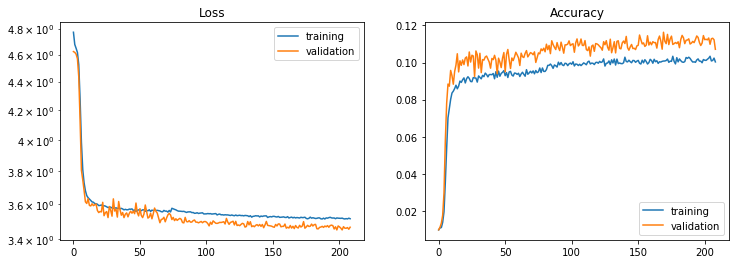

In [5]:
# Plot the training and validation losses.
tloss = np.loadtxt("train.txt")
vloss = np.loadtxt("val.txt")

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121);
plt.plot(tloss[:,0],tloss[:,1],label='training')
plt.plot(vloss[:,0],vloss[:,1],label='validation')
plt.legend()
plt.title("Loss")
plt.yscale('log')

ax2 = fig.add_subplot(122);
plt.plot(tloss[:,0],tloss[:,2],label='training')
plt.plot(vloss[:,0],vloss[:,2],label='validation')
plt.legend()
plt.title("Accuracy")

### Evaluate all events from a dataset

In [6]:
dset = tr.EMDataset("EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=0)
softmax = nn.Softmax(dim=1)
model.eval()

Created dataset for events from 0 to 100000


basicCNN(
  (conv1): Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (pool4): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=64, out_features=100, bias=True)
  (drop1): Dropout(p=0.5, inplace=False)
)

In [16]:
SHIFTED_ERR_RANGE_MIN = tr.PIXEL_ERR_RANGE_MIN - dset.add_shift*tr.PIXEL_SIZE
SHIFTED_ERR_RANGE_MAX = tr.PIXEL_ERR_RANGE_MAX + dset.add_shift*tr.PIXEL_SIZE
ERR_PIXEL_SIZE = tr.PIXEL_SIZE*(2*dset.add_shift+1)/tr.ERR_SIZE

def mult_gaussFun_Fit(x_y,*m):
    (x,y) = x_y
    A,x0,y0,varx,vary,C = m
    #print("x0 is {}".format(x0))
    X,Y = np.meshgrid(x,y)
    Z = A*np.exp(-0.5*((X-x0)**2/(varx)+(Y-y0)**2/(vary))) + C
    return Z.ravel()

# Compute sigma_x and sigma_y of the given probability distribution
def compute_sigmas(prob_dist):
    
    sum_tot = 0
    sum_x, sum_xsq = 0, 0
    sum_y, sum_ysq = 0, 0
    vmax = np.max(prob_dist)
    for i in range(prob_dist.size):
        
        xi = int(i % tr.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
        yi = int(i / tr.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
        
        vi = prob_dist[np.unravel_index(i,prob_dist.shape)]
        
        # Use a threshold of some fraction of vmax.
        if(vi > vmax / 10):
            sum_x   += xi*vi
            sum_xsq += xi**2*vi
            sum_y   += yi*vi
            sum_ysq += yi**2*vi
            sum_tot += vi
    
    # Compute mean and sigma.
    mean_x = sum_x/sum_tot
    mean_y = sum_y/sum_tot
    sigma_x = (sum_xsq/sum_tot - mean_x**2)**0.5
    sigma_y = (sum_ysq/sum_tot - mean_y**2)**0.5
    
    return sigma_x, sigma_y

def fit_sigmas(prob_dist,x,y,x0,y0,sigma_x0,sigma_y0):
    """
    Fit a 2D gaussian for sigma_x and sigma_y.
    
    prob_dist: the probability distribution
    x: a 1D list of the x-coordinates on the 2D grid (in mm)
    y: a 1D list of the y-coordinates on the 2D grid (in mm)
    x0: the initial guess for the x-value of the mean
    y0: the initial guess for the y-value of the mean
    sigma_x0: the initial guess for the sigma in the x-direction
    sigma_y0: the initial guess for the sigma in the y-direction
    """
    initial_guess = [np.max(prob_dist), x0, y0, sigma_x0**2, sigma_y0**2, np.max(prob_dist)/10.]
    bounds = ([0,x0-30*ERR_PIXEL_SIZE,y0-30*ERR_PIXEL_SIZE,0,0,0],[2*np.max(prob_dist),x0+30*ERR_PIXEL_SIZE,y0+30*ERR_PIXEL_SIZE,0.05,0.05,np.max(prob_dist)])
    
    try:
        popt, pcov = curve_fit(mult_gaussFun_Fit, (x, y), prob_dist.ravel(), p0=initial_guess, bounds=bounds)
    except (RuntimeError):
        print("Error in fit; using initial guess")
        return initial_guess,None
    
    return popt, pcov

In [57]:
evts = np.arange(80000,90000)

# Get the x and y coordinates of the 2D error prediction grid, in mm.
x_errgrid = np.arange(0,tr.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
y_errgrid = np.arange(0,tr.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2

l_evt_arr = []
l_evt, l_xtrue, l_ytrue, l_xpred, l_ypred, l_sigma_x_NN, l_sigma_y_NN = [], [], [], [], [], [], []

l_n_above_threshold, l_sum_above_threshold, l_max_dist_above_threshold = [], [], []
l_xmax, l_ymax = [], []
l_m1_x_above_threshold, l_m1_y_above_threshold, l_m2_x_above_threshold, l_m2_y_above_threshold = [], [], [], []
l_xc_3x3, l_yc_3x3, l_xc_3x3_above_threshold, l_yc_3x3_above_threshold = [], [], [], []
l_xc_5x5, l_yc_5x5, l_xc_5x5_above_threshold, l_yc_5x5_above_threshold = [], [], [], []
for evt in evts:
    
    evt_item = dset[evt]
    evt_arr = evt_item[0]
    evt_lbl = evt_item[1]
    evt_err_ind = evt_item[2]

    # Send through the model.
    data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
    target = torch.tensor(np.array(evt_err_ind)).long().cuda()
    output_score = model(data)
    
    # Compute the predicted pixel and (x,y) values.
    prob = np.array(softmax(output_score).cpu().detach().numpy()).reshape([tr.ERR_SIZE,tr.ERR_SIZE])
    ipred = np.argmax(prob)
    xpred = int(ipred % tr.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
    ypred = int(ipred / tr.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
    #print("[Evt",evt,"]: Index is",evt_err_ind,"with predicted",ipred,"; x = {} (predicted {}), y = {} (predicted {})".format(evt_lbl[0],xpred,evt_lbl[1],ypred))
    
    # Compute the sigmas of the distribution.
    #sigma_x0_NN, sigma_y0_NN = compute_sigmas(prob)
    #popt, pcov = fit_sigmas(prob,x_errgrid,y_errgrid,xpred,ypred,sigma_x0_NN,sigma_y0_NN)
    #xpred = popt[1]
    #ypred = popt[2]
    sigma_x_NN = 0 #popt[3]**0.5
    sigma_y_NN = 0 #popt[4]**0.5
    
    [n_above_threshold, sum_above_threshold, max_dist_above_threshold, 
        xmax, ymax,
        m1x_above_threshold, m1y_above_threshold, m2x_above_threshold, m2y_above_threshold, 
        xc_3x3, yc_3x3, xc_3x3_above_threshold, yc_3x3_above_threshold,
        xc_5x5, yc_5x5, xc_5x5_above_threshold, yc_5x5_above_threshold] = compute_key_quantities(evt_arr,tr.PIXEL_SIZE)
    
    # Fill the lists.
    l_evt.append(evt)
    l_xtrue.append(evt_lbl[0])
    l_ytrue.append(evt_lbl[1])
    l_xpred.append(xpred)
    l_ypred.append(ypred)
    l_sigma_x_NN.append(sigma_x_NN)
    l_sigma_y_NN.append(sigma_y_NN)
    
    l_evt_arr.append(evt_arr)
    
    l_n_above_threshold.append(n_above_threshold)
    l_sum_above_threshold.append(sum_above_threshold)
    l_max_dist_above_threshold.append(max_dist_above_threshold)
    l_xmax.append(xmax)
    l_ymax.append(ymax)
    l_m1_x_above_threshold.append(m1x_above_threshold)
    l_m1_y_above_threshold.append(m1y_above_threshold)
    l_m2_x_above_threshold.append(m2x_above_threshold)
    l_m2_y_above_threshold.append(m2y_above_threshold)
    l_xc_3x3.append(xc_3x3)
    l_yc_3x3.append(yc_3x3)
    l_xc_3x3_above_threshold.append(xc_3x3_above_threshold)
    l_yc_3x3_above_threshold.append(yc_3x3_above_threshold)
    l_xc_5x5.append(xc_5x5)
    l_yc_5x5.append(yc_5x5)
    l_xc_5x5_above_threshold.append(xc_5x5_above_threshold)
    l_yc_5x5_above_threshold.append(yc_5x5_above_threshold)
    
    if((evt-evts[0]) % (len(evts)/100) == 0):
        print("{}% done".format(int((evt-evts[0]) / (len(evts)/100))))

# Create the dataframe.
evt_dict = {'event': l_evt, 'x_true': l_xtrue, 'y_true': l_ytrue, 'x_pred': l_xpred, 'y_pred': l_ypred, 
            'sigma_x_NN': l_sigma_x_NN, 'sigma_y_NN': l_sigma_y_NN,
            'n_above_threshold': l_n_above_threshold, 
            'sum_above_threshold': l_sum_above_threshold, 
            'max_dist_above_threshold': l_max_dist_above_threshold,
            'xmax_pixel': l_xmax,
            'ymax_pixel': l_ymax,
            'm1_x_above_threshold': l_m1_x_above_threshold, 
            'm1_y_above_threshold': l_m1_y_above_threshold,
            'm2_x_above_threshold': l_m2_x_above_threshold,
            'm2_y_above_threshold': l_m2_y_above_threshold,
            'xc_3x3': l_xc_3x3,
            'yc_3x3': l_yc_3x3,
            'xc_3x3_above_threshold': l_xc_3x3_above_threshold,
            'yc_3x3_above_threshold': l_yc_3x3_above_threshold,
            'xc_5x5': l_xc_5x5,
            'yc_5x5': l_yc_5x5,
            'xc_5x5_above_threshold': l_xc_5x5_above_threshold,
            'yc_5x5_above_threshold': l_yc_5x5_above_threshold}
df = pd.DataFrame.from_dict(evt_dict)

# Create derived quantities.
df["sigma_r_NN"] = (df.sigma_x_NN**2 + df.sigma_y_NN**2)**0.5
df["error_x_NN"] = df.x_pred - df.x_true
df["error_y_NN"] = df.y_pred - df.y_true
df["error_r_NN"] = (df.error_x_NN**2 + df.error_y_NN**2)**0.5
df["sigma_x_above_threshold"] = df.m2_x_above_threshold - df.m1_x_above_threshold**2
df["sigma_y_above_threshold"] = df.m2_y_above_threshold - df.m1_y_above_threshold**2
df["sigma_max_above_threshold"] = df[["sigma_x_above_threshold", "sigma_y_above_threshold"]].max(axis=1)
df["sigma_min_above_threshold"] = df[["sigma_x_above_threshold", "sigma_y_above_threshold"]].min(axis=1)
df["error_x_maxpt"] = df.xmax_pixel - df.x_true
df["error_y_maxpt"] = df.ymax_pixel - df.y_true
df["error_r_maxpt"] = (df.error_x_maxpt**2 + df.error_y_maxpt**2)**0.5
df["error_x_th"] = df.m1_x_above_threshold - df.x_true
df["error_y_th"] = df.m1_y_above_threshold - df.y_true
df["error_r_th"] = (df.error_x_th**2 + df.error_y_th**2)**0.5
df["error_x_3x3"] = df.xc_3x3 - df.x_true
df["error_y_3x3"] = df.yc_3x3 - df.y_true
df["error_r_3x3"] = (df.error_x_3x3**2 + df.error_y_3x3**2)**0.5
df["error_x_3x3_th"] = df.xc_3x3_above_threshold - df.x_true
df["error_y_3x3_th"] = df.yc_3x3_above_threshold - df.y_true
df["error_r_3x3_th"] = (df.error_x_3x3_th**2 + df.error_y_3x3_th**2)**0.5
df["error_x_5x5"] = df.xc_5x5 - df.x_true
df["error_y_5x5"] = df.yc_5x5 - df.y_true
df["error_r_5x5"] = (df.error_x_5x5**2 + df.error_y_5x5**2)**0.5
df["error_x_5x5_th"] = df.xc_5x5_above_threshold - df.x_true
df["error_y_5x5_th"] = df.yc_5x5_above_threshold - df.y_true
df["error_r_5x5_th"] = (df.error_x_5x5_th**2 + df.error_y_5x5_th**2)**0.5

0% done
1% done
2% done
3% done
4% done
5% done
6% done
7% done
8% done
9% done
10% done
11% done
12% done
13% done
14% done
15% done
16% done
17% done
18% done
19% done
20% done
21% done
22% done
23% done
24% done
25% done
26% done
27% done
28% done
29% done
30% done
31% done
32% done
33% done
34% done
35% done
36% done
37% done
38% done
39% done
40% done
41% done
42% done
43% done
44% done
45% done
46% done
47% done
48% done
49% done
50% done
51% done
52% done
53% done
54% done
55% done
56% done
57% done
58% done
59% done
60% done
61% done
62% done
63% done
64% done
65% done
66% done
67% done
68% done
69% done
70% done
71% done
72% done
73% done
74% done
75% done
76% done
77% done
78% done
79% done
80% done
81% done
82% done
83% done
84% done
85% done
86% done
87% done
88% done
89% done
90% done
91% done
92% done
93% done
94% done
95% done
96% done
97% done
98% done
99% done


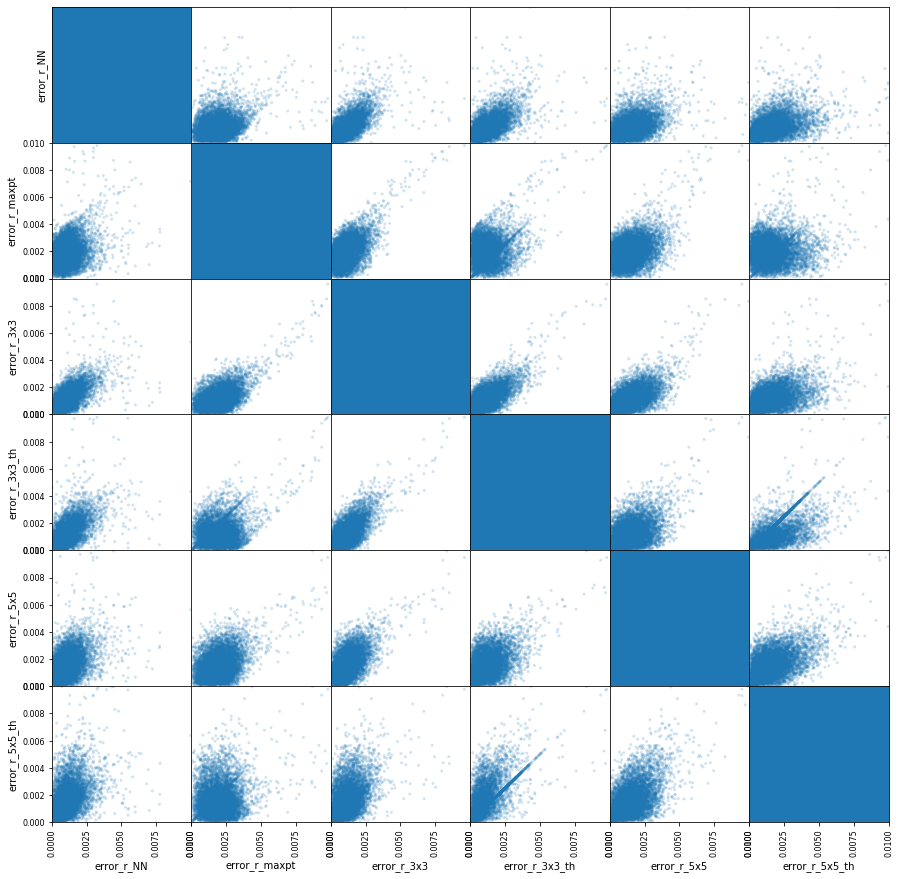

In [19]:
axes = pd.plotting.scatter_matrix(df[["error_r_NN","error_r_maxpt","error_r_3x3","error_r_3x3_th","error_r_5x5","error_r_5x5_th"]], 
                                  figsize=[15,15], alpha=0.2, hist_kwds={'bins':100})
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        #if i == j:  # only the histograms
        #ax.set_yscale('log')
        ax.set_xlim(0,0.01)
        ax.set_ylim(0,0.01)
            
plt.savefig("errors_scatter_matrix.pdf")

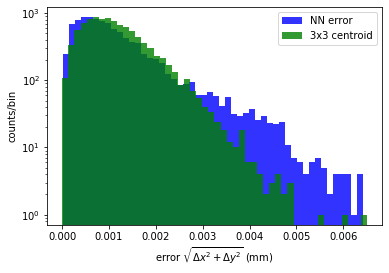

In [58]:
err_cut = 0.02
sigma_cut = 1e9
plt.hist(df[(df.error_r_NN < err_cut) & (df.sigma_r_NN < sigma_cut)].error_r_NN,alpha=0.8,bins=50,color='blue',label='NN error')
plt.hist(df[(df.error_r_3x3 < err_cut) & (df.sigma_r_NN < sigma_cut)].error_r_3x3,alpha=0.8,bins=50,color='green',label='3x3 centroid')
plt.xlabel("error $\sqrt{\Delta x^2 + \Delta y^2}$ (mm)")
plt.ylabel("counts/bin")
plt.yscale('log')
plt.legend()

In [59]:
df[(df.error_r_NN > 0.006)]

,event,x_true,y_true,x_pred,y_pred,sigma_x_NN,sigma_y_NN,n_above_threshold,sum_above_threshold,max_dist_above_threshold,...,error_r_3x3,error_x_3x3_th,error_y_3x3_th,error_r_3x3_th,error_x_5x5,error_y_5x5,error_r_5x5,error_x_5x5_th,error_y_5x5_th,error_r_5x5_th
1183,81183,0.002261,0.002151,-0.00225,-0.00225,0,0,31,1514.836382,0.209404,...,0.001958,-0.002261,-0.002151,0.003120,-0.000175,-0.004102,0.004105,-0.002261,-0.002151,0.003120
2117,82117,0.002434,0.001974,-0.00225,-0.00225,0,0,43,2040.653878,0.265754,...,0.003052,0.002566,-0.001974,0.003237,-0.000713,-0.001190,0.001387,0.000273,0.002611,0.002626
3322,83322,0.002368,-0.002204,-0.00225,0.00225,0,0,38,1762.023428,0.246018,...,0.002902,-0.002368,0.002204,0.003235,-0.001194,0.003931,0.004109,0.007632,0.012204,0.014394
3671,83671,0.002326,-0.001791,-0.00225,0.00225,0,0,35,1638.100476,0.245204,...,0.002289,0.000406,0.001791,0.001837,-0.002320,-0.001171,0.002598,0.000406,0.001791,0.001837
3813,83813,0.001607,0.002393,-0.00225,-0.00225,0,0,43,2006.685217,0.268794,...,0.002769,-0.001607,-0.002393,0.002883,-0.002737,-0.001497,0.003120,-0.001607,-0.002393,0.002883
4778,84778,0.002481,-0.002010,-0.00225,0.00225,0,0,47,2158.315659,0.258118,...,0.002714,-0.002481,0.002010,0.003193,-0.001285,0.001441,0.001931,-0.002481,0.002010,0.003193
5441,85441,0.002049,-0.002284,-0.00225,0.00225,0,0,43,2055.388179,0.275772,...,0.001787,0.002951,-0.002716,0.004011,0.001103,0.003237,0.003420,0.002951,-0.002716,0.004011
5494,85494,0.001498,-0.002494,-0.00225,0.00225,0,0,36,1720.581043,0.202485,...,0.000983,0.000324,-0.002506,0.002527,-0.000272,0.003187,0.003198,0.001273,0.001972,0.002348
7298,87298,-0.002449,0.002256,0.00175,-0.00225,0,0,34,1615.888704,0.224109,...,0.001798,-0.002551,0.002744,0.003747,0.002363,-0.000920,0.002536,-0.002551,0.002744,0.003747
9887,89887,0.002405,0.001574,-0.00225,-0.00225,0,0,23,1070.711644,0.222092,...,0.004007,-0.002405,-0.001574,0.002875,-0.005382,-0.000005,0.005382,-0.012405,-0.006574,0.014040


In [61]:
df["error_r_diff"] = df.error_r_NN - df.error_r_3x3

Text(0.5, 0, 'error difference (NN - 3x3-method)')

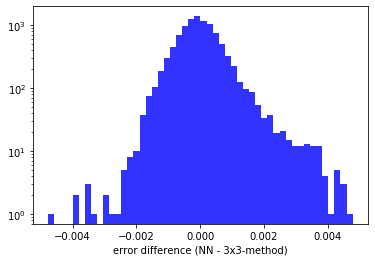

In [62]:
err_diff_cut = 0.005
plt.hist(df[(df.error_r_diff < err_diff_cut) & (df.error_r_diff > -err_diff_cut) & (df.sigma_r_NN < 0.011)].error_r_diff,alpha=0.8,bins=50,color='blue',label='NN error')
plt.yscale("log")
plt.xlabel("error difference (NN - 3x3-method)")

In [ ]:
# Save dataframe and event arrays.
df.to_pickle("evts_80000_to_90000.pkl")
np.savez("evt_arrays.npz",evt_arrays=l_evt_arr)

In [ ]:
df = pd.read_pickle("evts_80000_to_90000.pkl")

In [ ]:
cut_sigma = 0.011

fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121)
plt.hist(df[df.sigma_r_NN < cut_sigma].error_r_NN,bins=50)
plt.yscale("log")
plt.xlabel("error $\sqrt{\Delta x^2 + \Delta y^2}$ (mm)")
plt.ylabel("Counts/bin")

ax2 = fig.add_subplot(122)
plt.hist(df[df.sigma_r_NN < cut_sigma].sigma_r_NN,bins=50)
plt.xlabel("$\sqrt{\sigma_x^2 + \sigma_y^2}$ of probability distribution (mm)")
plt.ylabel("Counts/bin")

In [ ]:
eff, mean_err = [], []
cut_sigmas = np.arange(0.003,0.4,0.0005)
for cut_sigma in cut_sigmas:
    df_cut = df[df.sigma_r_NN < cut_sigma]
    
    eff.append(len(df_cut)/len(df))
    mean_err.append(df_cut.error_r_NN.mean())
    
    print("[SIGMA = {}]: EFF = {}, ERR = {}".format(cut_sigma,len(df_cut)/len(df),df_cut.error_r_NN.mean()))

eff = np.array(eff)
mean_err = np.array(mean_err)
plt.plot(mean_err,eff,'.-')
plt.xlabel("Mean error (mm)")
plt.ylabel("Efficiency")


### Test the net

In [37]:
dset = tr.EMDataset("EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=0)
softmax = nn.Softmax(dim=1)
model.eval()

Created dataset for events from 0 to 100000


basicCNN(
  (conv1): Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (pool4): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=64, out_features=100, bias=True)
  (drop1): Dropout(p=0.5, inplace=False)
)

Computed index: 64 for max added shift: 0
Gaussian fit parameters A*exp(-0.5*((x-x0)**2/varX + (y-y0)**2/varY)) + C:
A = 0.06781555706086594
(x0, y0) = (-0.0004865424993125514,0.0009347001066718464)
(sigma_x, sigma_y) = (0.0007568227881265126,0.0006965655116872961)
C = 0.0011424357686452252


Text(0.5, 1.0, '2D Gaussian fit')

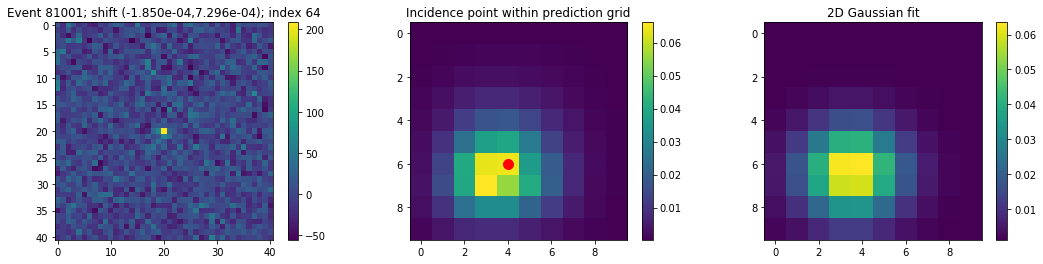

In [47]:
evt_plt = 81001
evt_item = dset[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1]
evt_err_ind = evt_item[2]

SHIFTED_ERR_RANGE_MIN = tr.PIXEL_ERR_RANGE_MIN - dset.add_shift*tr.PIXEL_SIZE
SHIFTED_ERR_RANGE_MAX = tr.PIXEL_ERR_RANGE_MAX + dset.add_shift*tr.PIXEL_SIZE

xbin = int(tr.ERR_SIZE*(evt_lbl[0] - SHIFTED_ERR_RANGE_MIN)/(SHIFTED_ERR_RANGE_MAX - SHIFTED_ERR_RANGE_MIN))
xbin = max(xbin,0)
xbin = min(xbin,tr.ERR_SIZE-1)

ybin = int(tr.ERR_SIZE*(evt_lbl[1] - SHIFTED_ERR_RANGE_MIN)/(SHIFTED_ERR_RANGE_MAX - SHIFTED_ERR_RANGE_MIN))
ybin = max(ybin,0)
ybin = min(ybin,tr.ERR_SIZE-1)

print("Computed index:",(ybin*tr.ERR_SIZE) + xbin,"for max added shift:",dset.add_shift)

# Send through the model.
data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
target = torch.tensor(np.array(evt_err_ind)).long().cuda()
output_score = model(data)

# Compute the predicted pixel and (x,y) values.
prob = np.array(softmax(output_score).cpu().detach().numpy()).reshape([tr.ERR_SIZE,tr.ERR_SIZE])
ipred = np.argmax(prob)
xpred = int(ipred % tr.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
ypred = int(ipred / tr.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
#print("[Evt",evt,"]: Index is",evt_err_ind,"with predicted",ipred,"; x = {} (predicted {}), y = {} (predicted {})".format(evt_lbl[0],xpred,evt_lbl[1],ypred))

# Compute the sigmas of the distribution.
sigma_x0, sigma_y0 = compute_sigmas(prob)
popt, pcov = fit_sigmas(prob,x_errgrid,y_errgrid,xpred,ypred,sigma_x0,sigma_y0)
fit_data = mult_gaussFun_Fit((x_errgrid,y_errgrid),*popt).reshape([tr.ERR_SIZE,tr.ERR_SIZE])
print("Gaussian fit parameters A*exp(-0.5*((x-x0)**2/varX + (y-y0)**2/varY)) + C:")
print("A = {}".format(popt[0]))
print("(x0, y0) = ({},{})".format(popt[1],popt[2]))
print("(sigma_x, sigma_y) = ({},{})".format(popt[3]**0.5,popt[4]**0.5))
print("C = {}".format(popt[5]))

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(18.0)

ax1 = fig.add_subplot(131)
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event {}; shift ({:.3e},{:.3e}); index {}".format(evt_plt,evt_lbl[0],evt_lbl[1],evt_err_ind))

ax2 = fig.add_subplot(132)
ax2.plot([xbin],[ybin],color='red',marker='o',markersize=10)
plt.imshow(prob)
plt.colorbar()
plt.title("Incidence point within prediction grid")

ax3 = fig.add_subplot(133)
plt.imshow(fit_data)
plt.colorbar()
plt.title("2D Gaussian fit")

# Misc. code

In [ ]:
# Look at many events:
xpred_err, ypred_err = [], []
for evt_plt in np.arange(8000,9999):
    
    evt_item = dset[evt_plt]
    evt_arr = evt_item[0]
    evt_lbl = evt_item[1]
    evt_err_ind = evt_item[2]

    # Send through the model.
    data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
    target = torch.tensor(np.array(evt_err_ind)).long().cuda()

    output_score = model(data)
    prob = np.argmax(np.array(softmax(output_score).cpu().detach().numpy()).reshape([10,10]))
    xpred = (prob % tr.ERR_SIZE)*0.005/tr.ERR_SIZE + tr.ERR_RANGE_MIN + 0.005/tr.ERR_SIZE/2
    ypred = (prob / tr.ERR_SIZE)*0.005/tr.ERR_SIZE + tr.ERR_RANGE_MIN + 0.005/tr.ERR_SIZE/2
    print("[Evt",evt_plt,"]: Index is",evt_err_ind,"with predicted",prob,"; x = {} (predicted {}), y = {} (predicted {})".format(evt_lbl[0],xpred,evt_lbl[1],ypred))
    
    xpred_err.append(xpred-evt_lbl[0])
    ypred_err.append(ypred-evt_lbl[1])
xpred_err = np.array(xpred_err)
ypred_err = np.array(ypred_err)

In [ ]:
fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121);
plt.hist(xpred_err)
plt.xlabel("error in x-prediction (mm)")
print(np.where(abs(xpred_err) > 0.001))

ax2 = fig.add_subplot(122)
plt.hist(ypred_err)
plt.xlabel("error in y-prediction (mm)")
